In [1]:
%load_ext autoreload
%autoreload 2 
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../.venv/lib/python3.7/site-packages/')

In [2]:
import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import reliability as rel
import calibration as cal
from sklearn.metrics import accuracy_score

In [3]:
plt.style.use("ggplot")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

In [4]:
def plot_reliability(probs, classes, kernel, even_mass, num_points, fig, ax, q_label,
                     show_bars=False, show_counts=False, show_kernel=False, show_colormap=False):   
    curve = rel.ReliabilityFit(probs, classes, kernel, even_mass).get_curve(num_points)
    curve.plot(fig, ax, False, show_bars, show_counts, show_kernel, show_colormap)
    ece = curve.ece()
    ax.set_title(q_label+"\n"+f"(ECE={ece:.2f})", pad=15)
    ax.set_aspect('equal')
    
    return curve

def plot_unified_reliability(probs, classes, kernel, even_mass, num_points, show_bars=False, 
                             show_counts=False, show_kernel=False, show_colormap=False):    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    titles = [
        'Class 0',
        'Class 1',
        'Class 2'
    ]
    for i in range(3):        
        curve = plot_reliability(probs[:, i], 
                                 np.array(classes==i, dtype=int), 
                                 kernel, 
                                 even_mass, 
                                 num_points, 
                                 fig,
                                 ax[i], 
                                 titles[i],
                                 show_bars, 
                                 show_counts, 
                                 show_kernel,
                                 show_colormap)
        
    plt.show()

def plot_cal_curve(cal_method):    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    X = np.empty((100, 3))
    X[:, 0] = np.linspace(0, 1, 100)
    X[:, 1] = np.linspace(0, 1, 100)
    X[:, 2] = np.linspace(0, 1, 100)
    Y = cal_method.transform(X, False)
    
    titles = [
        'Class 0',
        'Class 1',
        'Class 2'
    ]
    for i in range(3):        
        ax[i].plot(X[:, i], Y[:, i])
        ax[i].set_title(titles[i])
        ax[i].set_aspect('equal')
        
    plt.show()

def plot_calibration_grid(probs_train, classes_train, cal_method, classes_val, kernel=rel.DeltaKernel(), 
                          num_points=10, even_mass=False, show_counts=True, show_kernel=False, plot_curve=False):
    accuracy = accuracy_score(classes_train, np.argmax(probs_train, axis=1))
    print('Original Training - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(probs_train, 
                             classes_train, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)
    
    if plot_curve:
        print('Calibration Curve') 
        plot_cal_curve(cal_method)
    
    print('Calibrated Training (unormalized)')
    cal_probs = cal_method.transform(probs_train, normalize=False)
    plot_unified_reliability(cal_probs, 
                             classes_train, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)
    
    cal_probs = cal_method.transform(probs_train, normalize=True)
    accuracy = accuracy_score(classes_train, np.argmax(cal_probs, axis=1))
    print('Calibrated Training (normalized) - Accuracy = {:.2f}'.format(accuracy))    
    plot_unified_reliability(cal_probs, 
                             classes_train, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)
    
    accuracy = accuracy_score(classes_val, np.argmax(probs_val, axis=1))
    print('Original Val - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(probs_val, 
                             classes_val, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)

    print('Calibrated Val (unormalized)')
    cal_probs = cal_method.transform(probs_val, normalize=False)
    plot_unified_reliability(cal_probs, 
                             classes_val, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)
    
    cal_probs = cal_method.transform(probs_val, normalize=True)
    accuracy = accuracy_score(classes_val, np.argmax(cal_probs, axis=1))
    print('Calibrated Val (normalized) - Accuracy = {:.2f}'.format(accuracy))
    plot_unified_reliability(cal_probs, 
                             classes_val, 
                             kernel, 
                             even_mass=even_mass, 
                             num_points=num_points,                          
                             show_bars=True, 
                             show_counts=show_counts, 
                             show_kernel=show_kernel, 
                             show_colormap=False)

# Data

In [5]:
# Generate a random classification problem
def get_data(num_probs = 1000):
    np.random.seed(42)
    X, y = datasets.make_classification(n_samples=6000, n_features=20, n_informative=3, n_redundant=17, n_classes=3)
    
    train_samples = 6000 - 2*num_probs  # Samples used for training the model
    X_train = X[:train_samples]
    X_test = X[train_samples:]
    y_train = y[:train_samples]
    y_test = y[train_samples:]

    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    prob_pos = rfc.predict_proba(X_test)

    probs_train = prob_pos[:num_probs, :] # Used to calibrate the curves
    classes_train = y_test[:num_probs]
    probs_val = prob_pos[num_probs:, :] # Used to test the calibration
    classes_val = y_test[num_probs:]
    
    return probs_train, classes_train, probs_val, classes_val

In [6]:
NUM_PROBS = 100
probs_train, classes_train, probs_val, classes_val = get_data(NUM_PROBS)

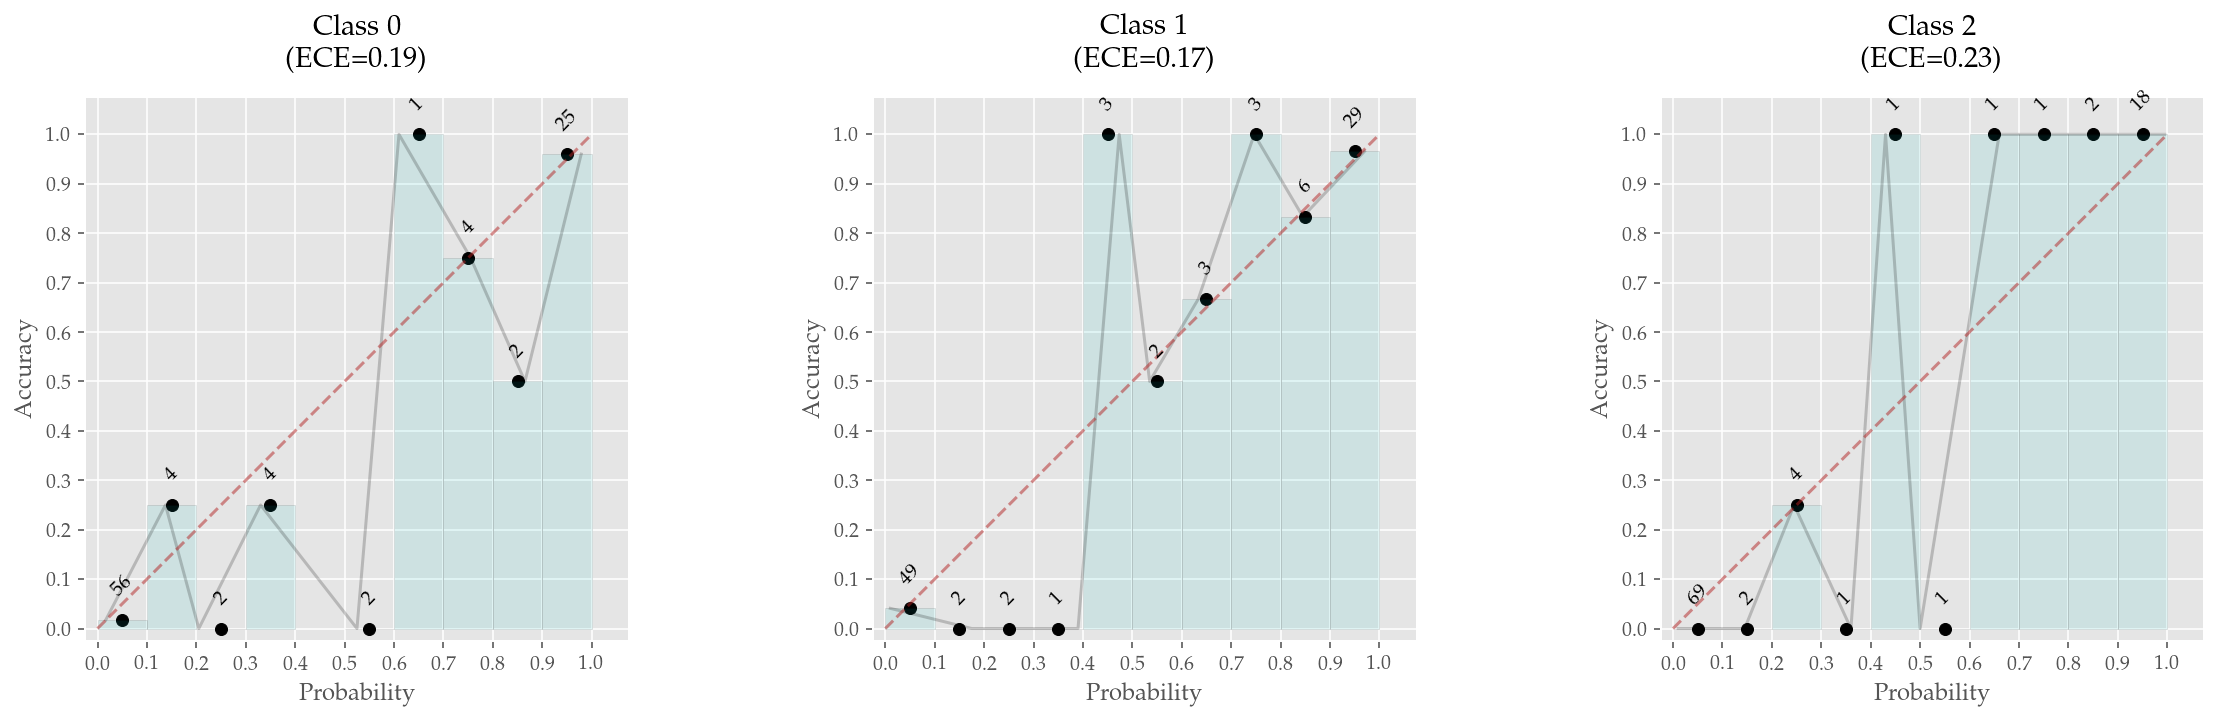

In [7]:
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.DeltaKernel(), 
                         even_mass=False, 
                         num_points=10,                          
                         show_bars=True, 
                         show_counts=True, 
                         show_kernel=False, 
                         show_colormap=False)

# Binning

Original Training - Accuracy = 0.91


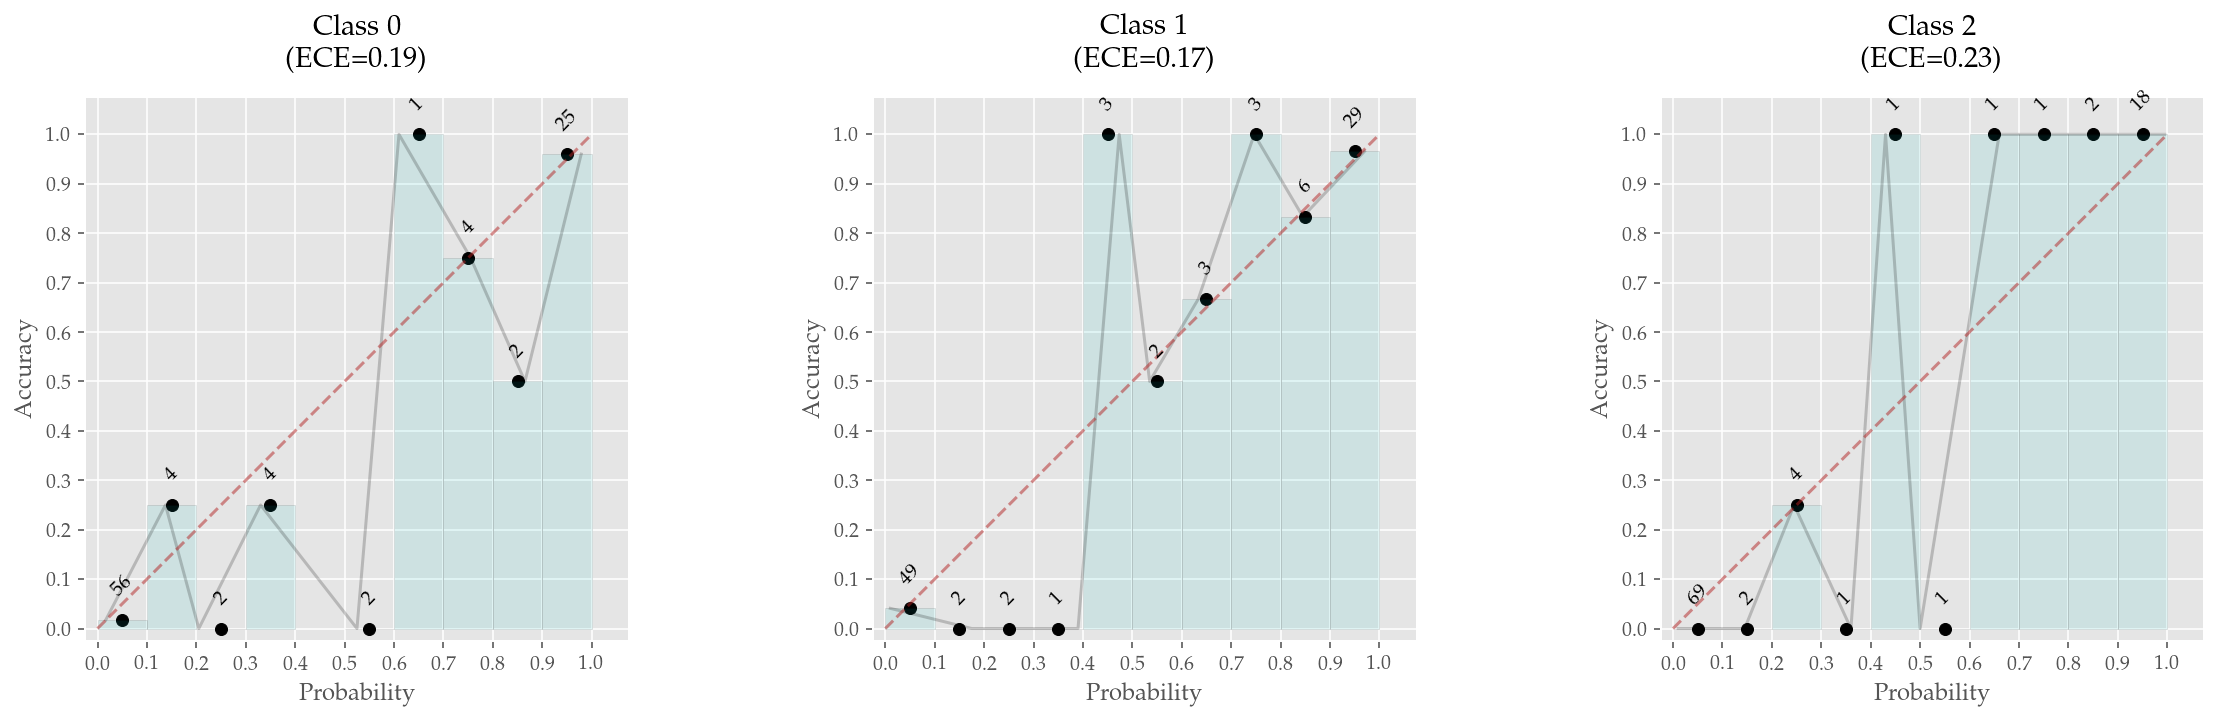

Calibrated Training (unormalized)


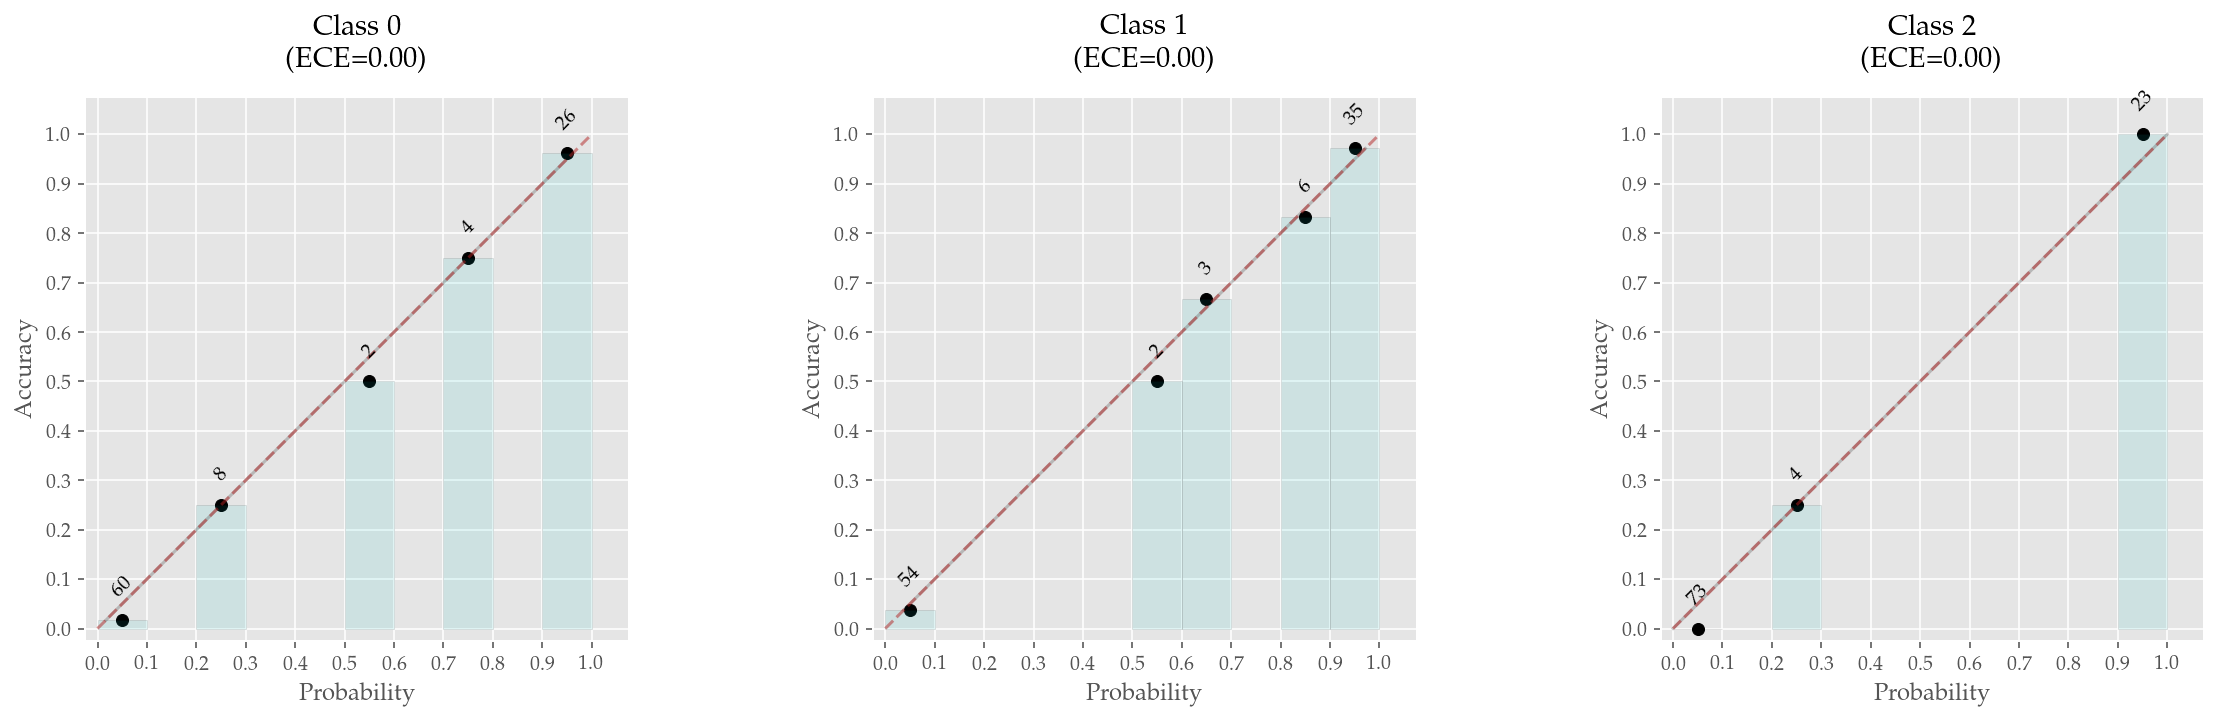

Calibrated Training (normalized) - Accuracy = 0.94


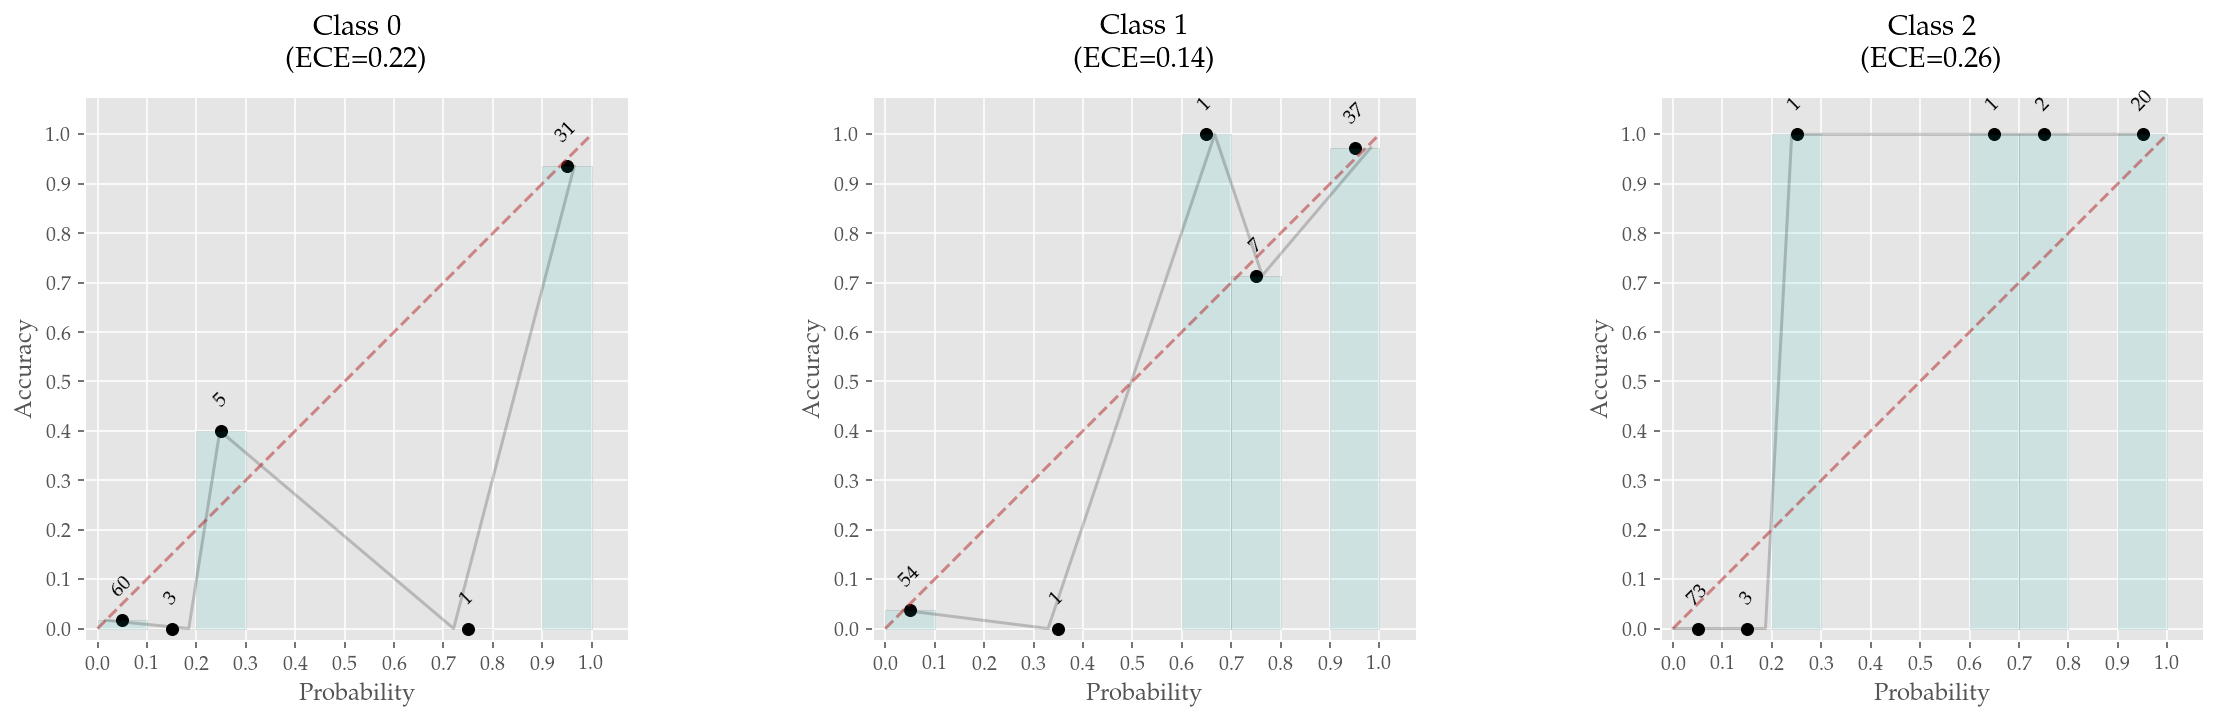

Original Val - Accuracy = 0.92


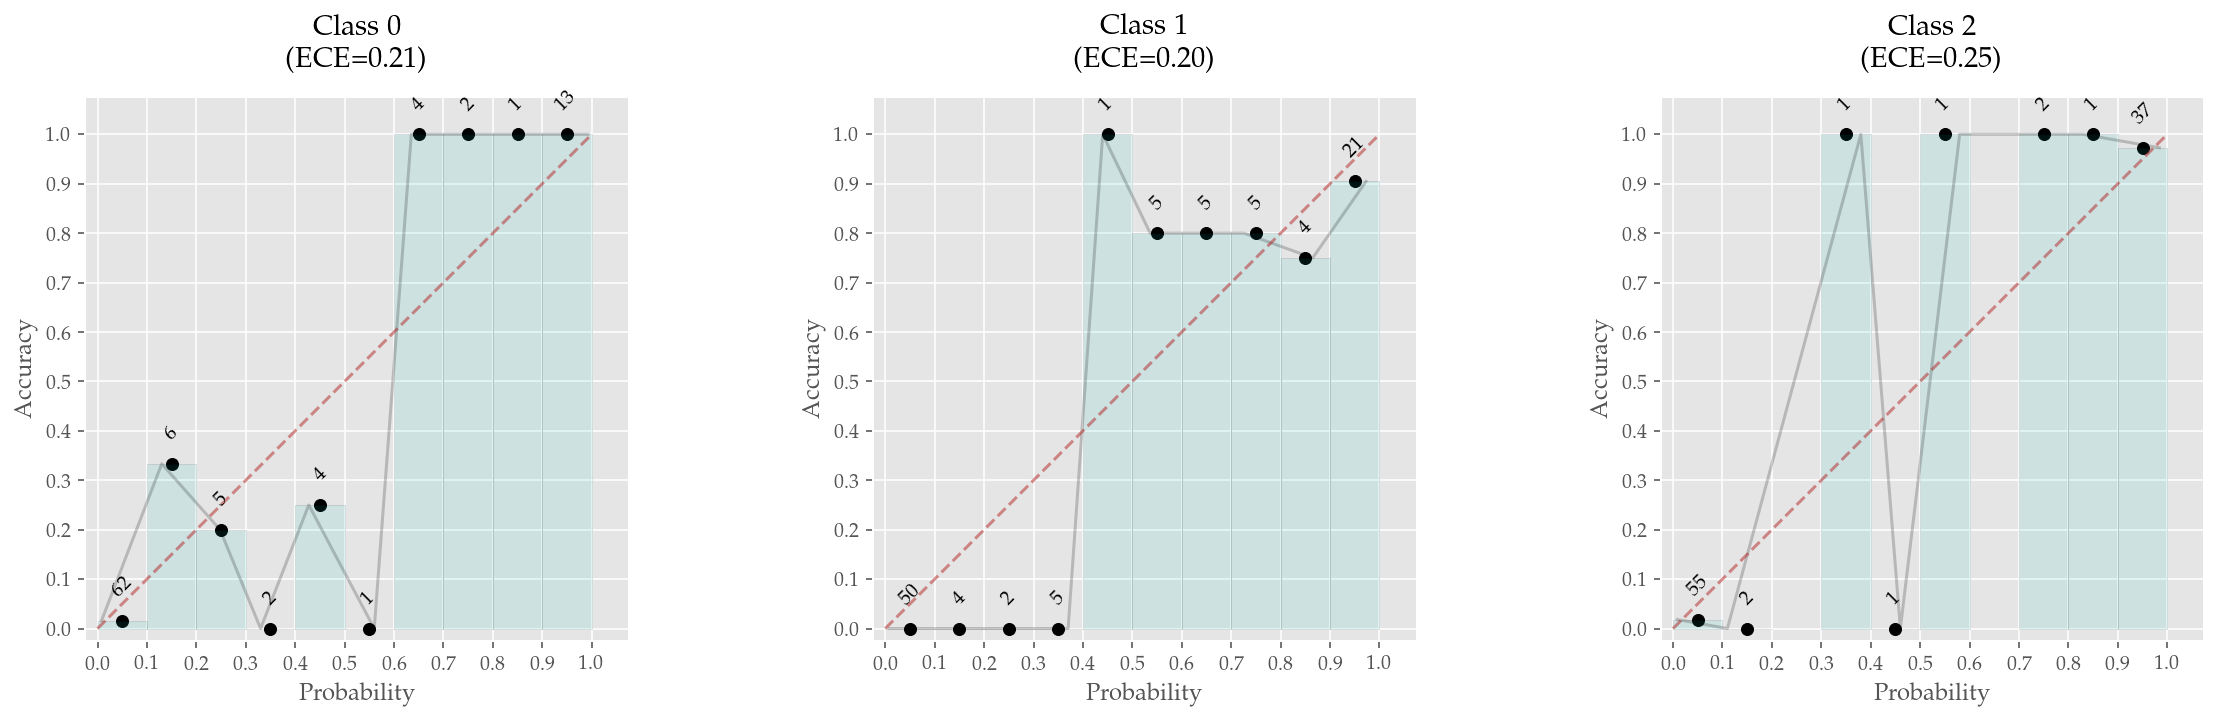

Calibrated Val (unormalized)


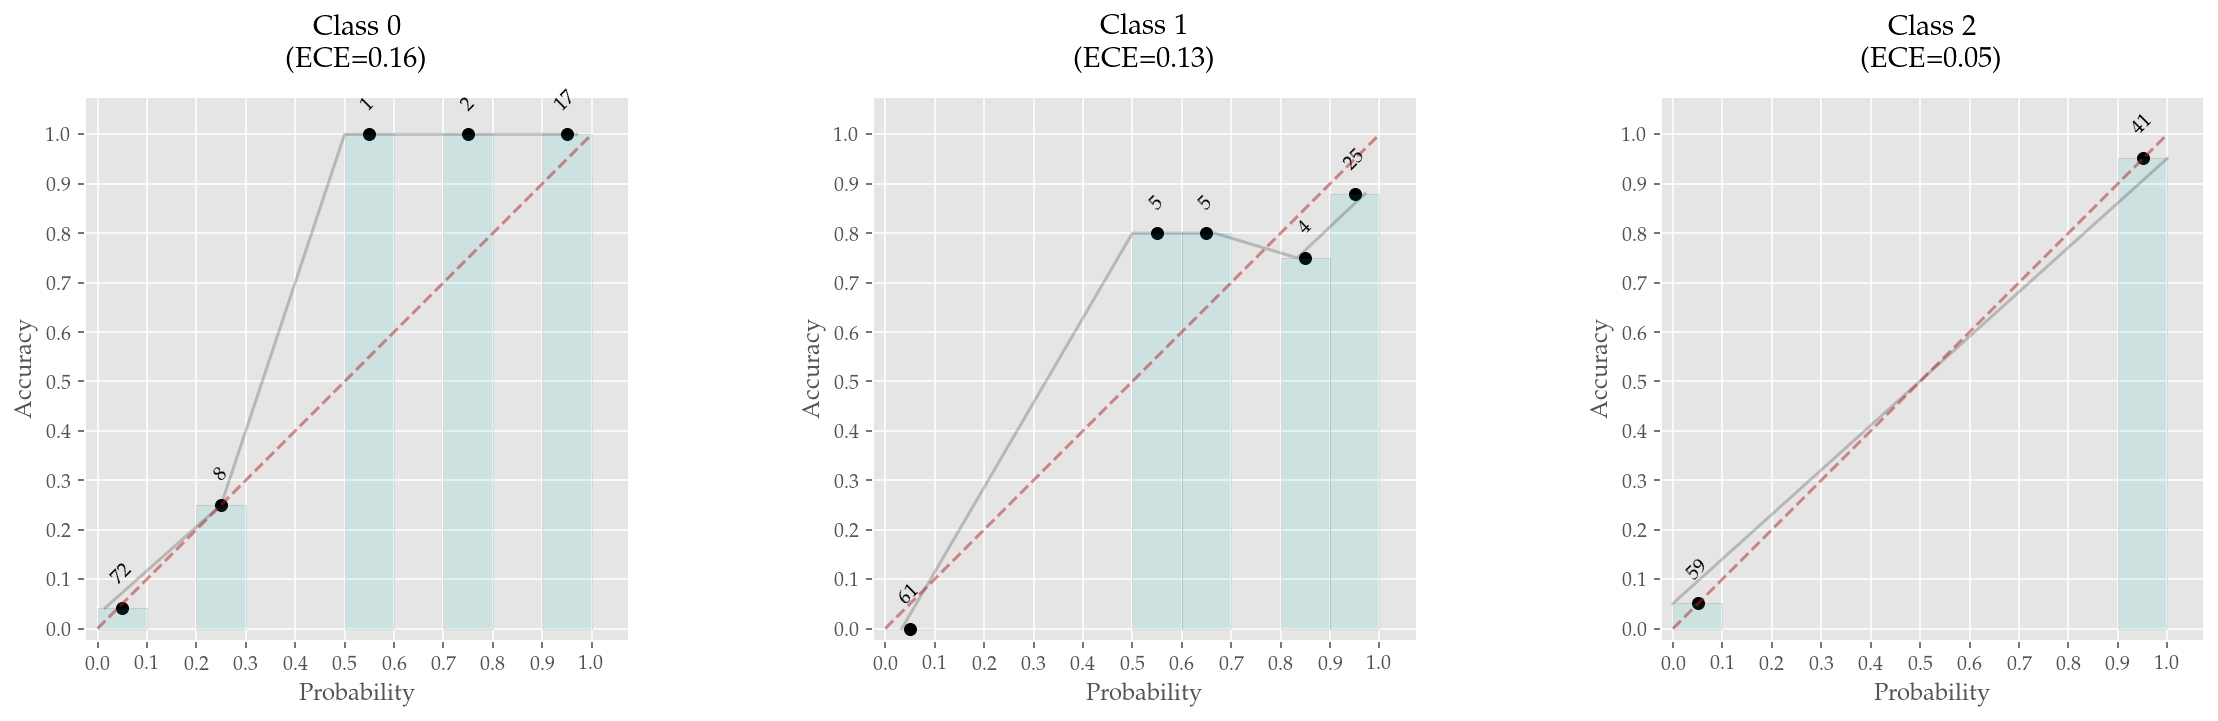

Calibrated Val (normalized) - Accuracy = 0.91


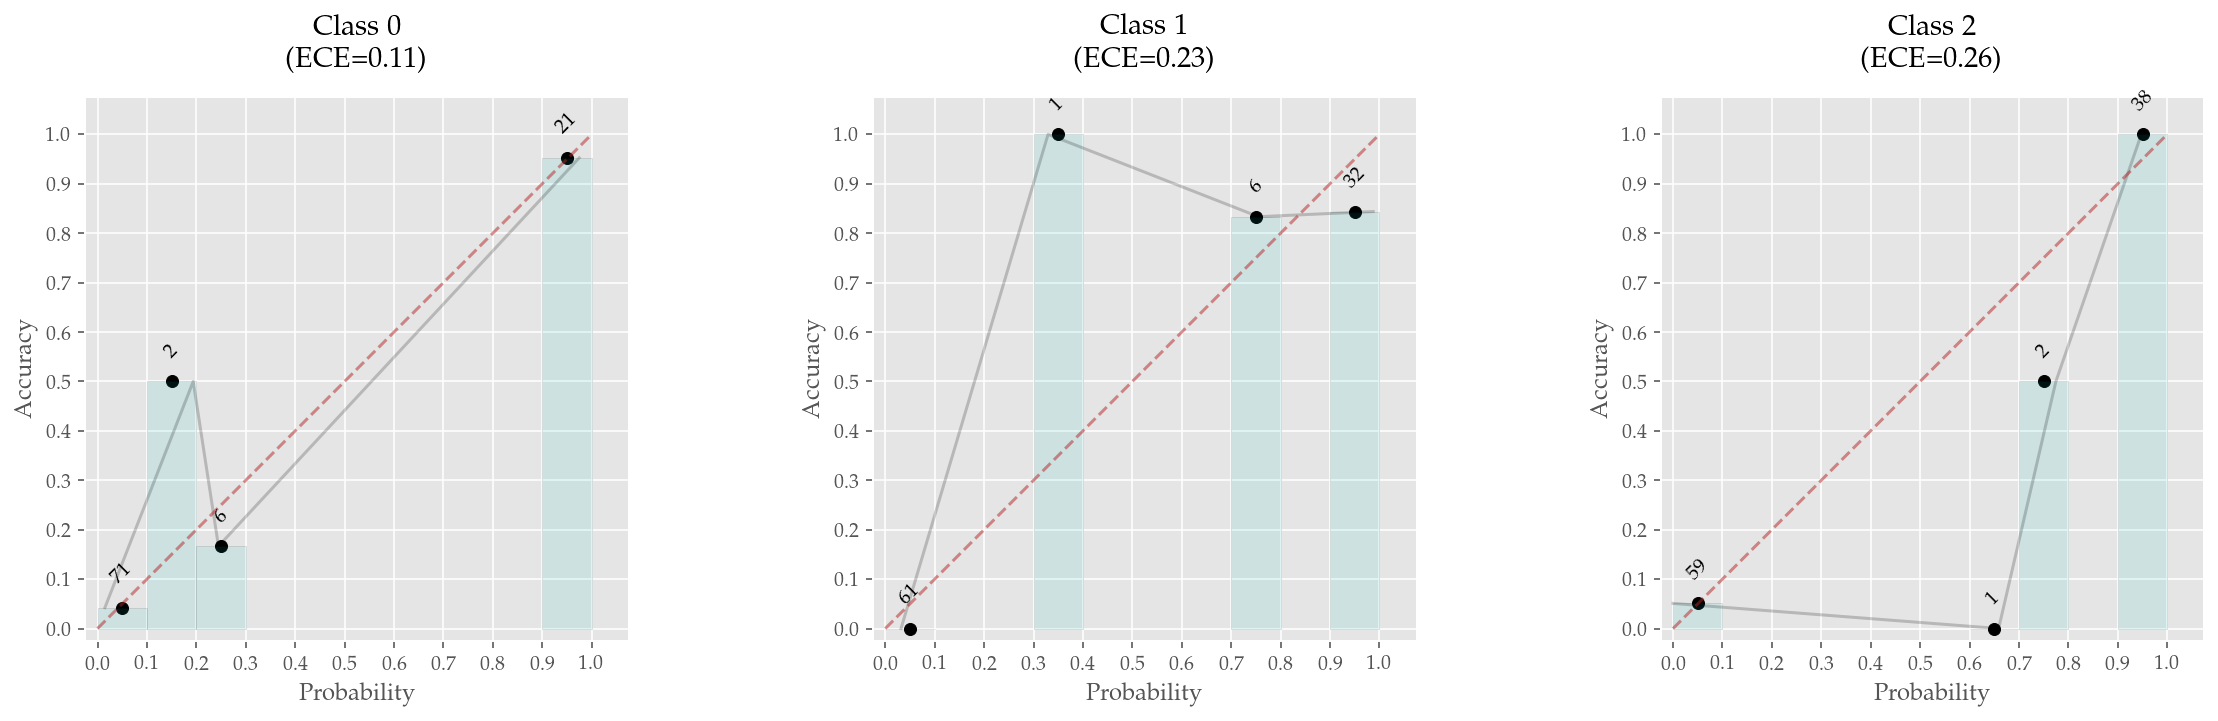

In [8]:
binning = cal.BinningCalibration(num_points=10, even_mass=False)
binning.fit(probs_train, classes_train)
plot_calibration_grid(probs_train, classes_train, binning, classes_val)

# Isotonic

Original Training - Accuracy = 0.91


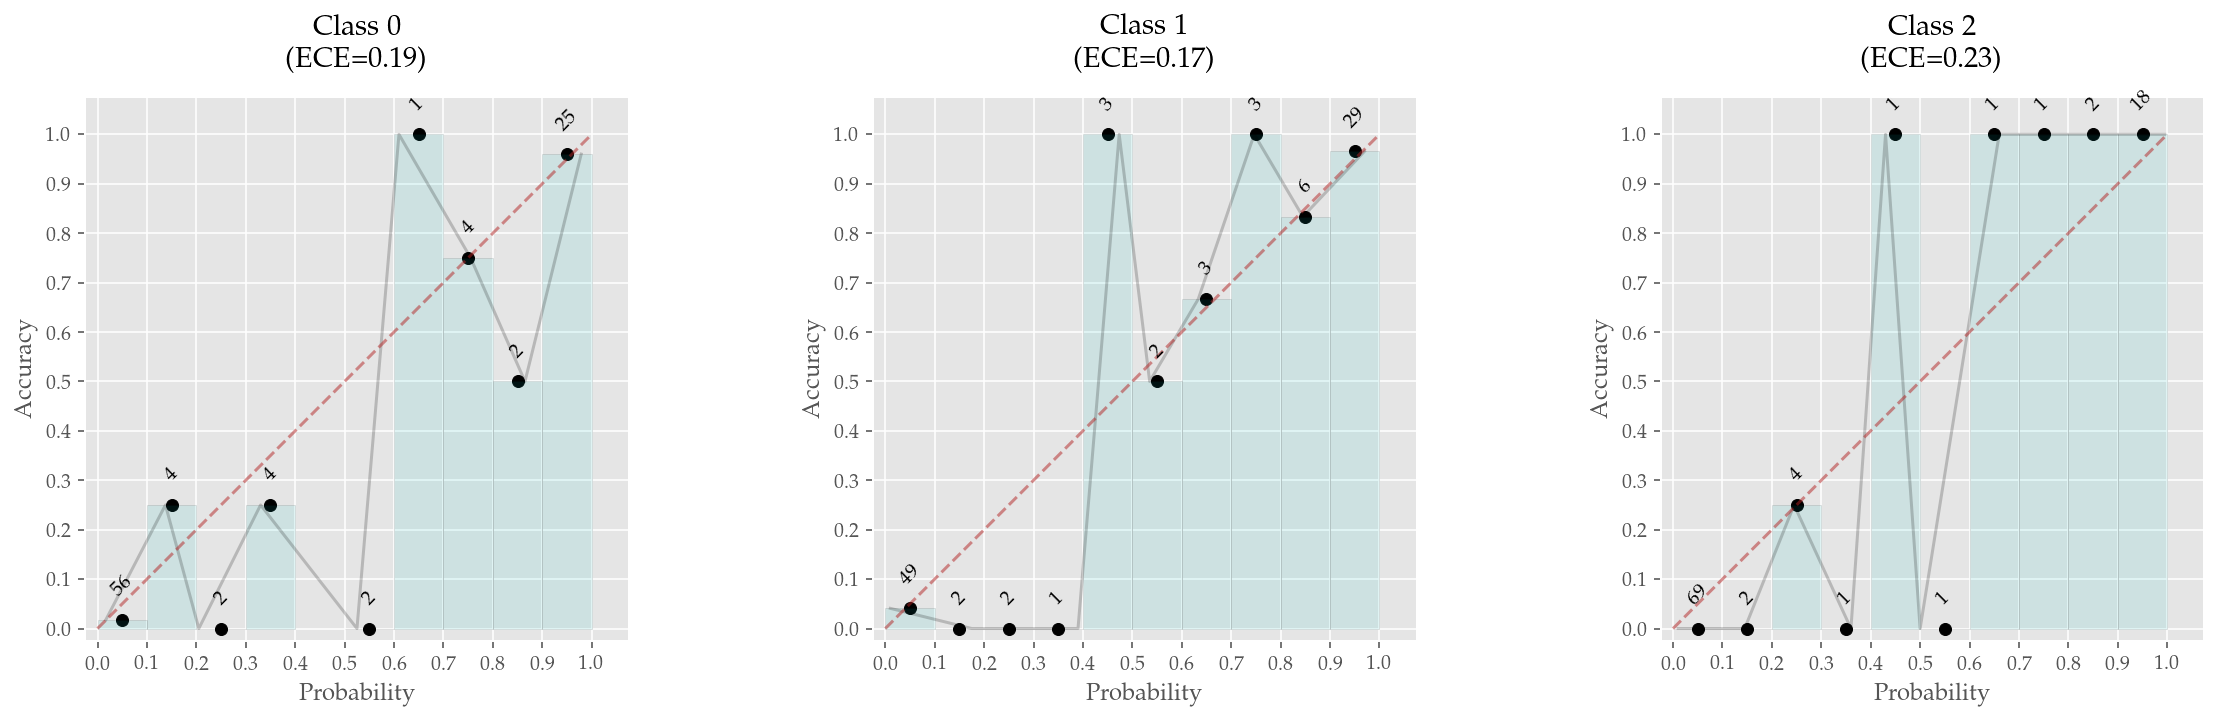

Calibrated Training (unormalized)


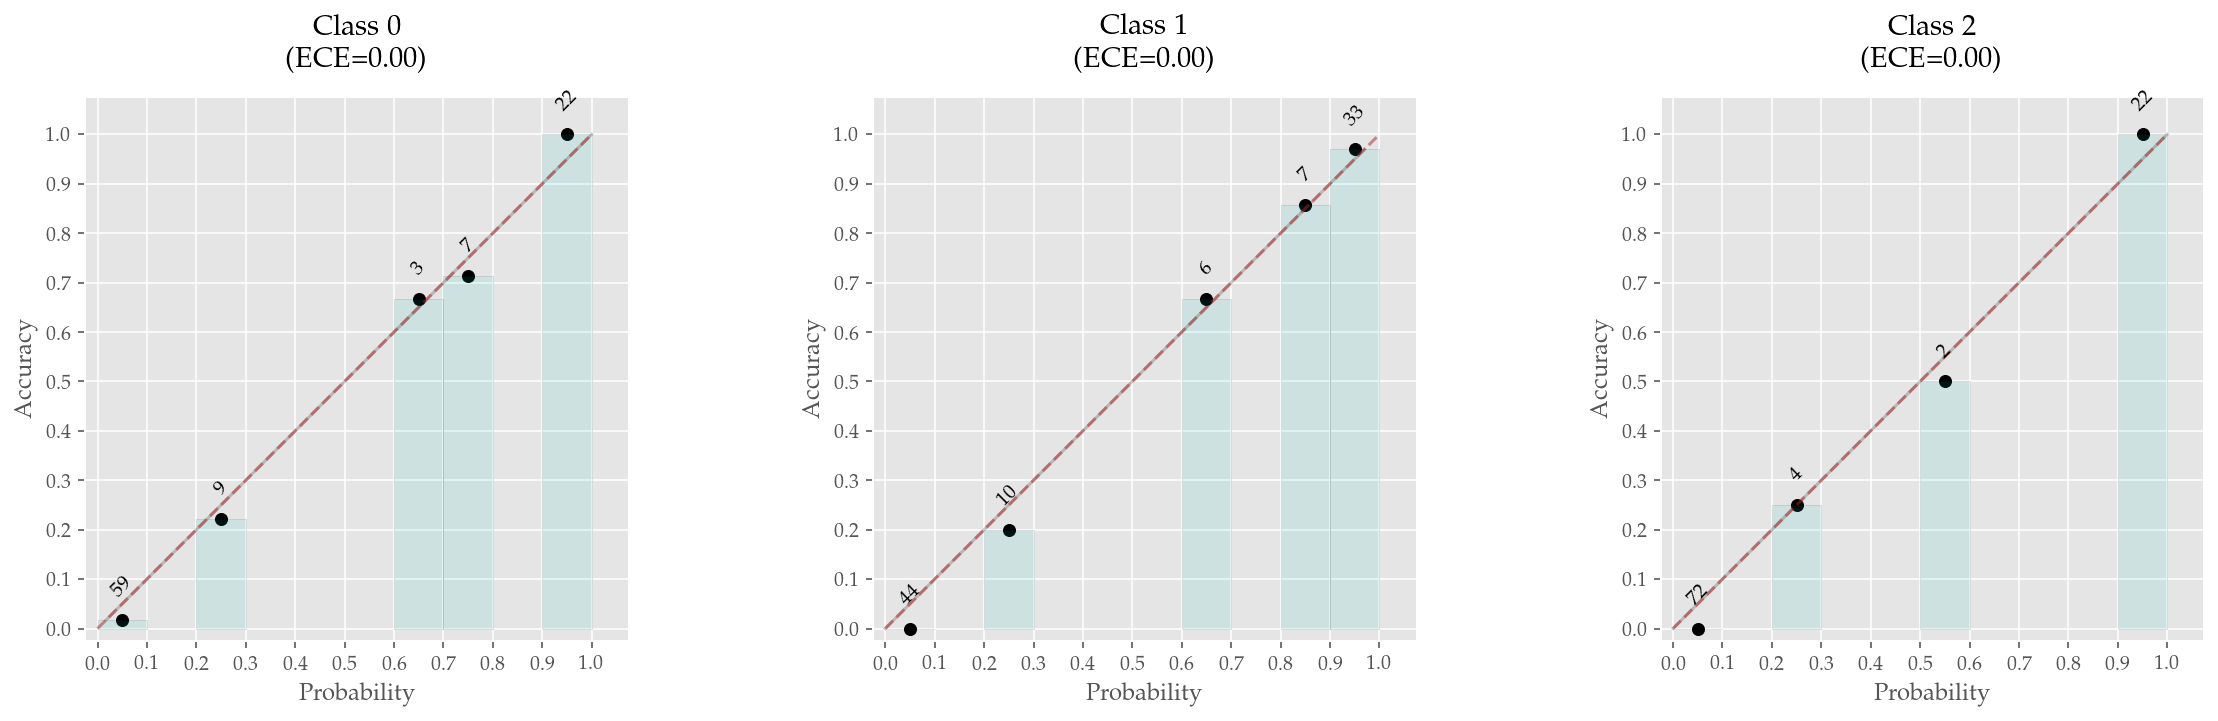

Calibrated Training (normalized) - Accuracy = 0.93


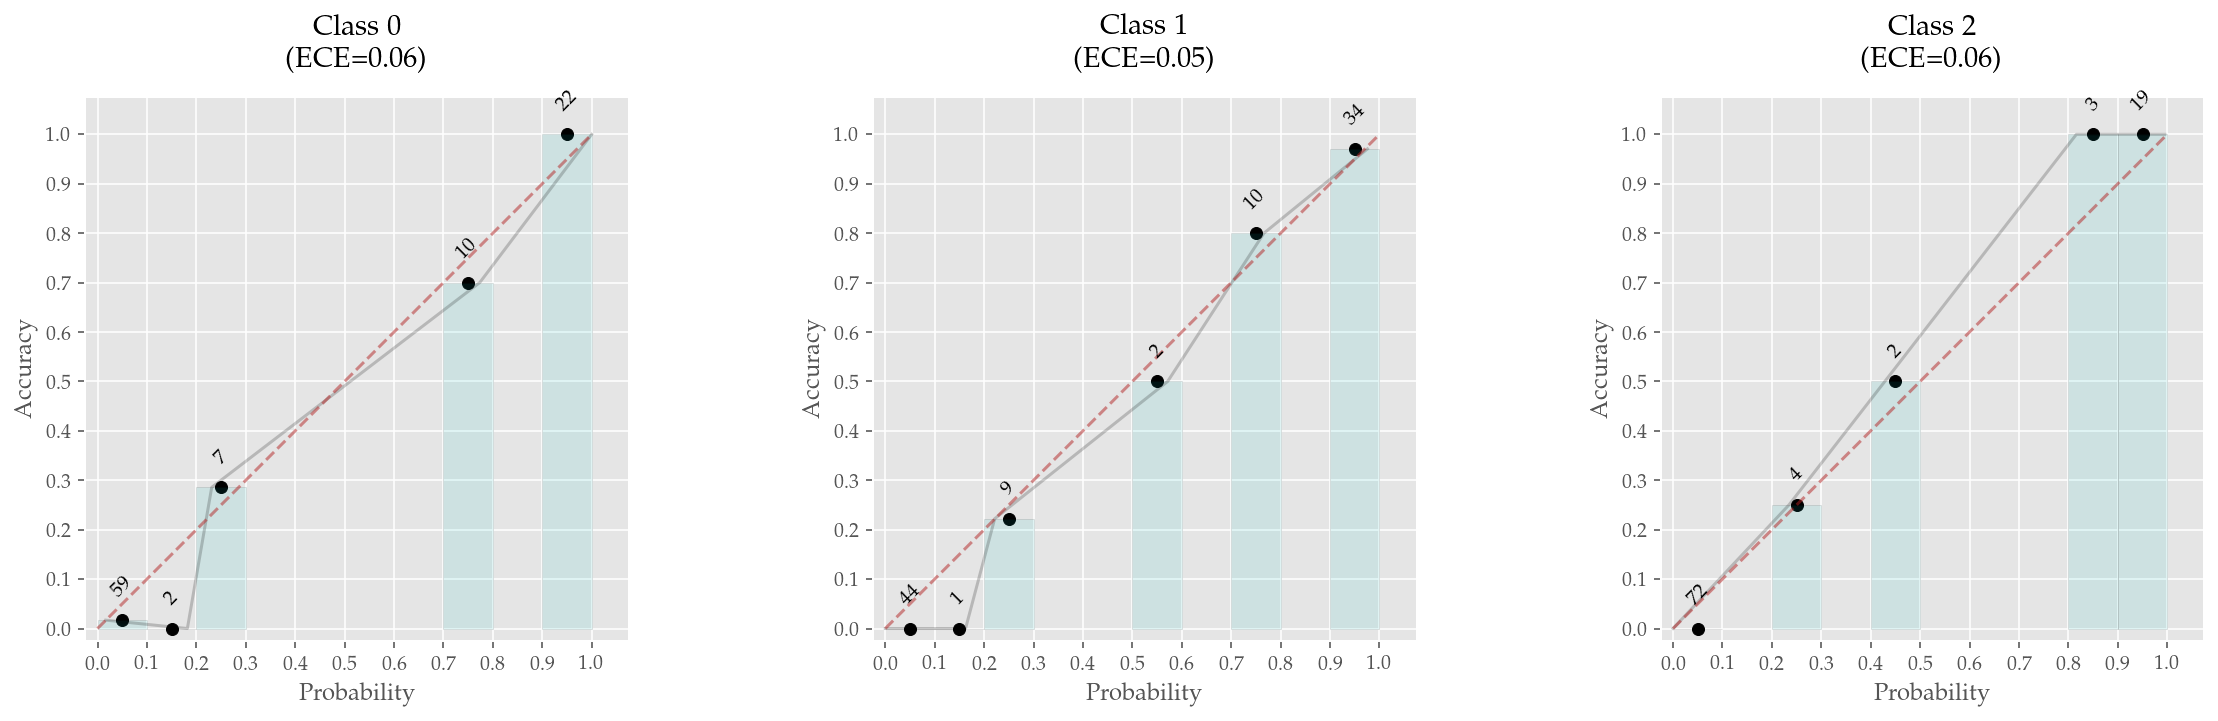

Original Val - Accuracy = 0.92


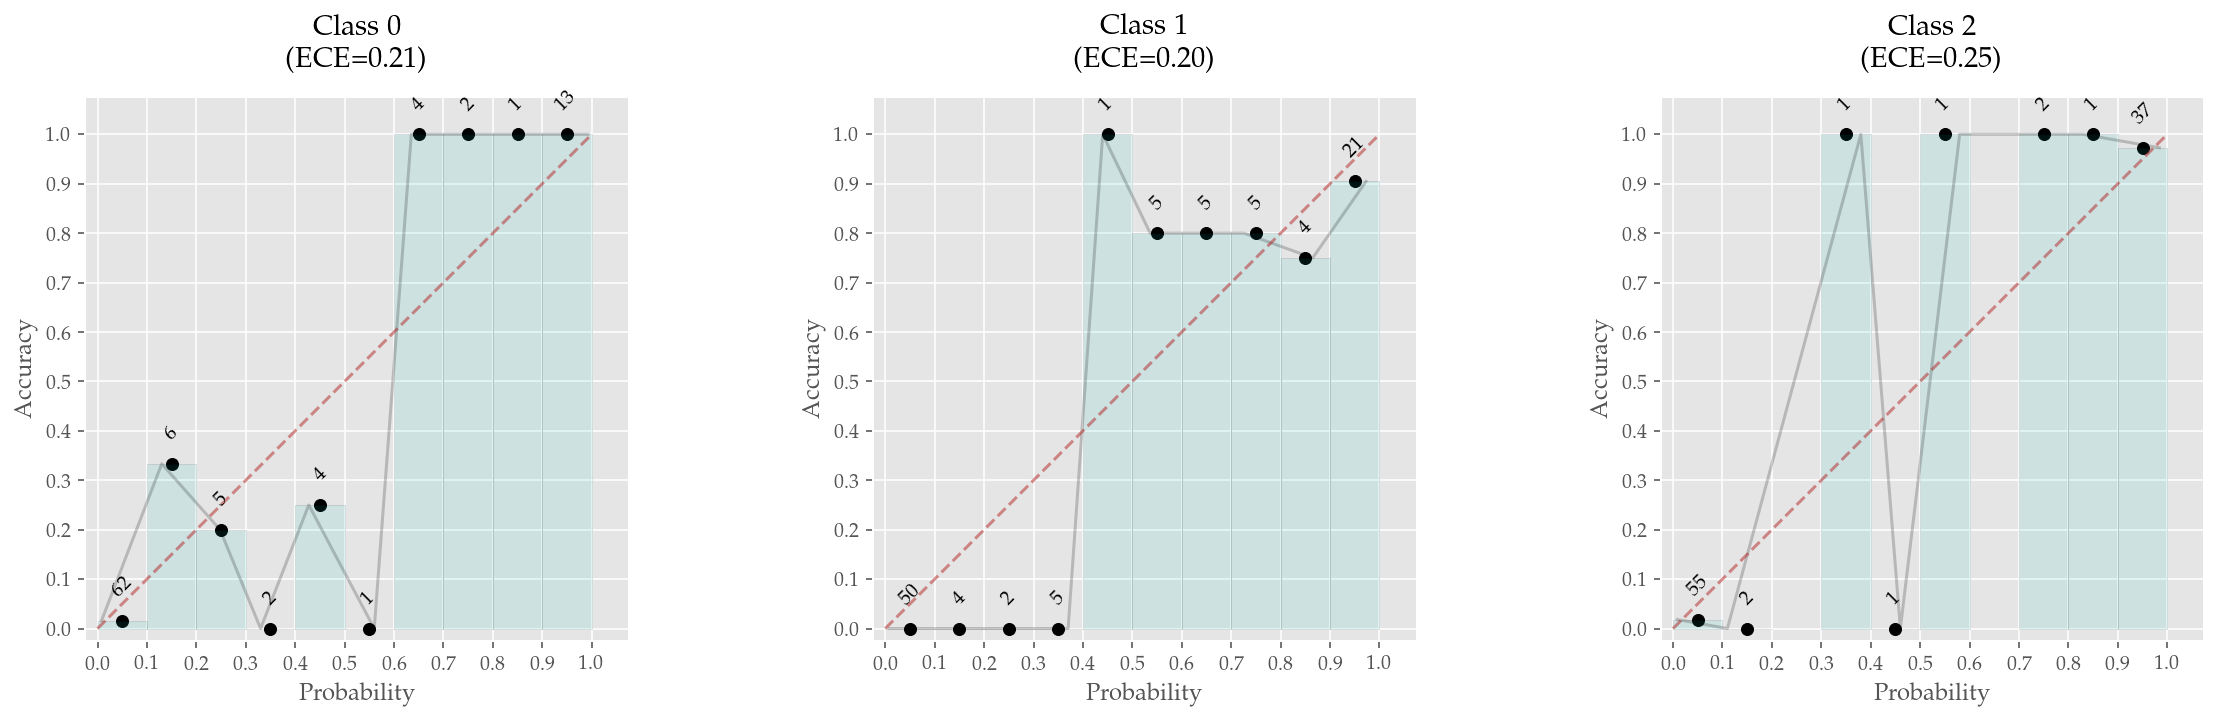

Calibrated Val (unormalized)


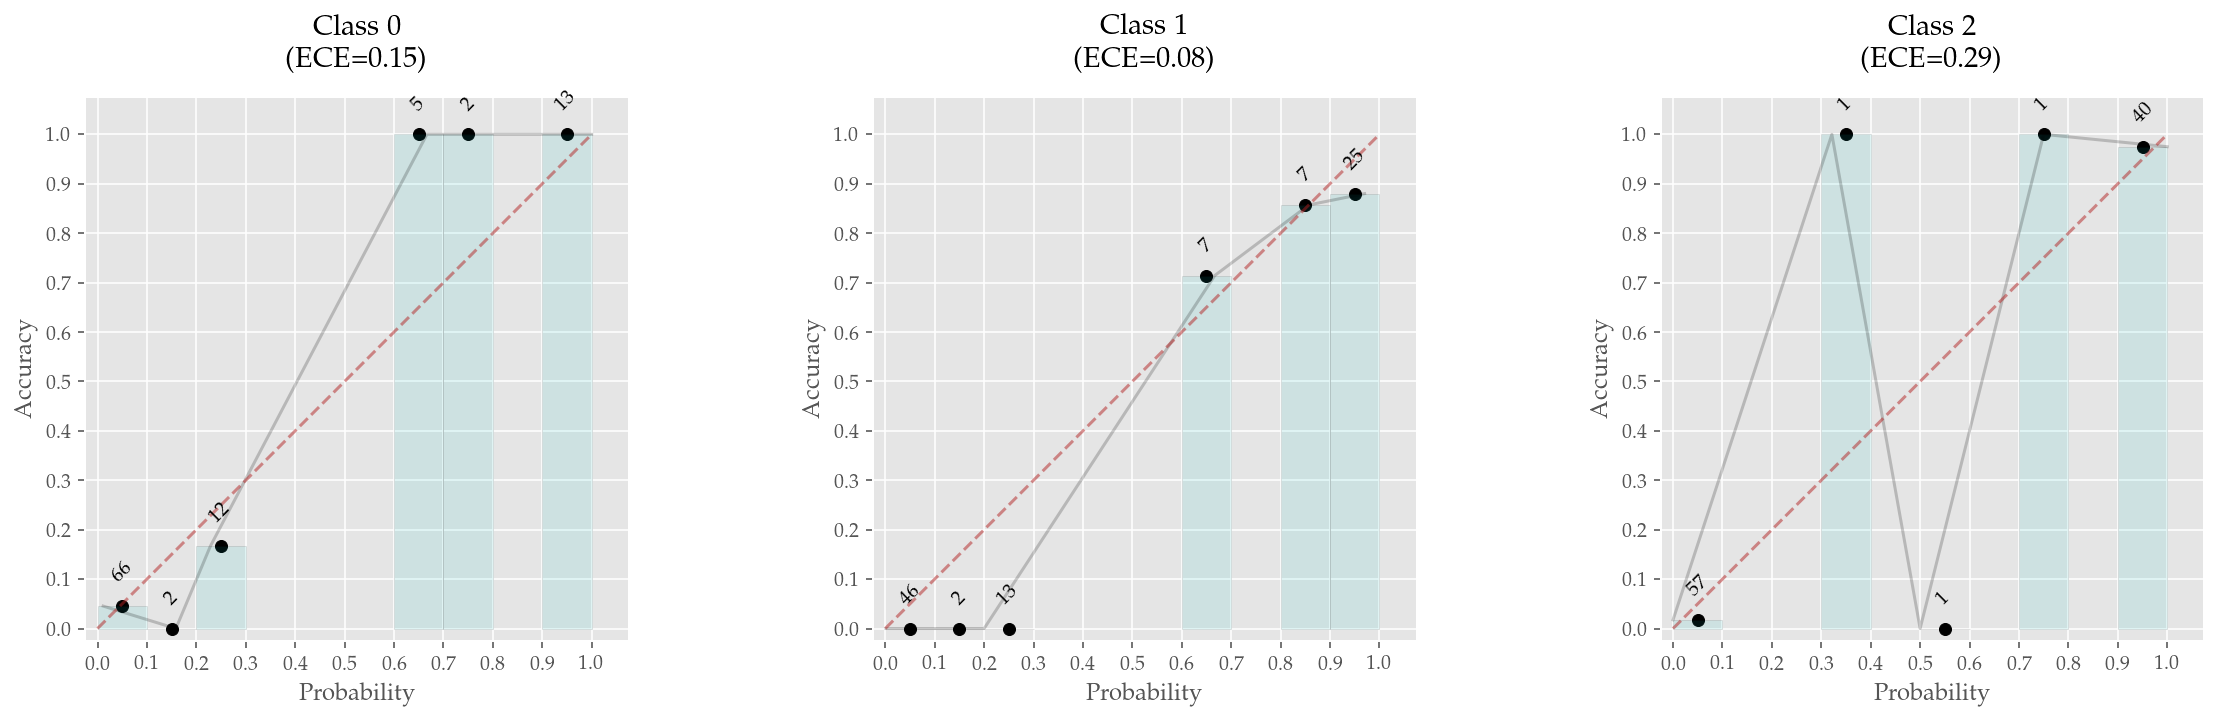

Calibrated Val (normalized) - Accuracy = 0.93


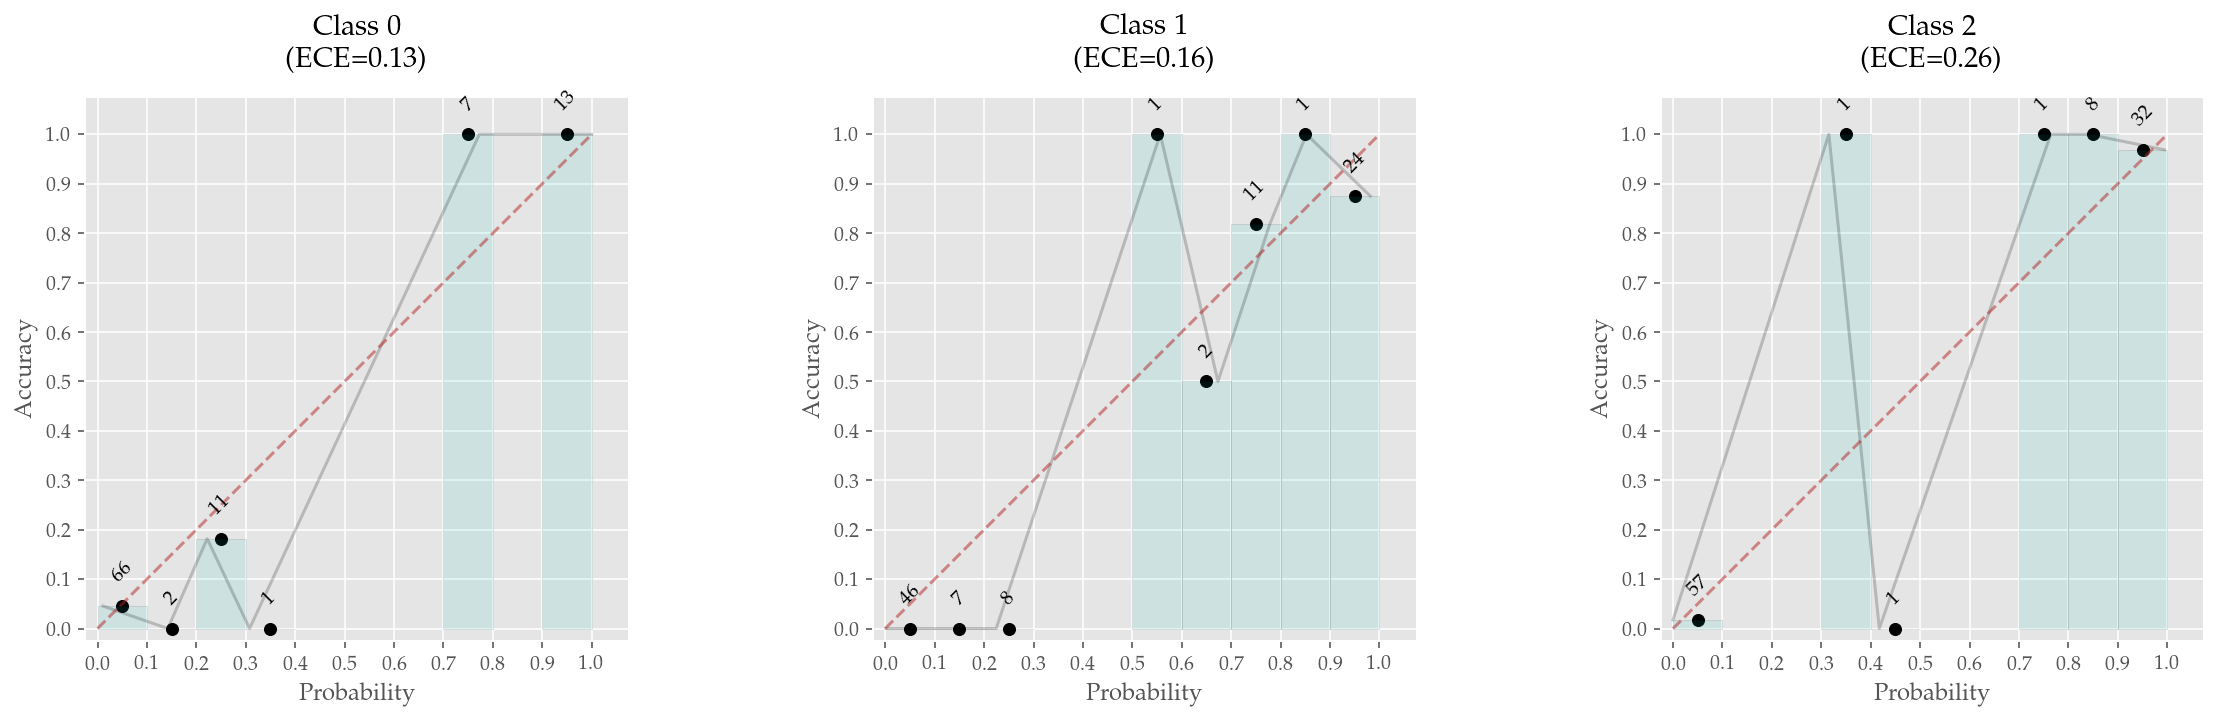

In [9]:
isotonic = cal.IsotonicCalibration()
isotonic.fit(probs_train, classes_train)
plot_calibration_grid(probs_train, classes_train, isotonic, classes_val)

# Platt

Original Training - Accuracy = 0.91


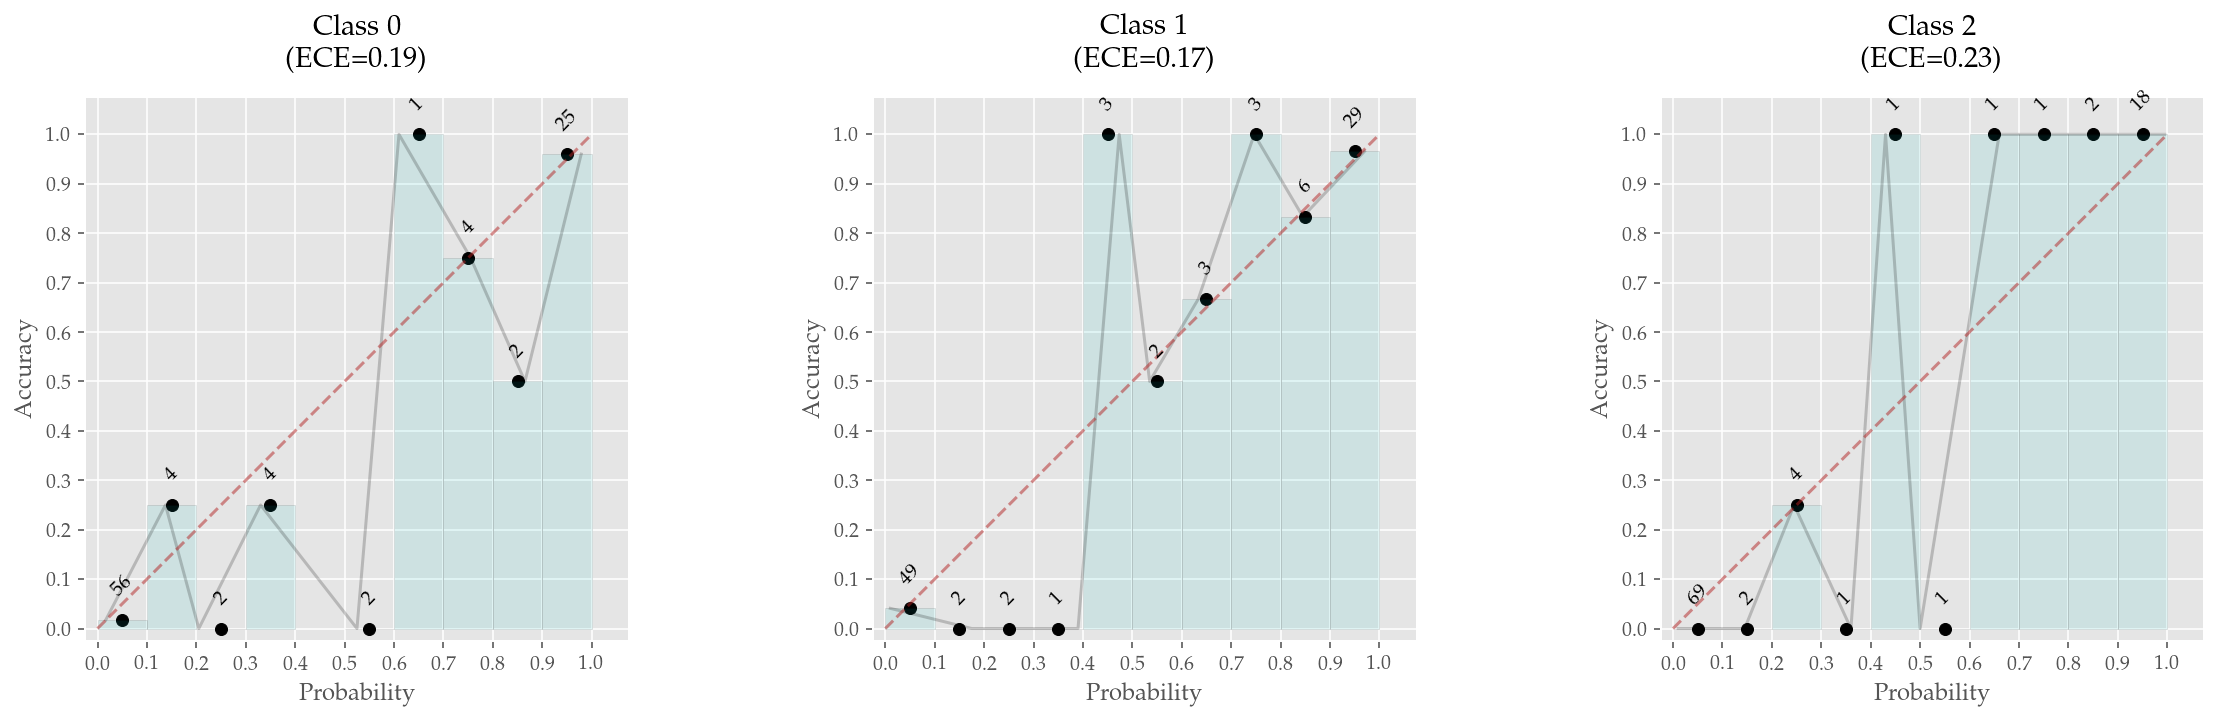

Calibrated Training (unormalized)


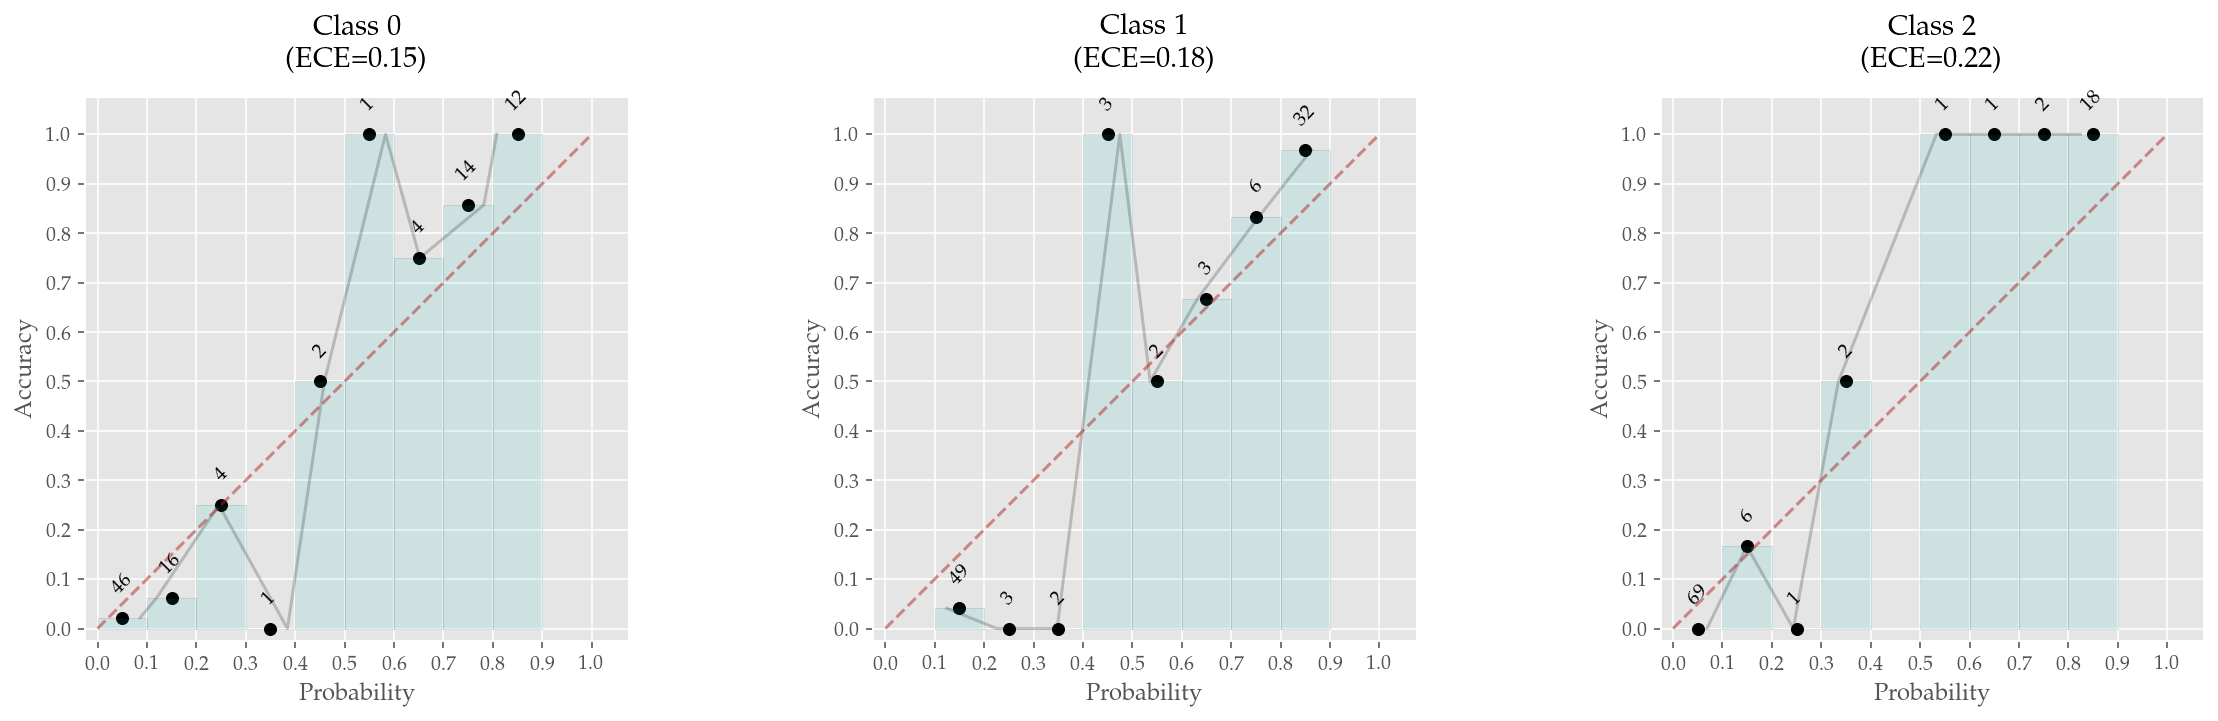

Calibrated Training (normalized) - Accuracy = 0.93


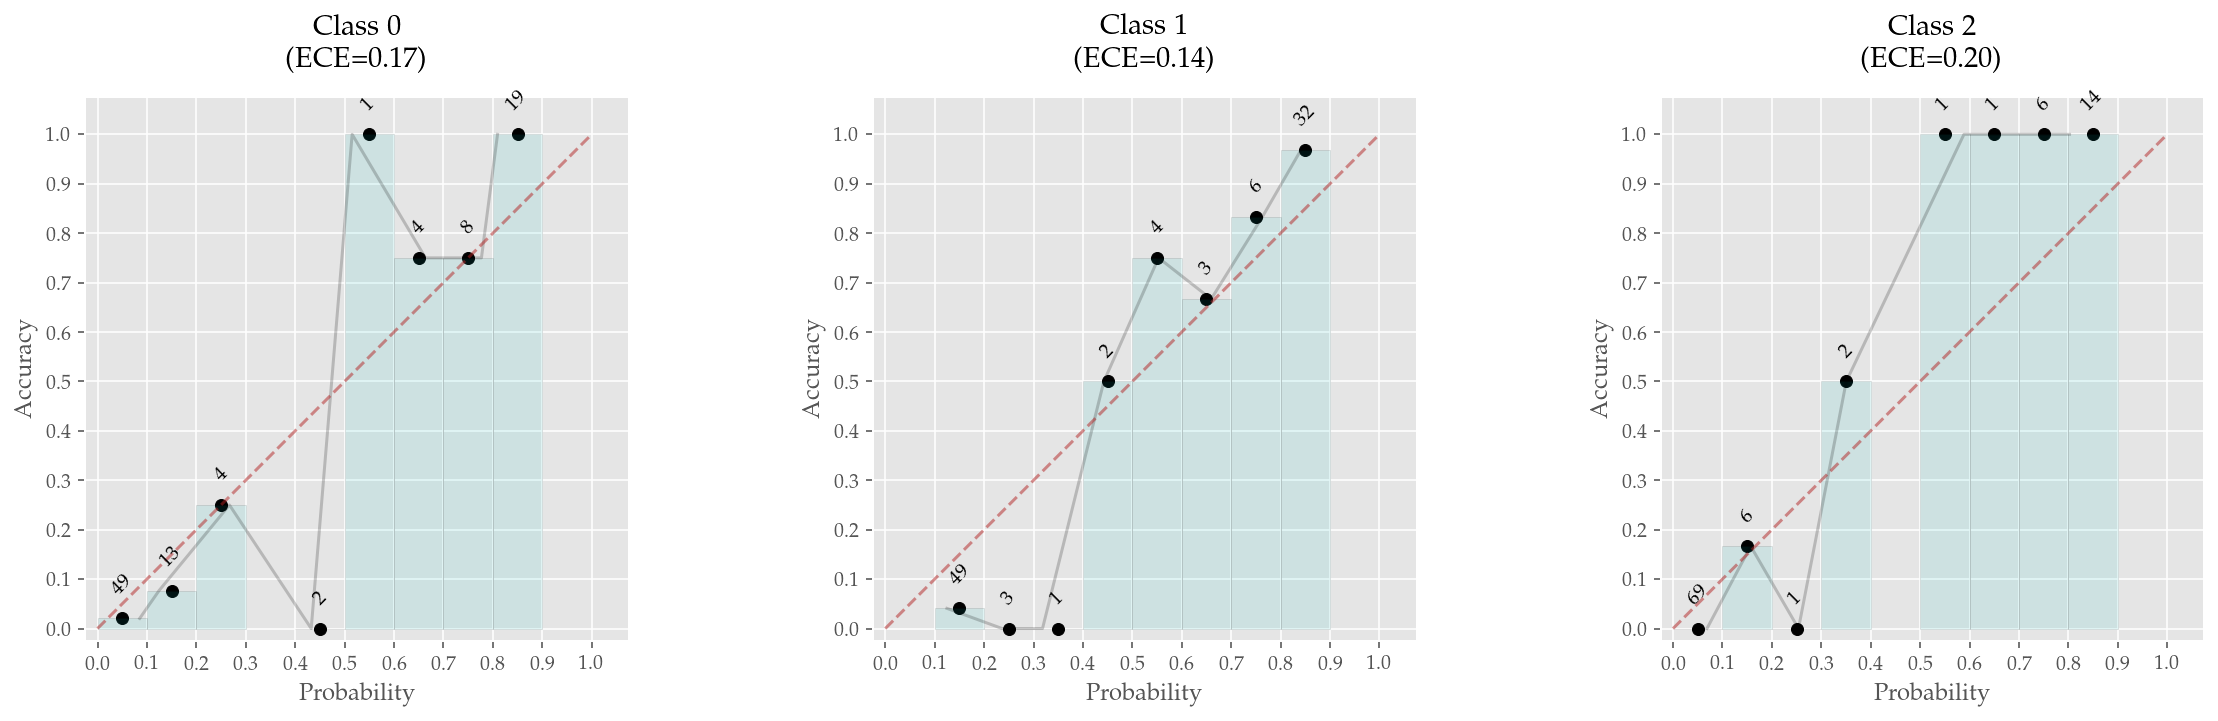

Original Val - Accuracy = 0.92


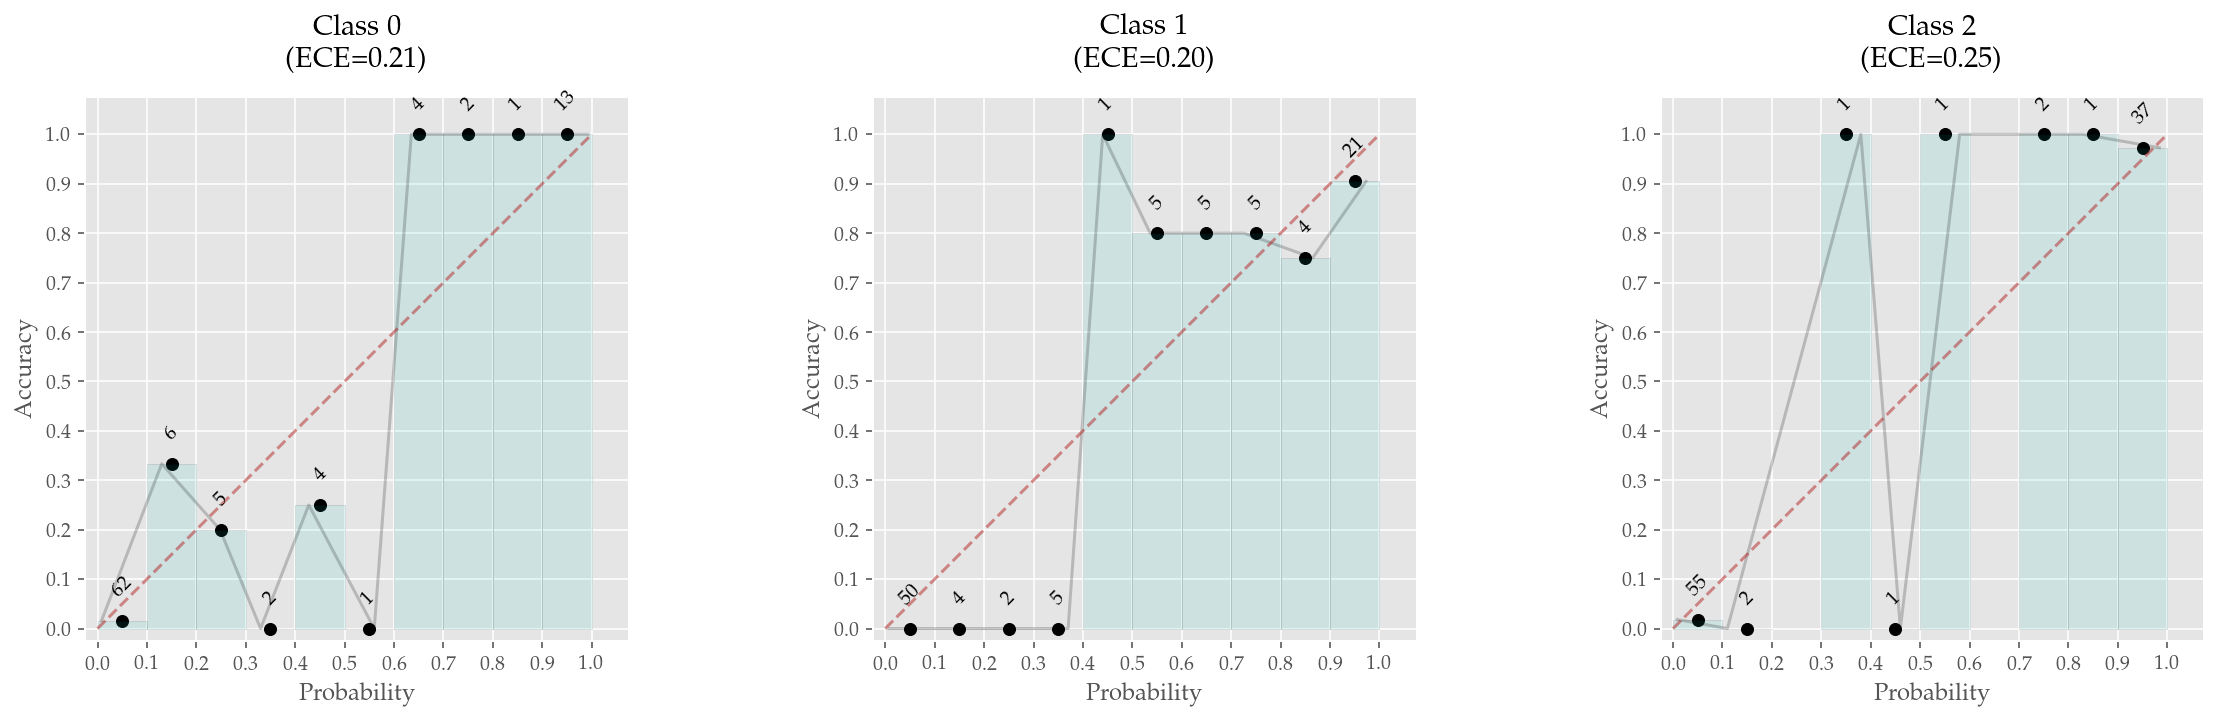

Calibrated Val (unormalized)


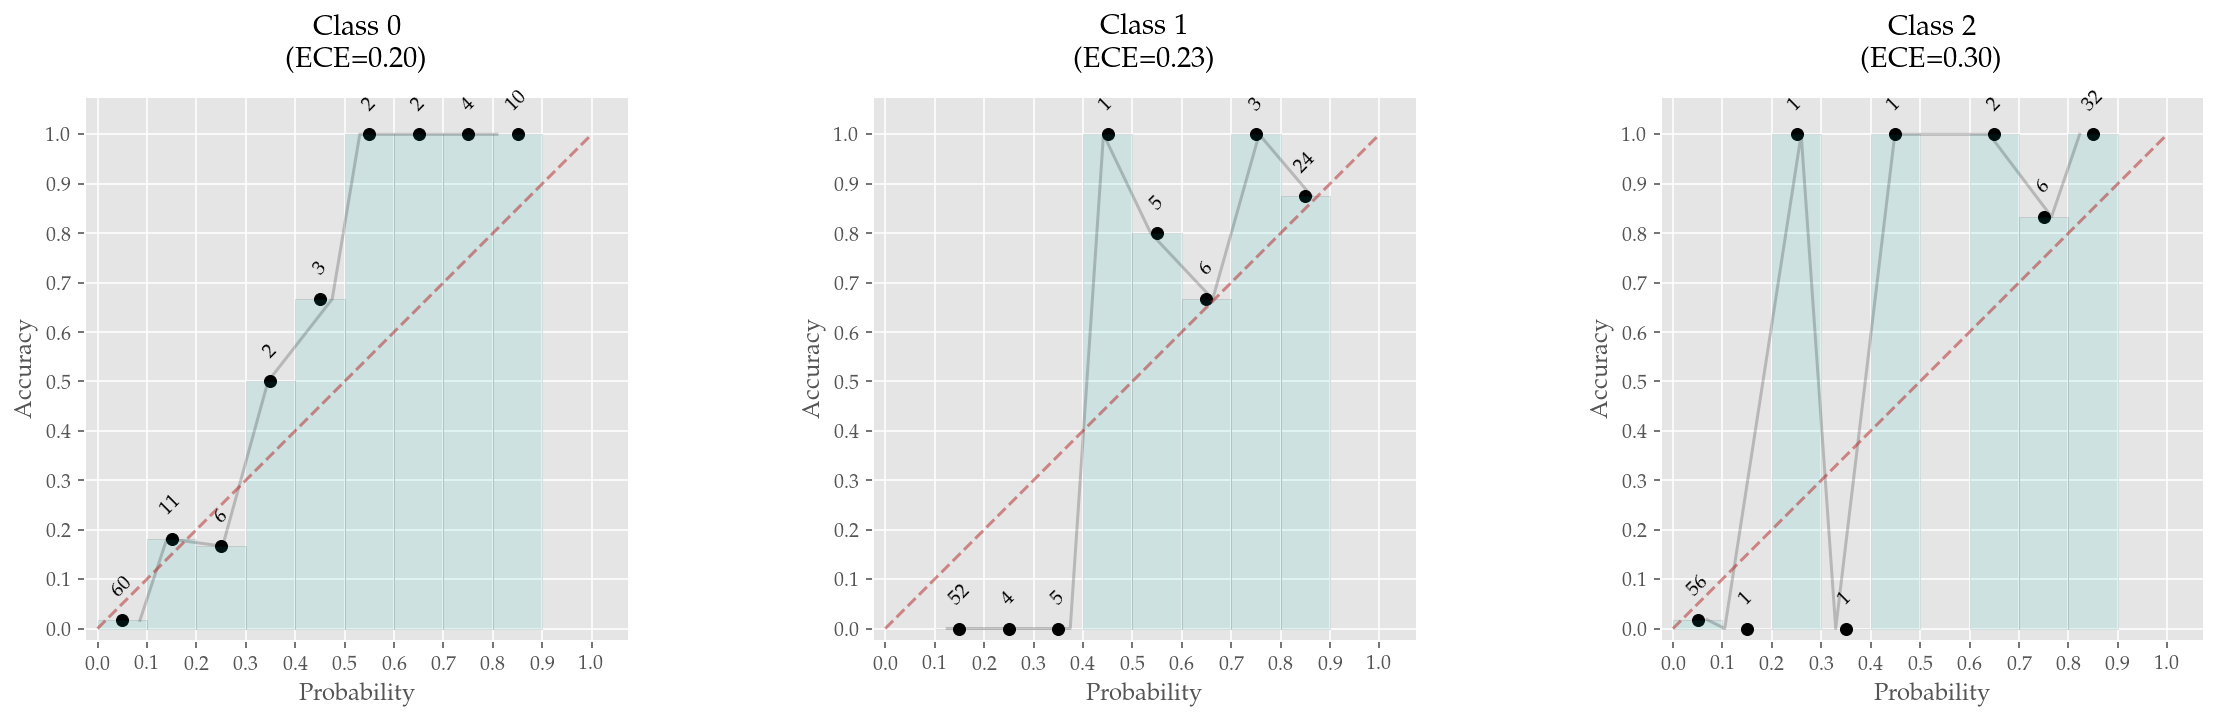

Calibrated Val (normalized) - Accuracy = 0.93


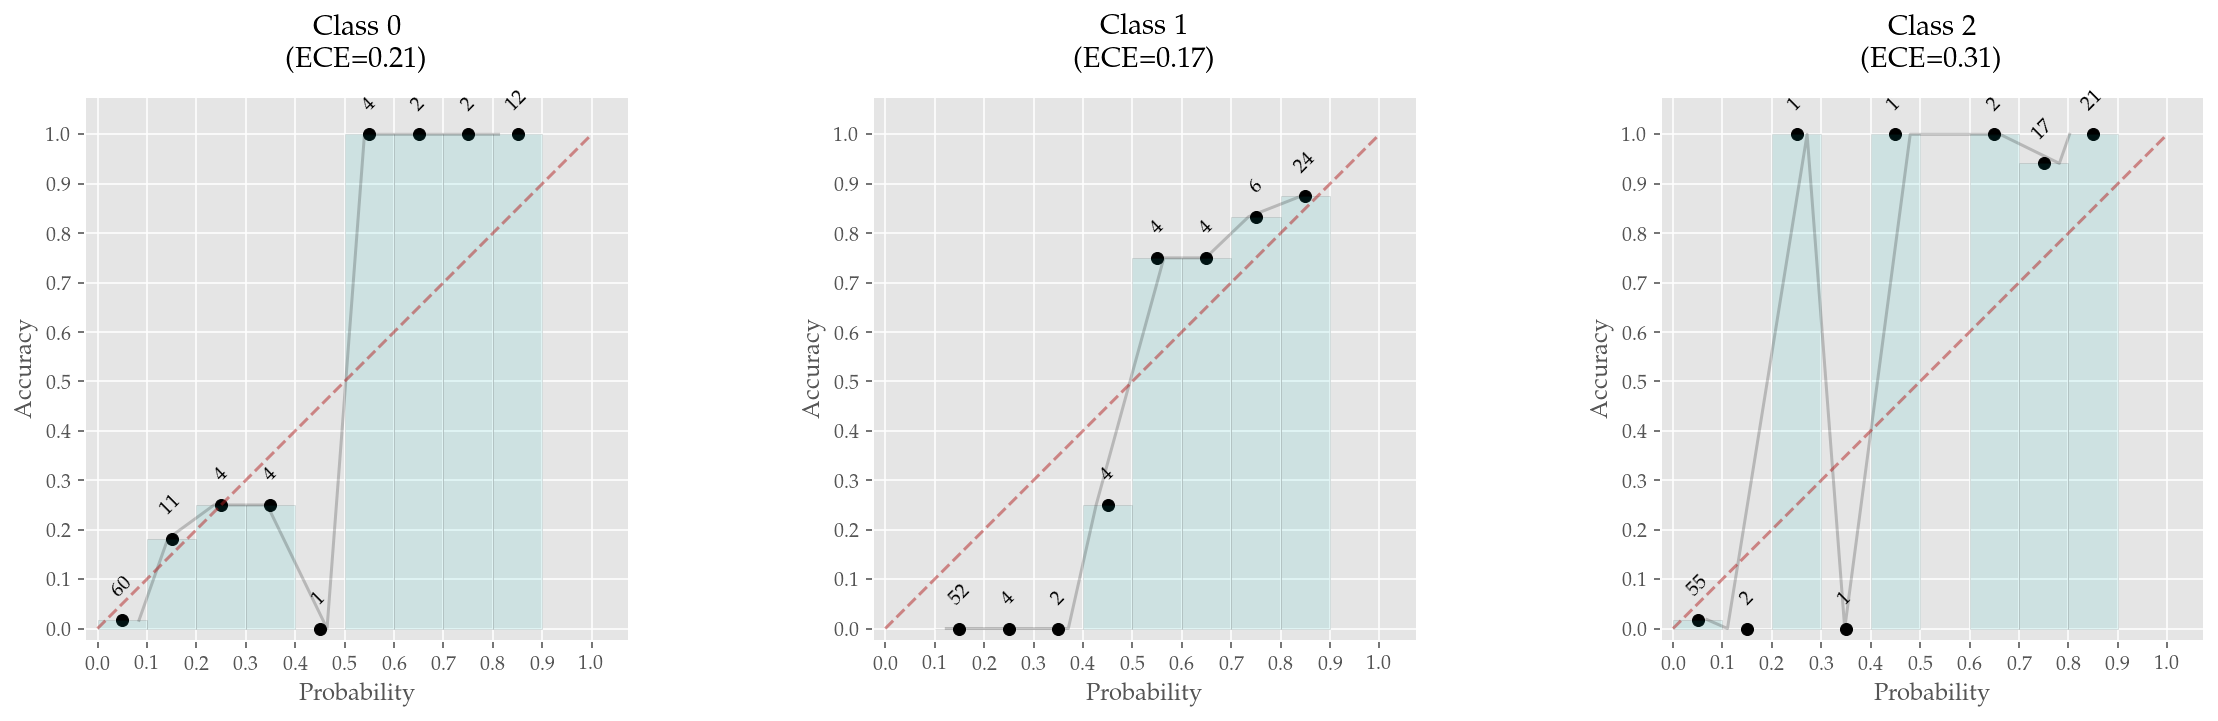

In [10]:
platt = cal.PlattCalibration()
platt.fit(probs_train, classes_train)
plot_calibration_grid(probs_train, classes_train, platt, classes_val)

# Beta

Original Training - Accuracy = 0.91


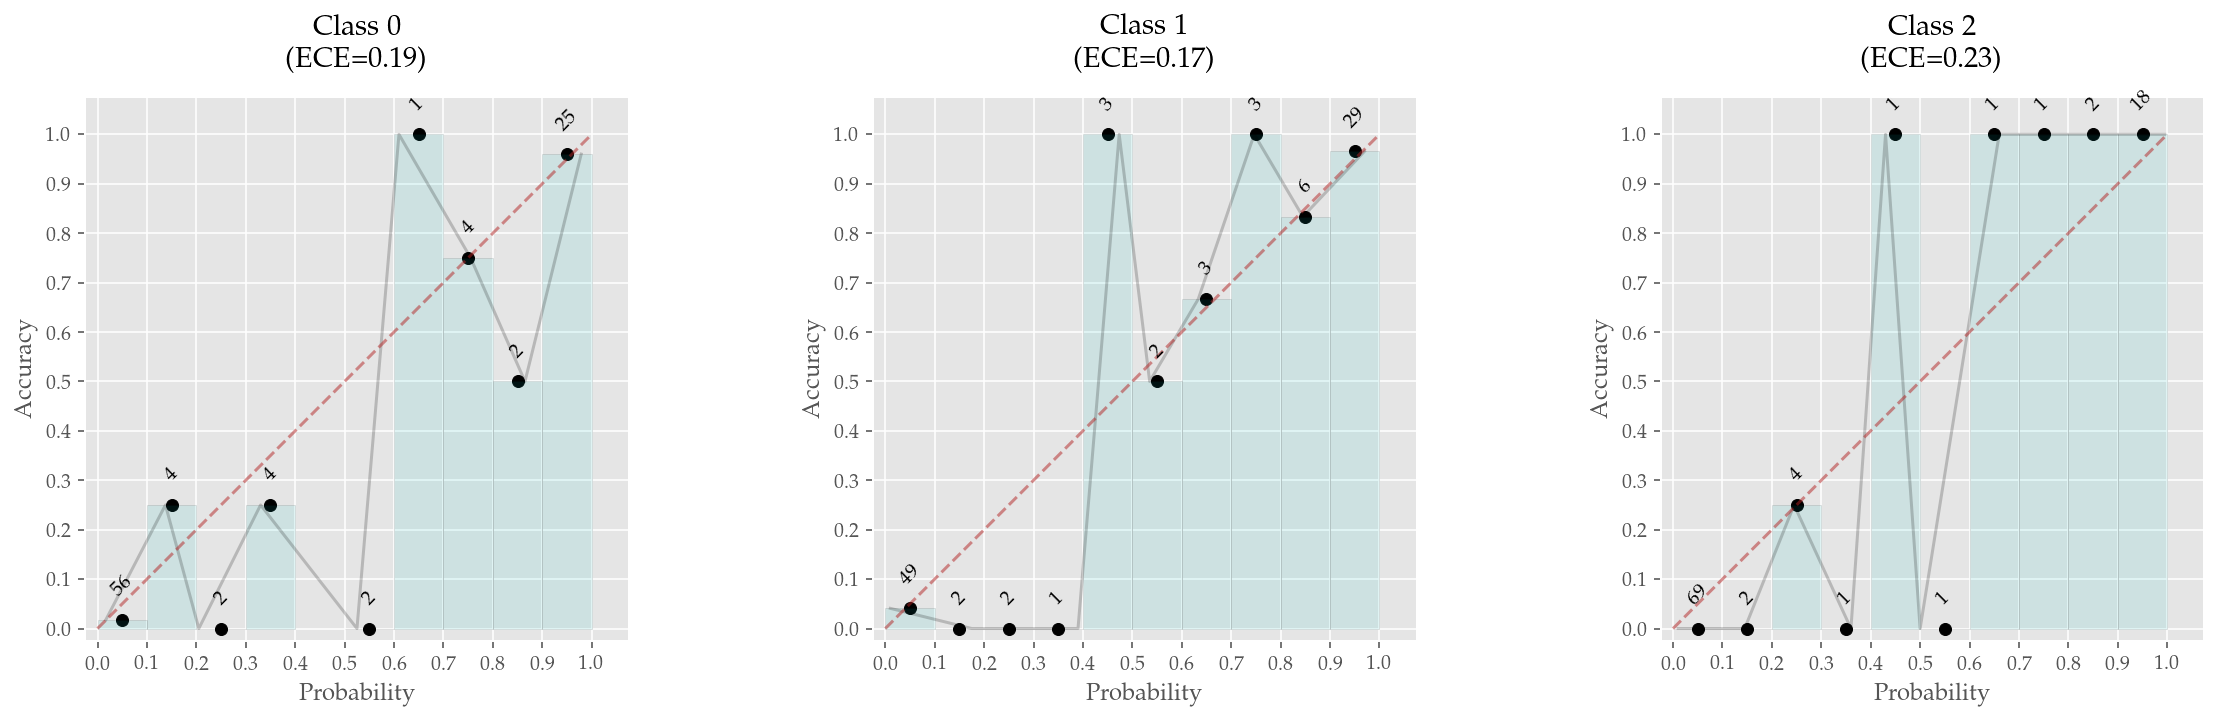

Calibrated Training (unormalized)


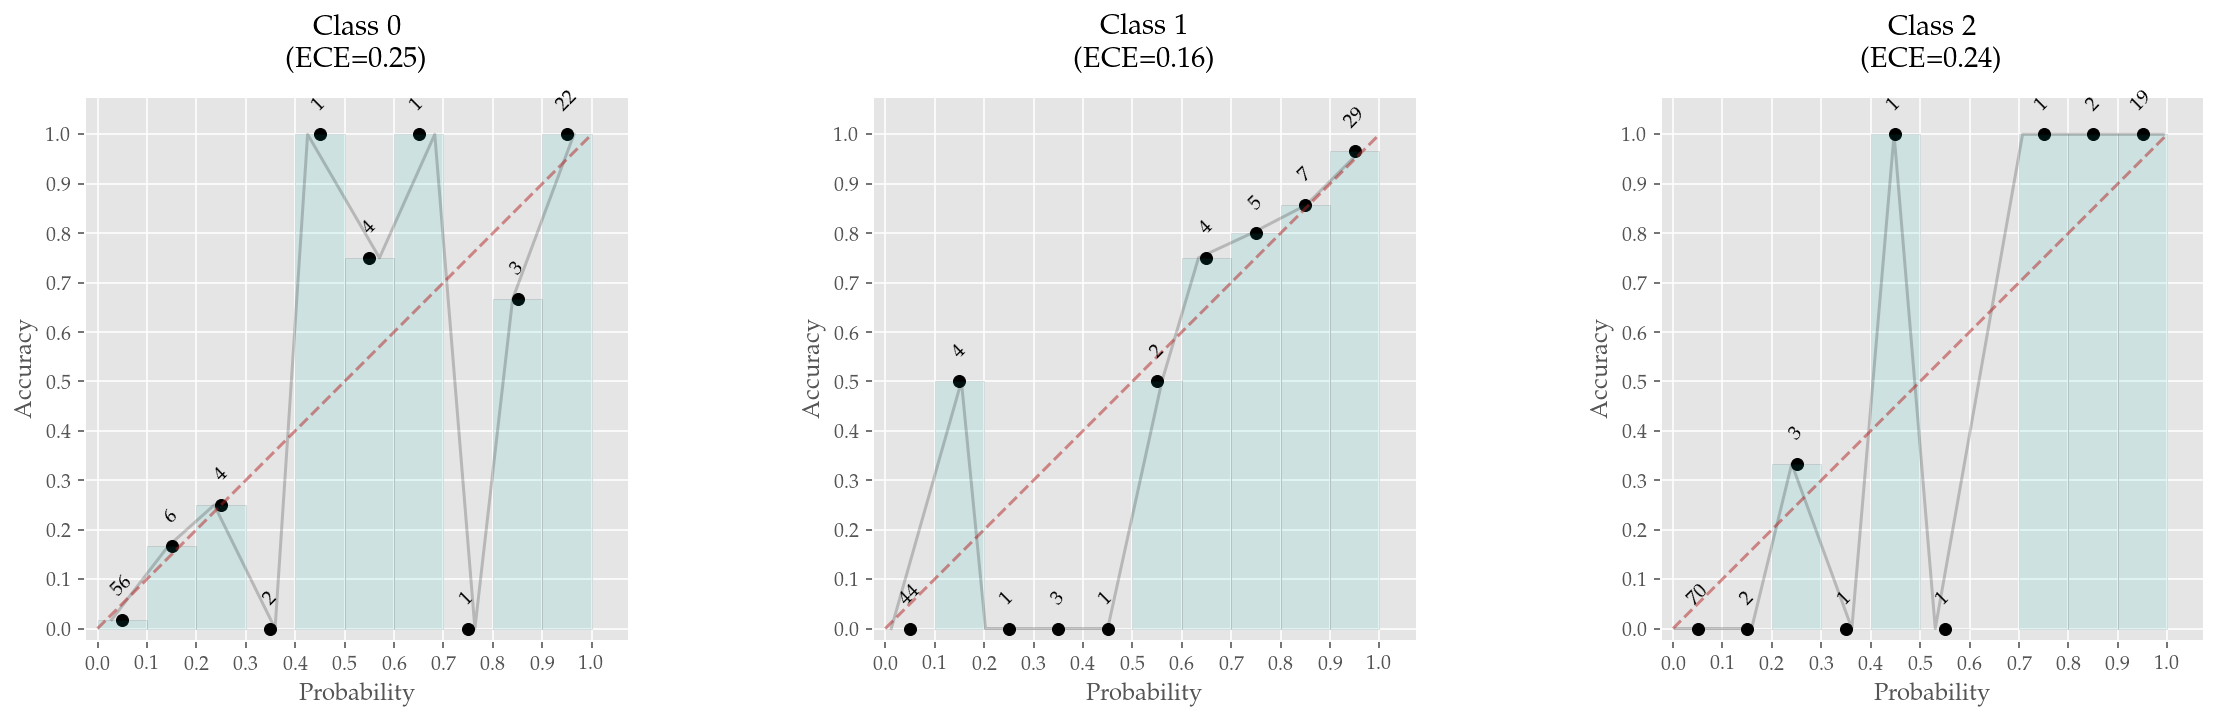

Calibrated Training (normalized) - Accuracy = 0.92


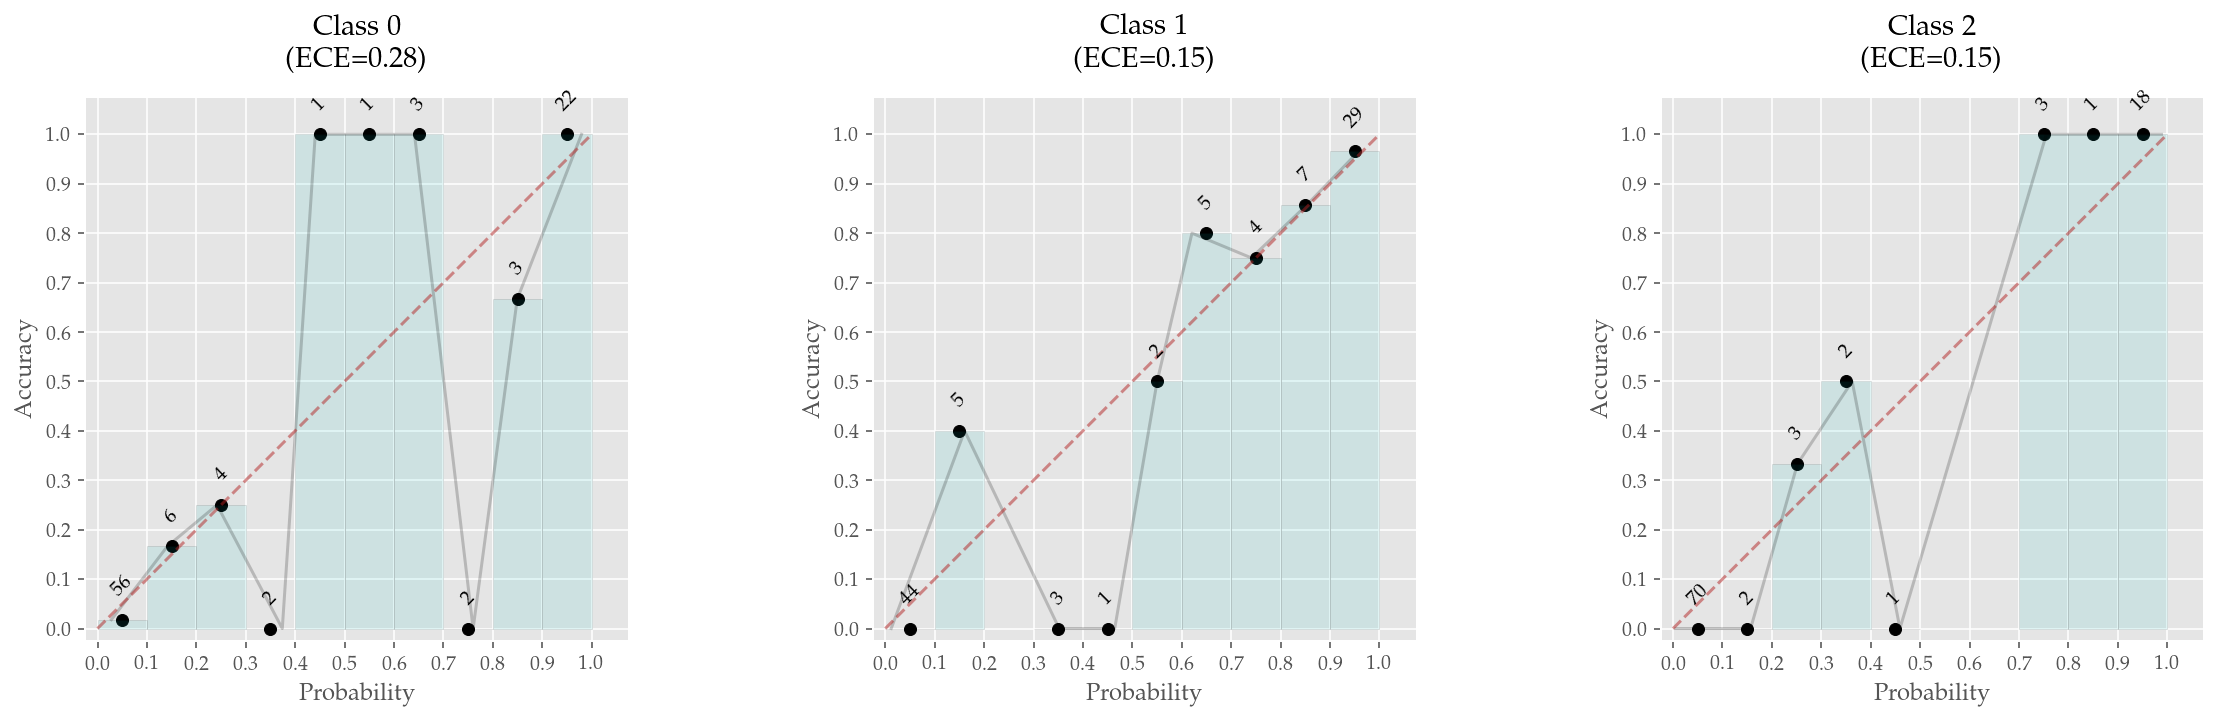

Original Val - Accuracy = 0.92


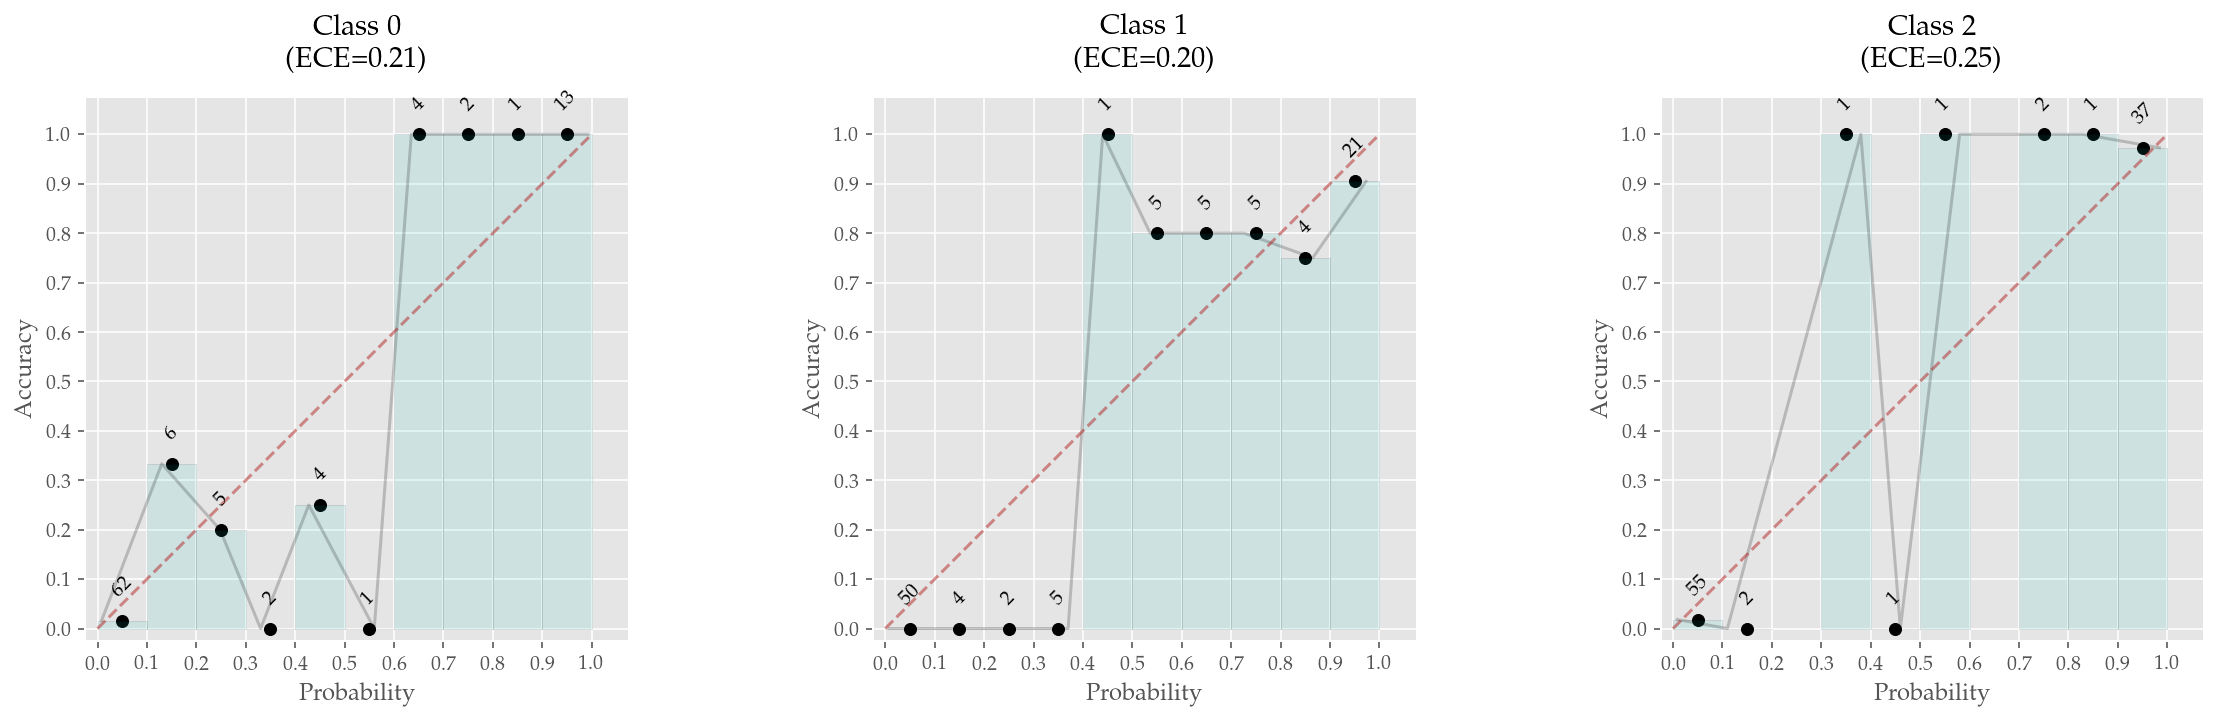

Calibrated Val (unormalized)


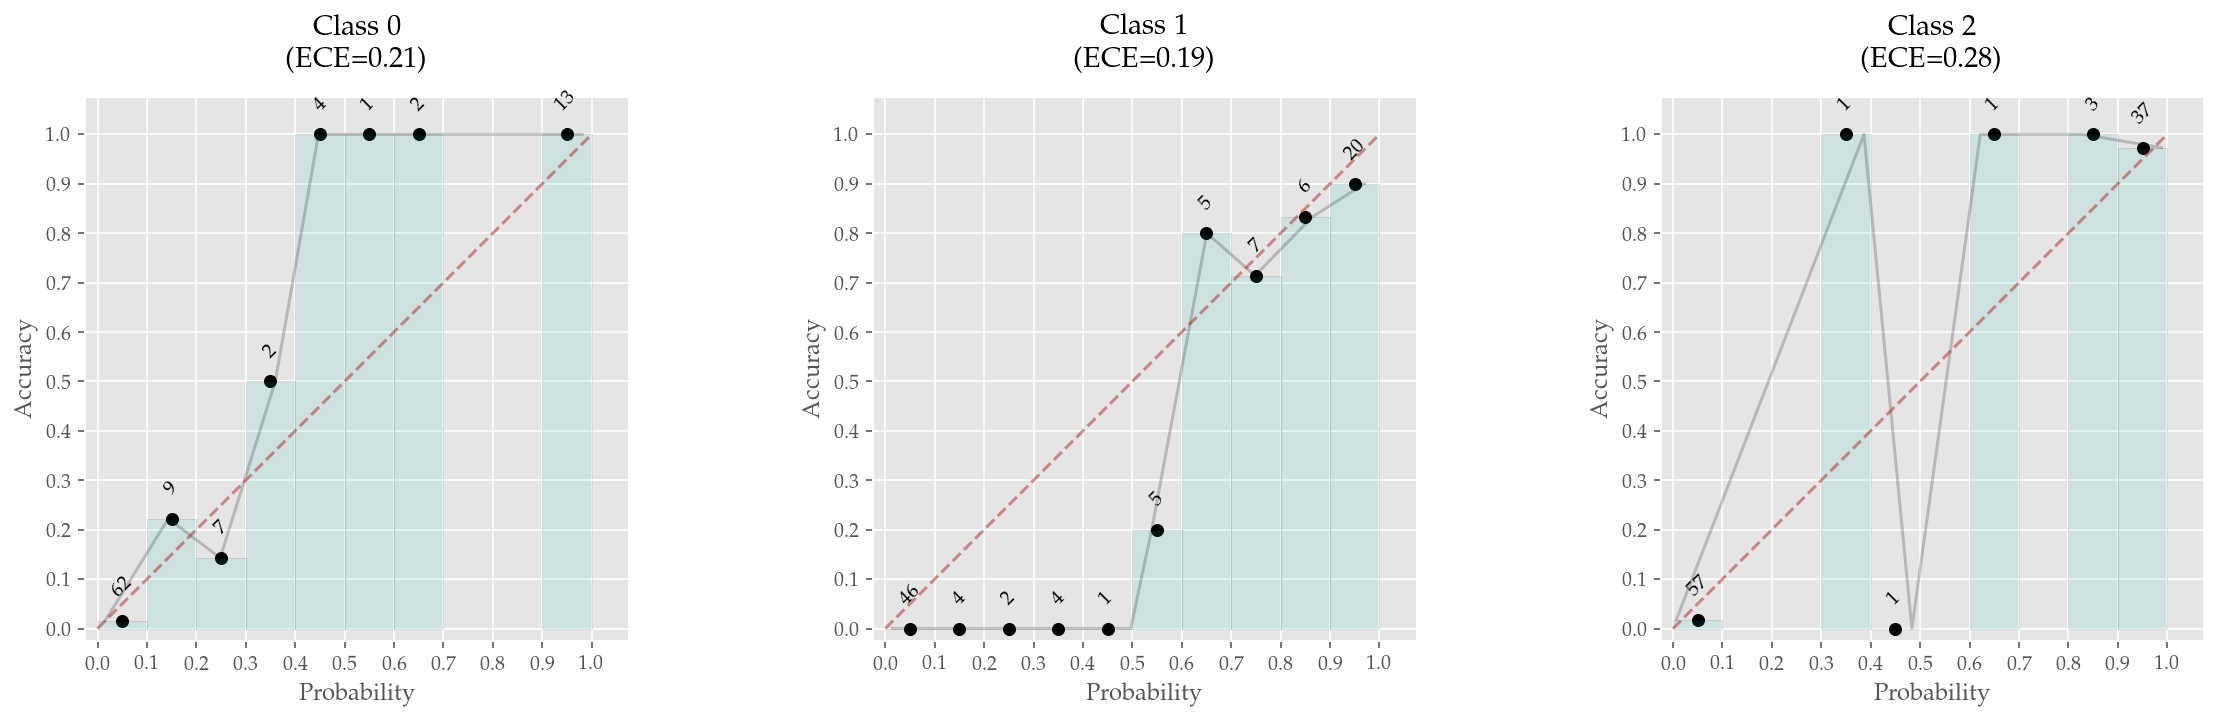

Calibrated Val (normalized) - Accuracy = 0.89


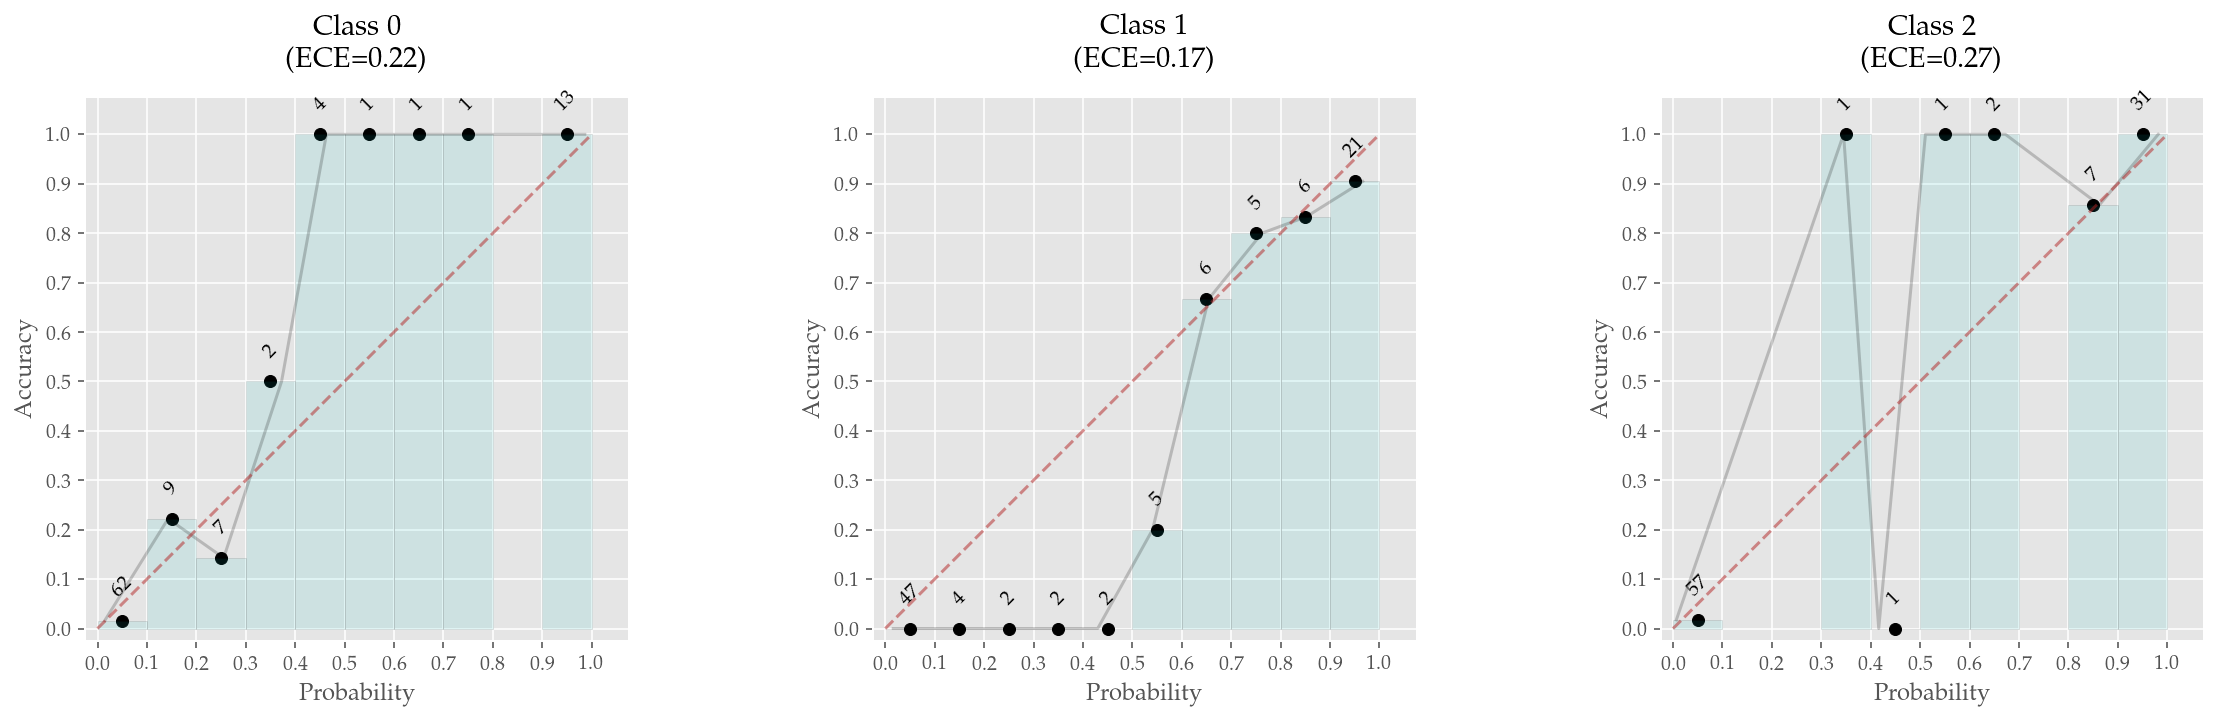

In [11]:
beta = cal.BetaCalibration()
beta.fit(probs_train, classes_train)
plot_calibration_grid(probs_train, classes_train, beta, classes_val)

# Temperature Scaling

Original Training - Accuracy = 0.91


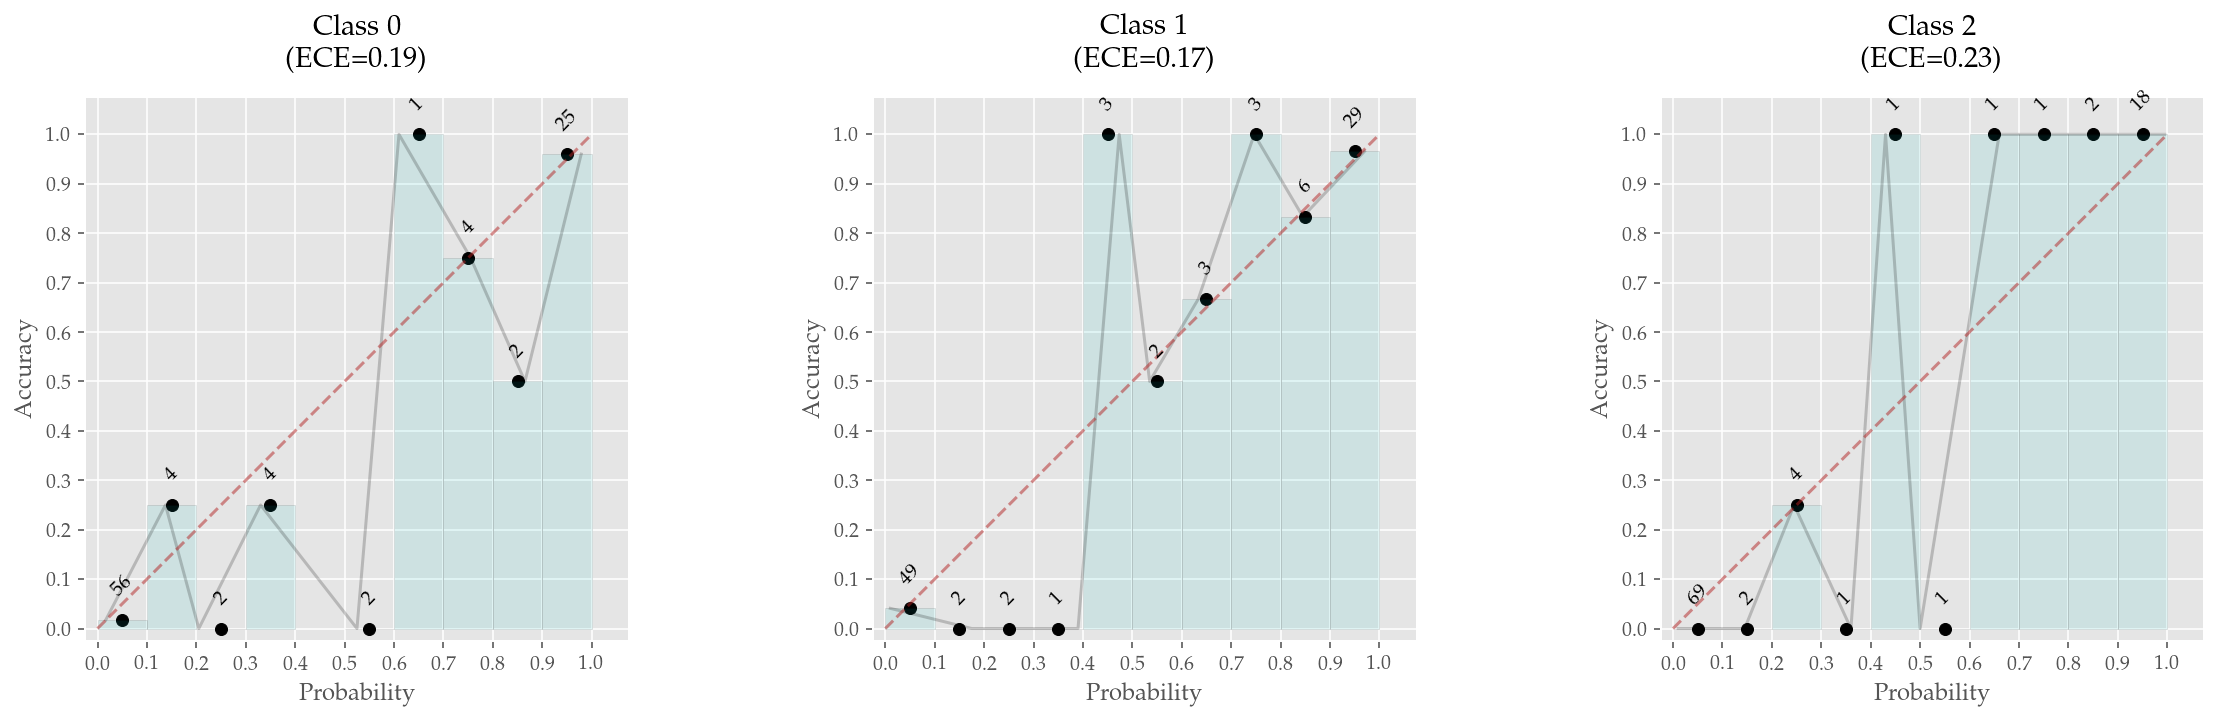

Calibrated Training (unormalized)


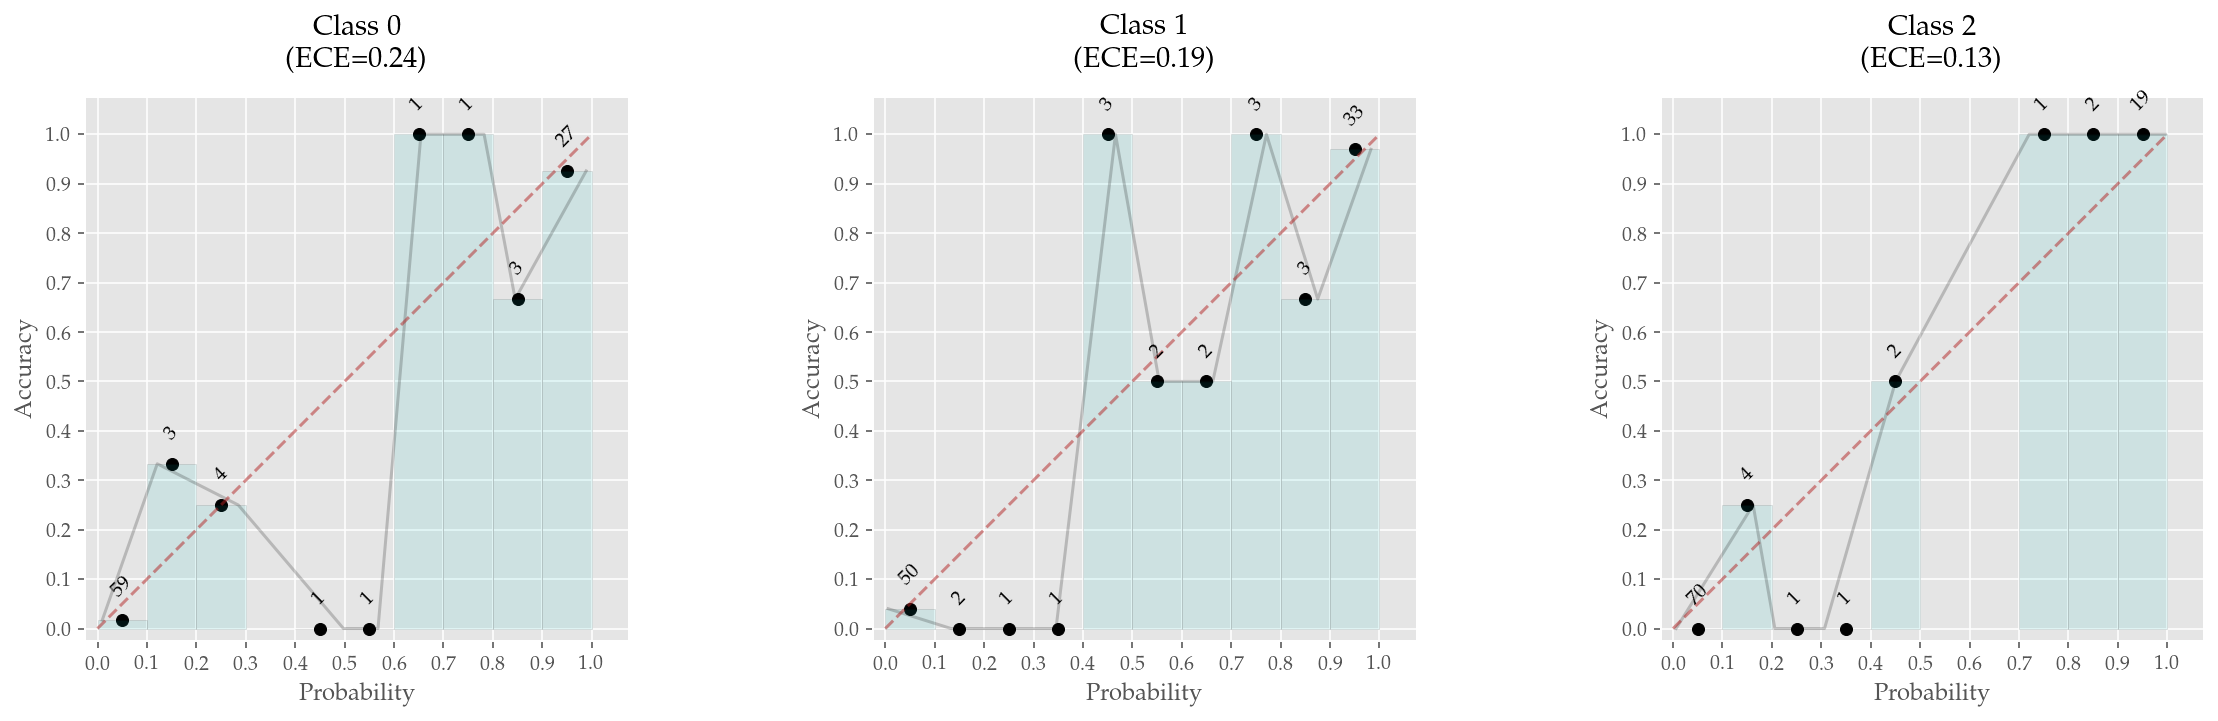

Calibrated Training (normalized) - Accuracy = 0.91


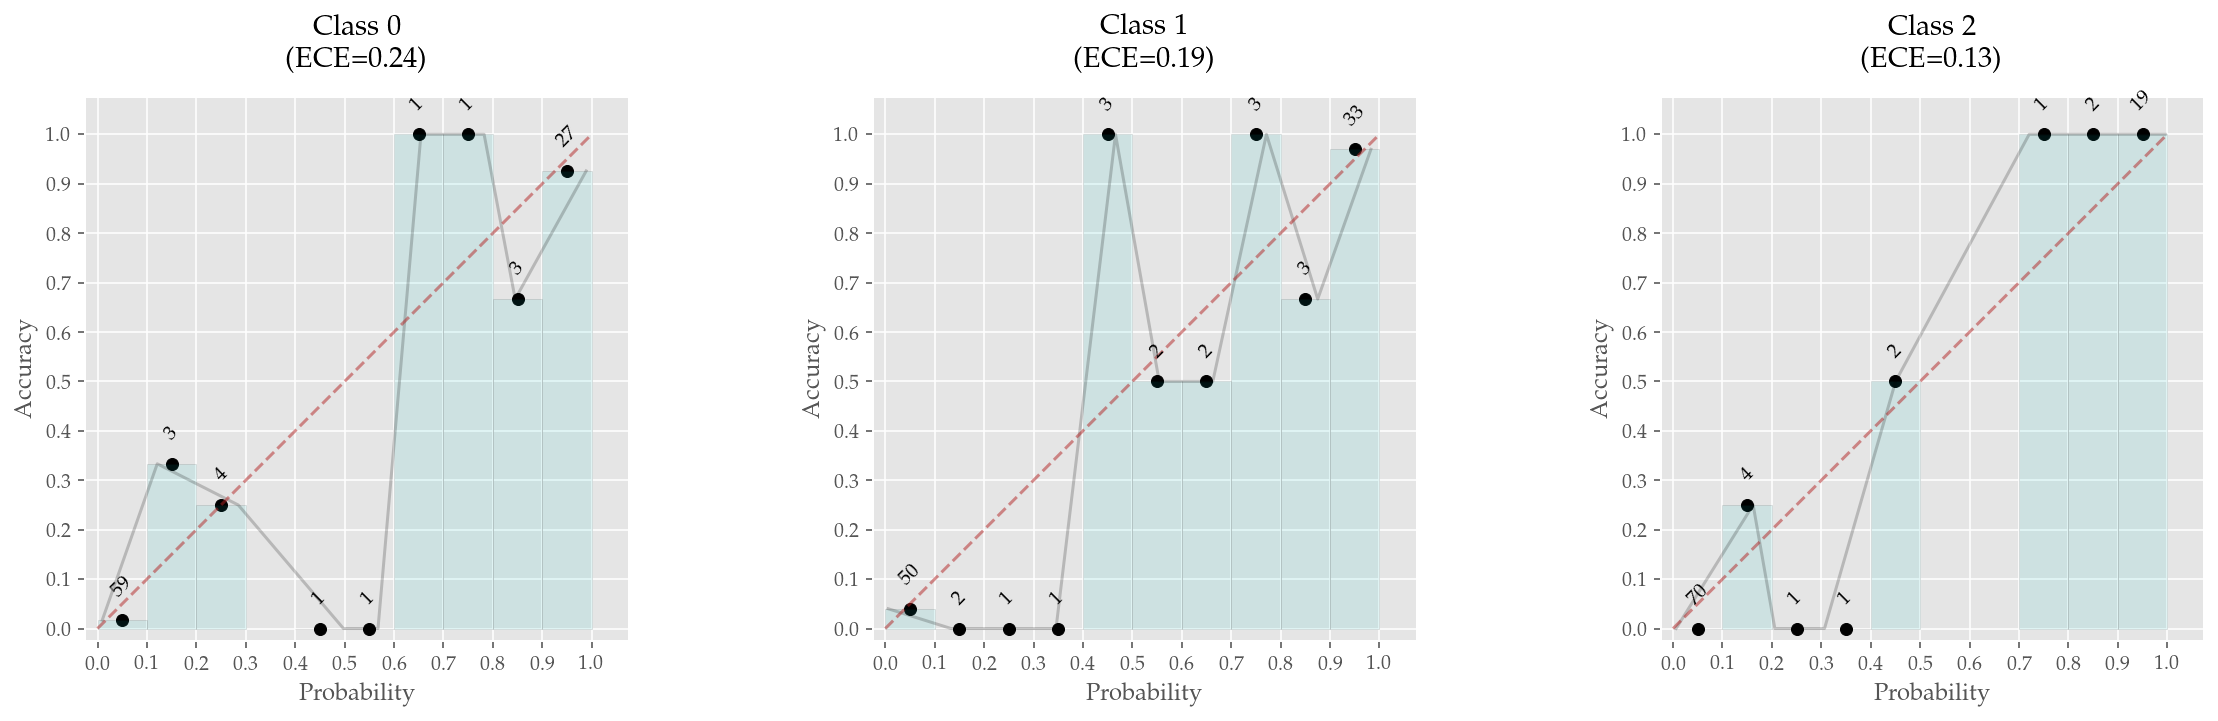

Original Val - Accuracy = 0.92


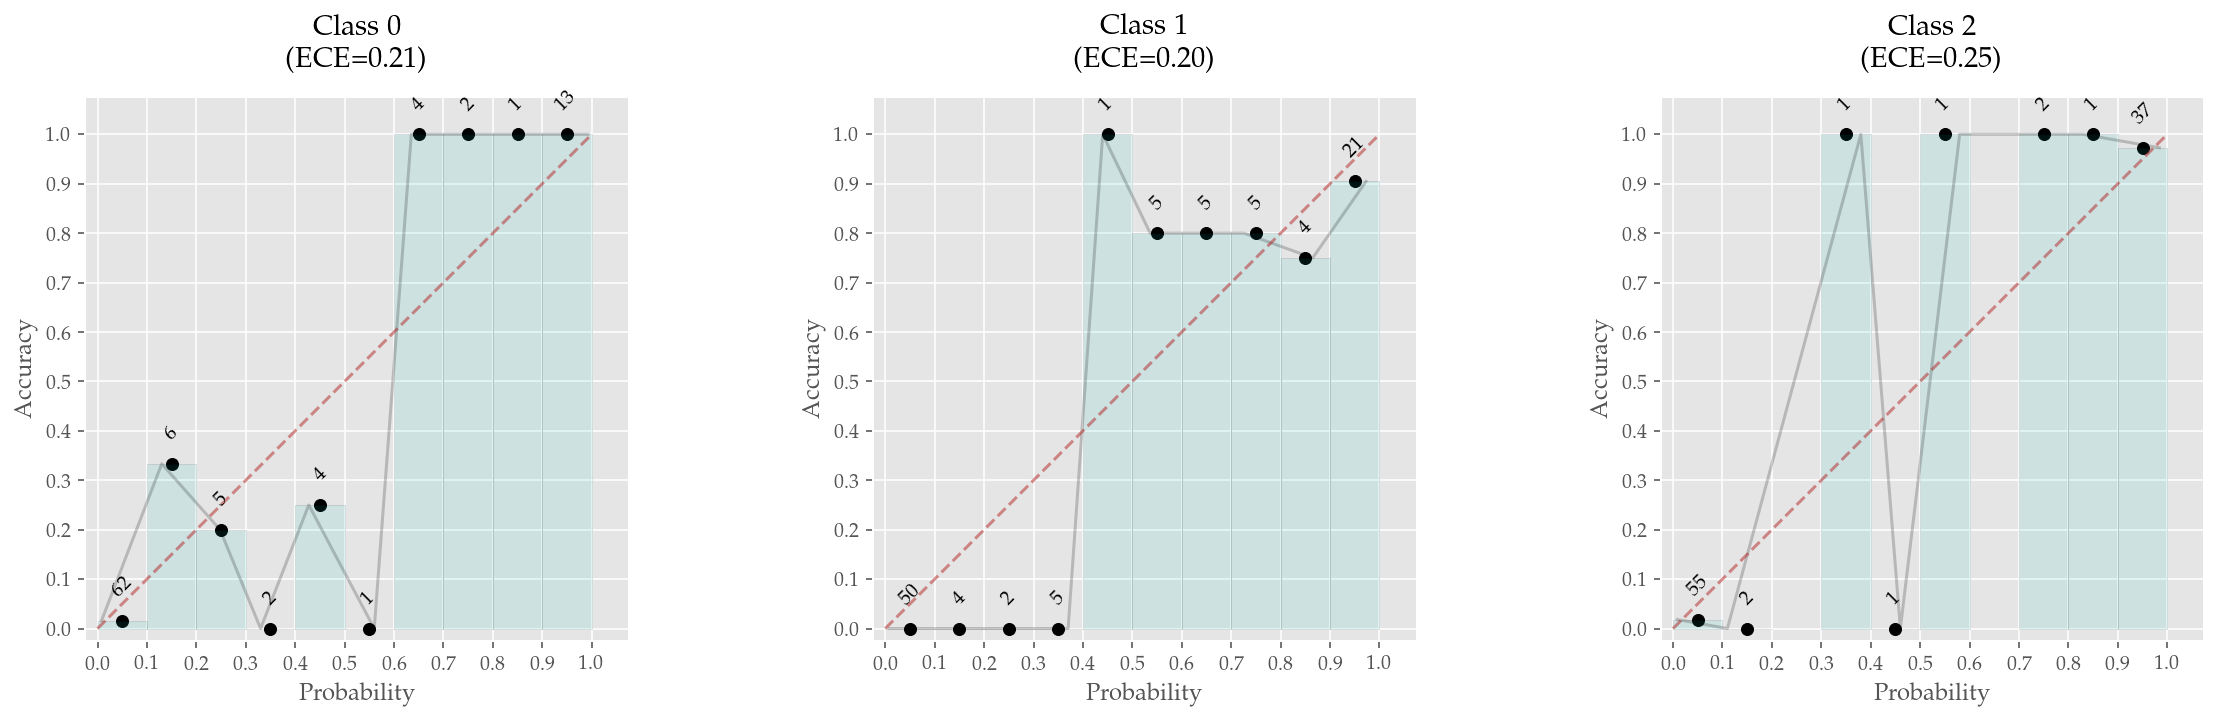

Calibrated Val (unormalized)


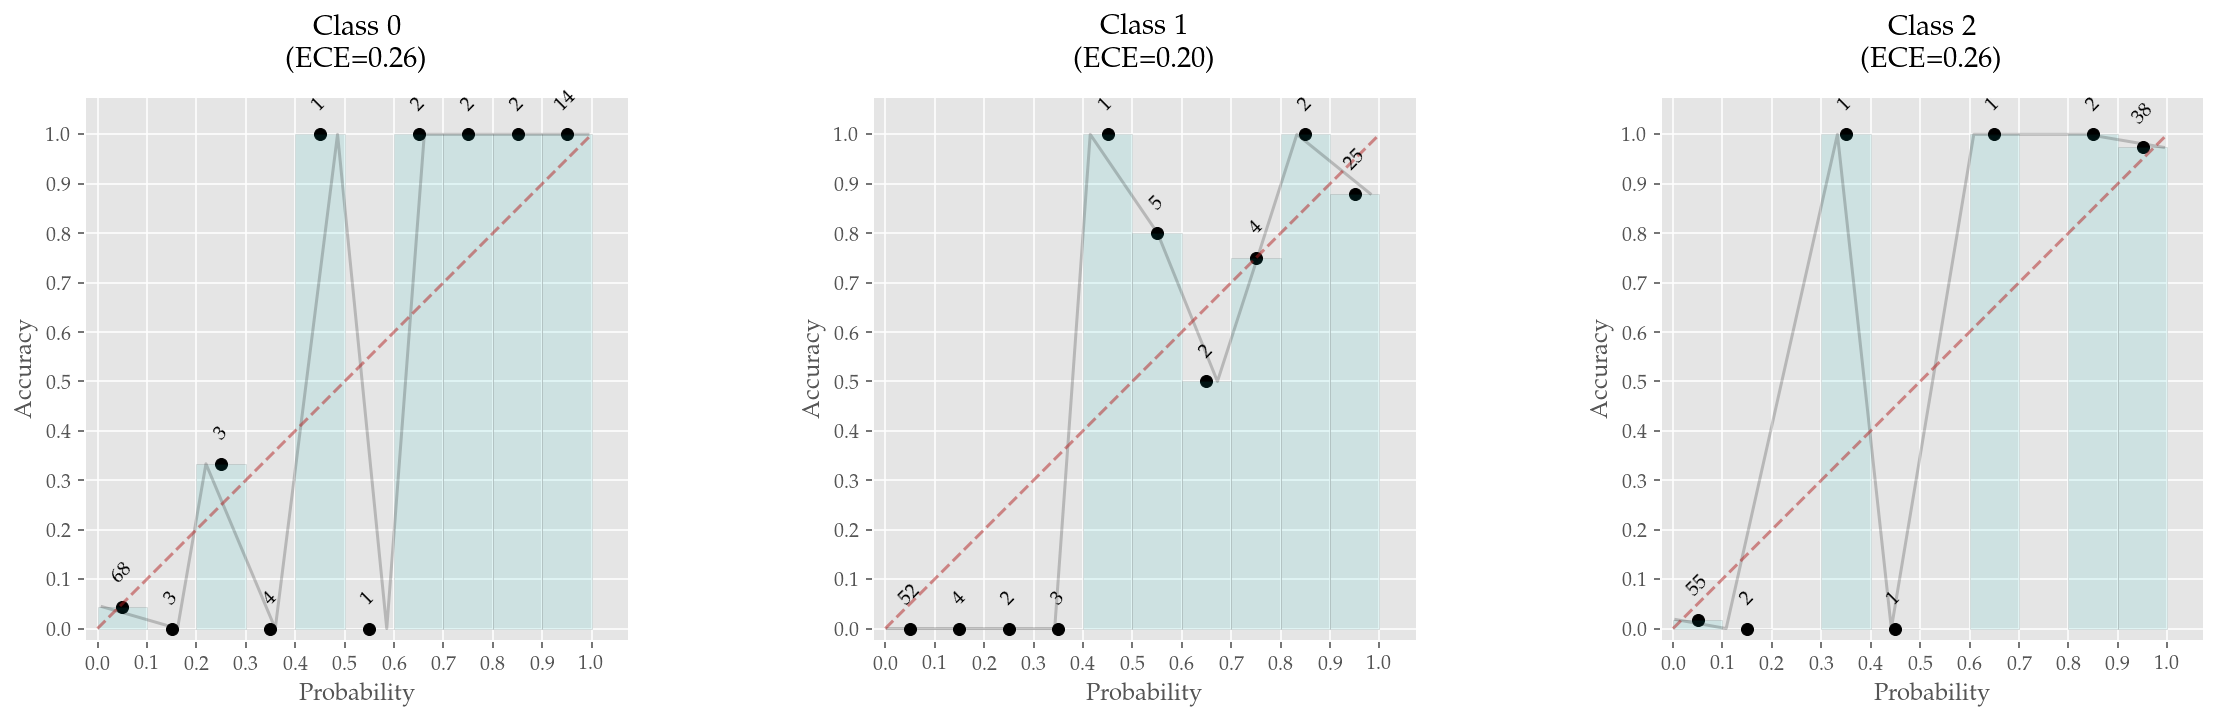

Calibrated Val (normalized) - Accuracy = 0.92


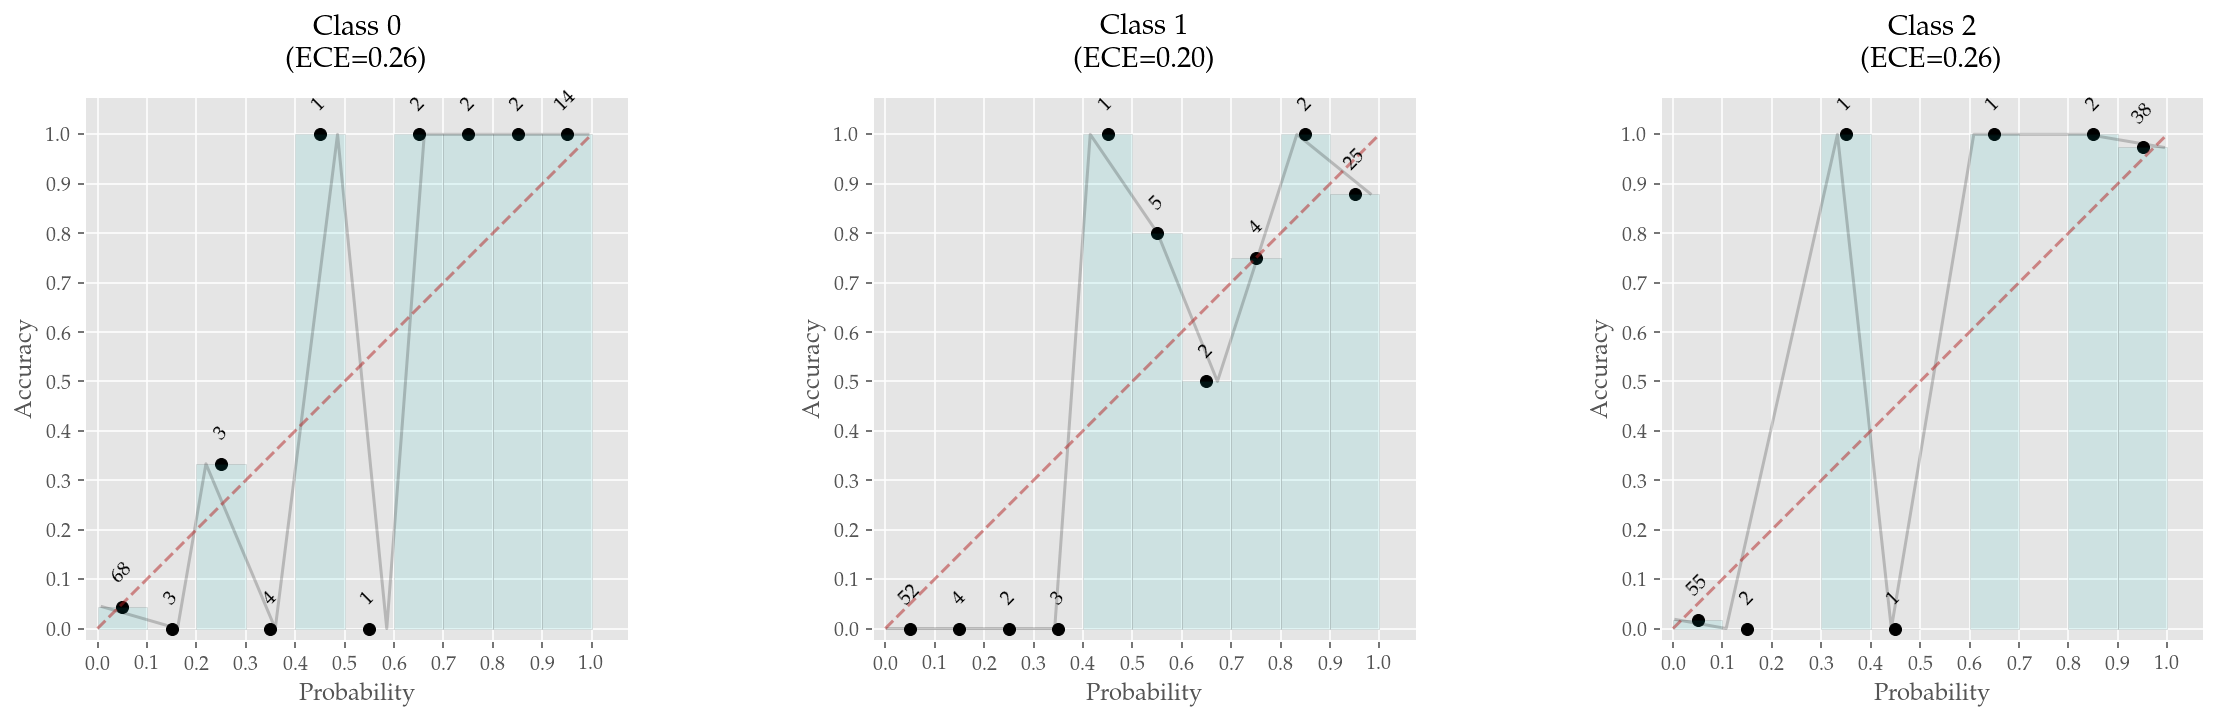

In [12]:
temperature_scaling = cal.TemperatureScaling(1.4)
temperature_scaling.fit(probs_train, classes_train)
plot_calibration_grid(probs_train, classes_train, temperature_scaling, classes_val)

# Regression methods

This methods fit a curve to the bin points defined by ranges of equal mass convoluted by a Gaussian kernel. 
This allows us to account for the distribution of the probabilities inside a range and better model the probabilities concentrated in the extremities of the bins, which canges as an effect of the number of ranges chosen. 

We set 10% of the number of data points as the number of ranges considered for calibration.

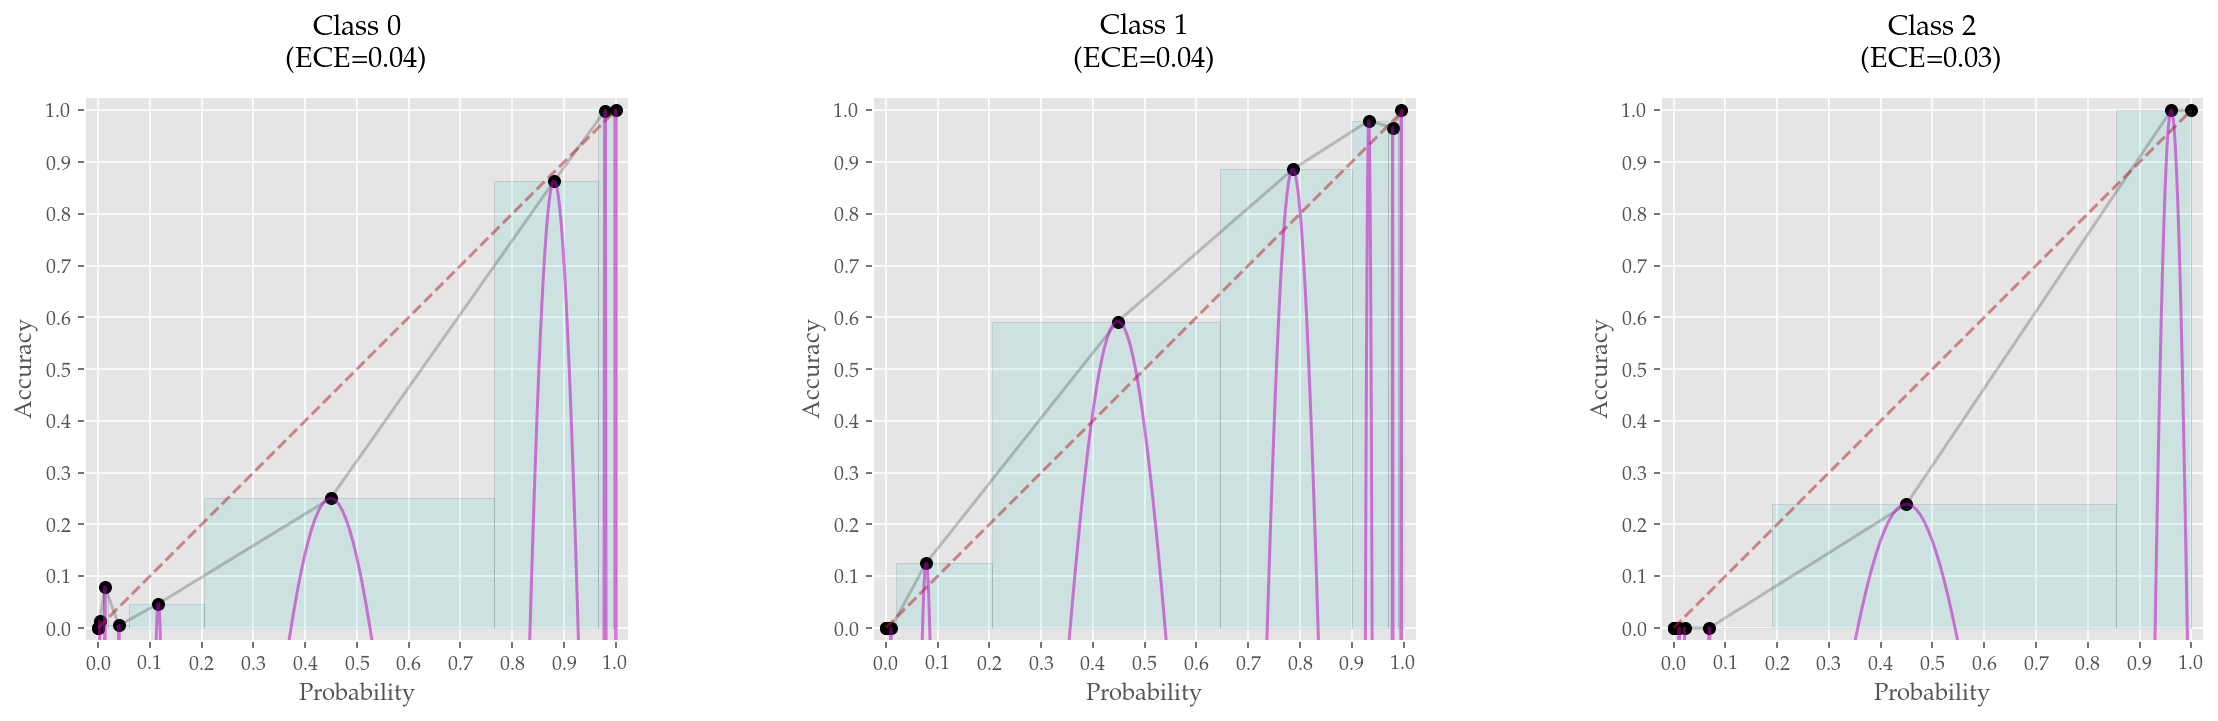

In [13]:
NUM_BINS = round(0.1 * NUM_PROBS)
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.GaussianKernel(), 
                         even_mass=True, 
                         num_points=NUM_BINS,                          
                         show_bars=True, 
                         show_counts=False, 
                         show_kernel=True, 
                         show_colormap=False)

# Unconstrained Linear Regression

## Curve

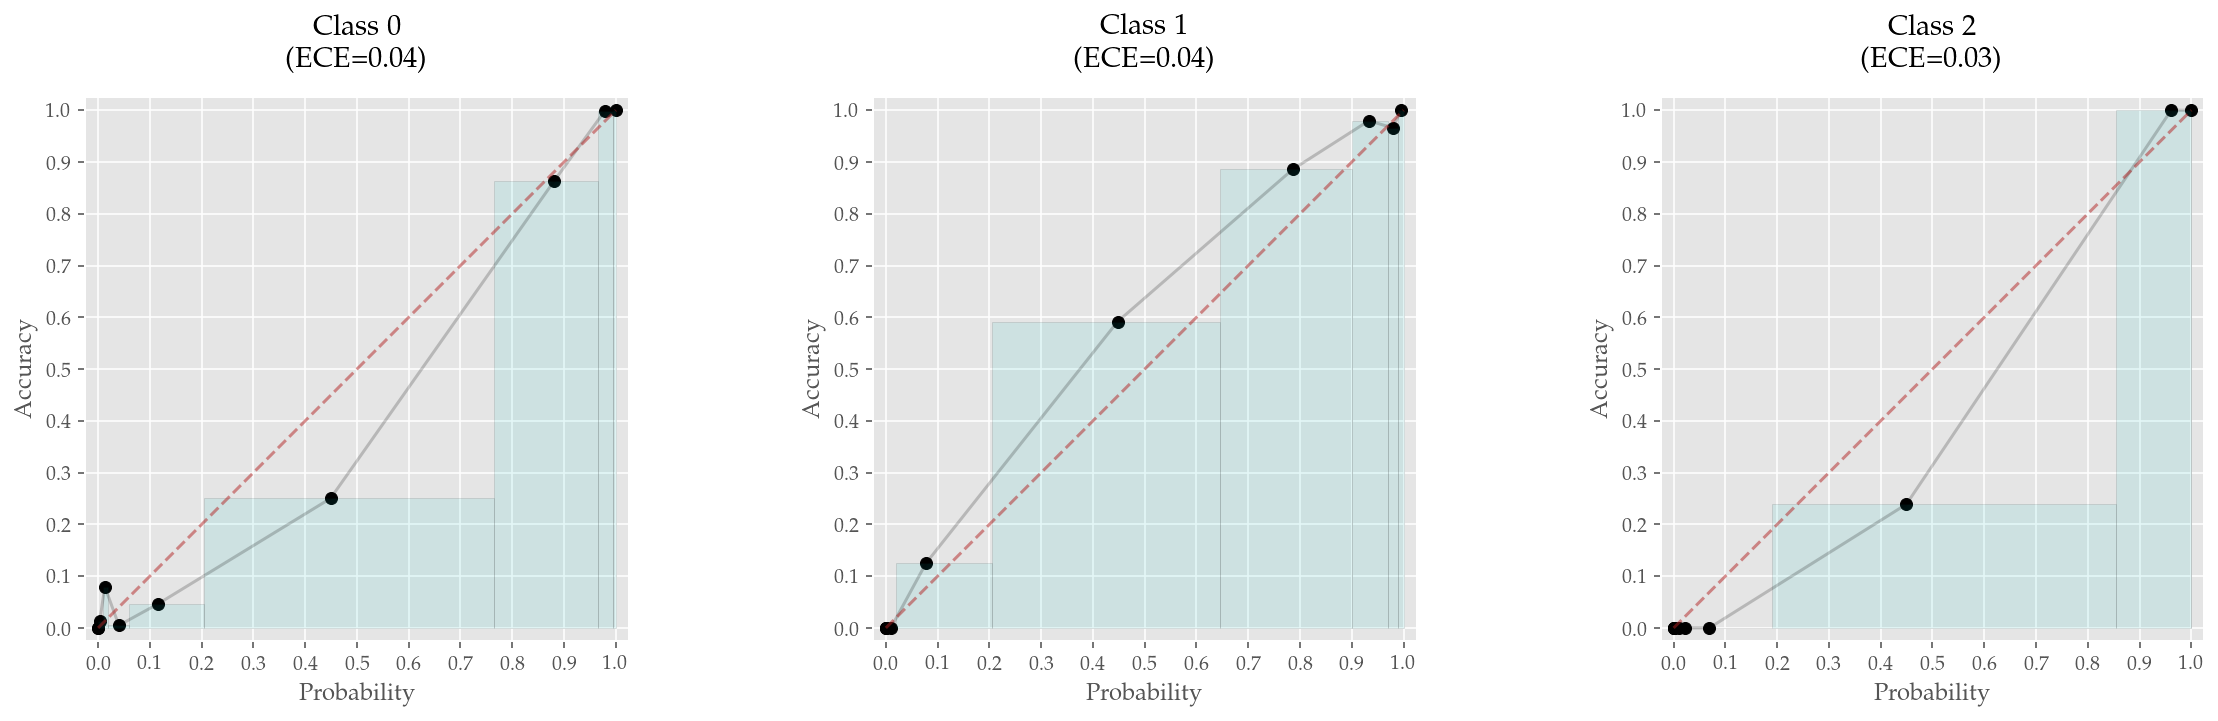

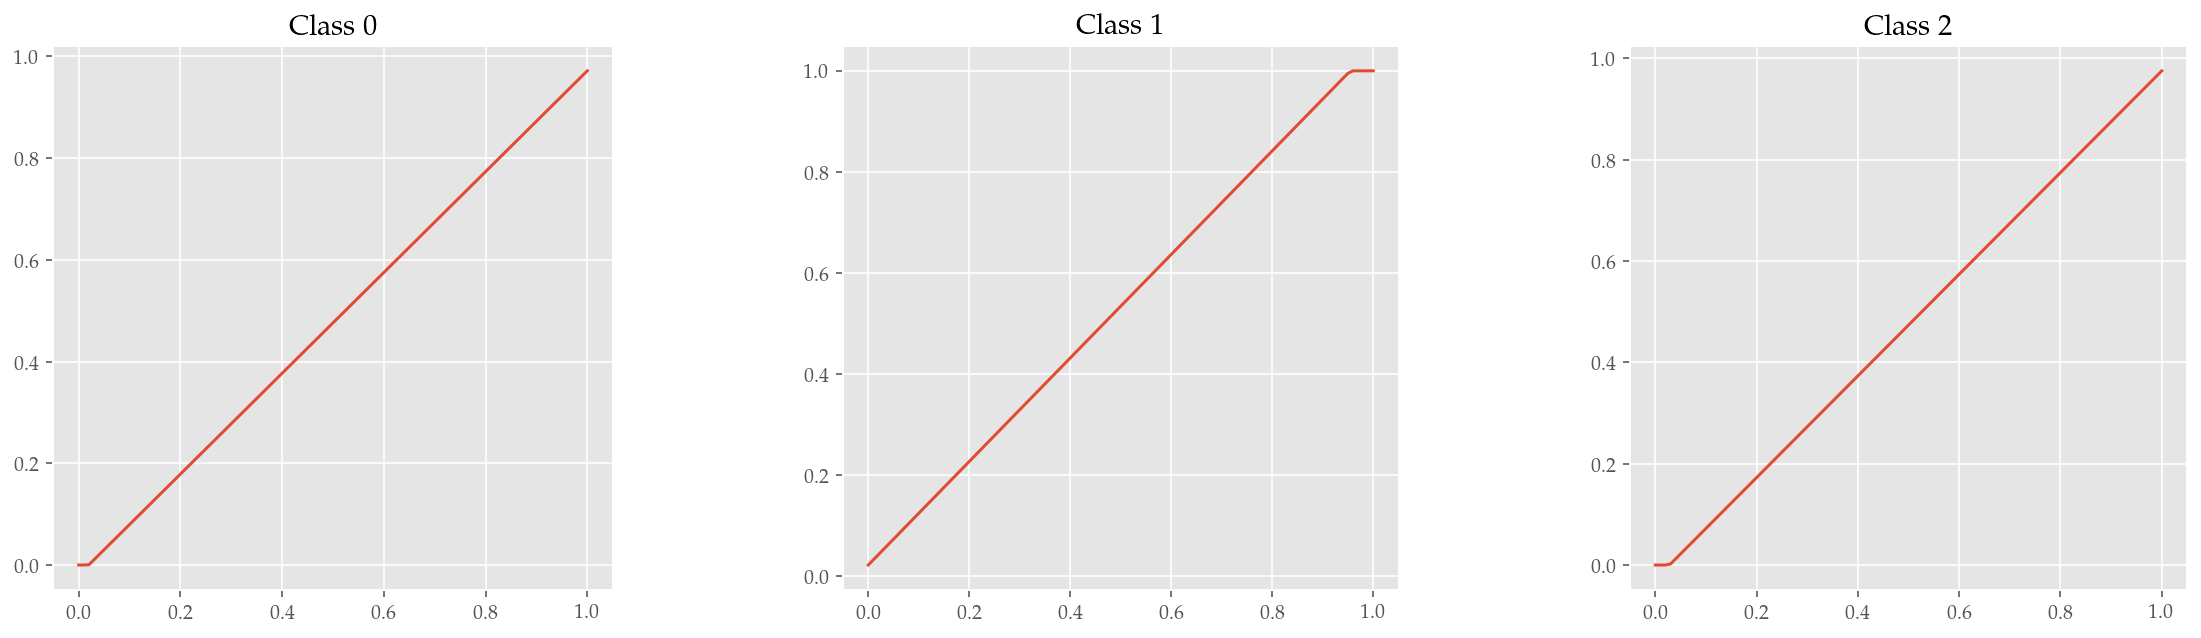

In [14]:
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.GaussianKernel(), 
                         even_mass=True, 
                         num_points=NUM_BINS,                          
                         show_bars=True, 
                         show_counts=False, 
                         show_kernel=False, 
                         show_colormap=False)

lr = cal.LinearRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True)
lr.fit(probs_train, classes_train)
plot_cal_curve(lr)

## Calibration

Original Training - Accuracy = 0.91


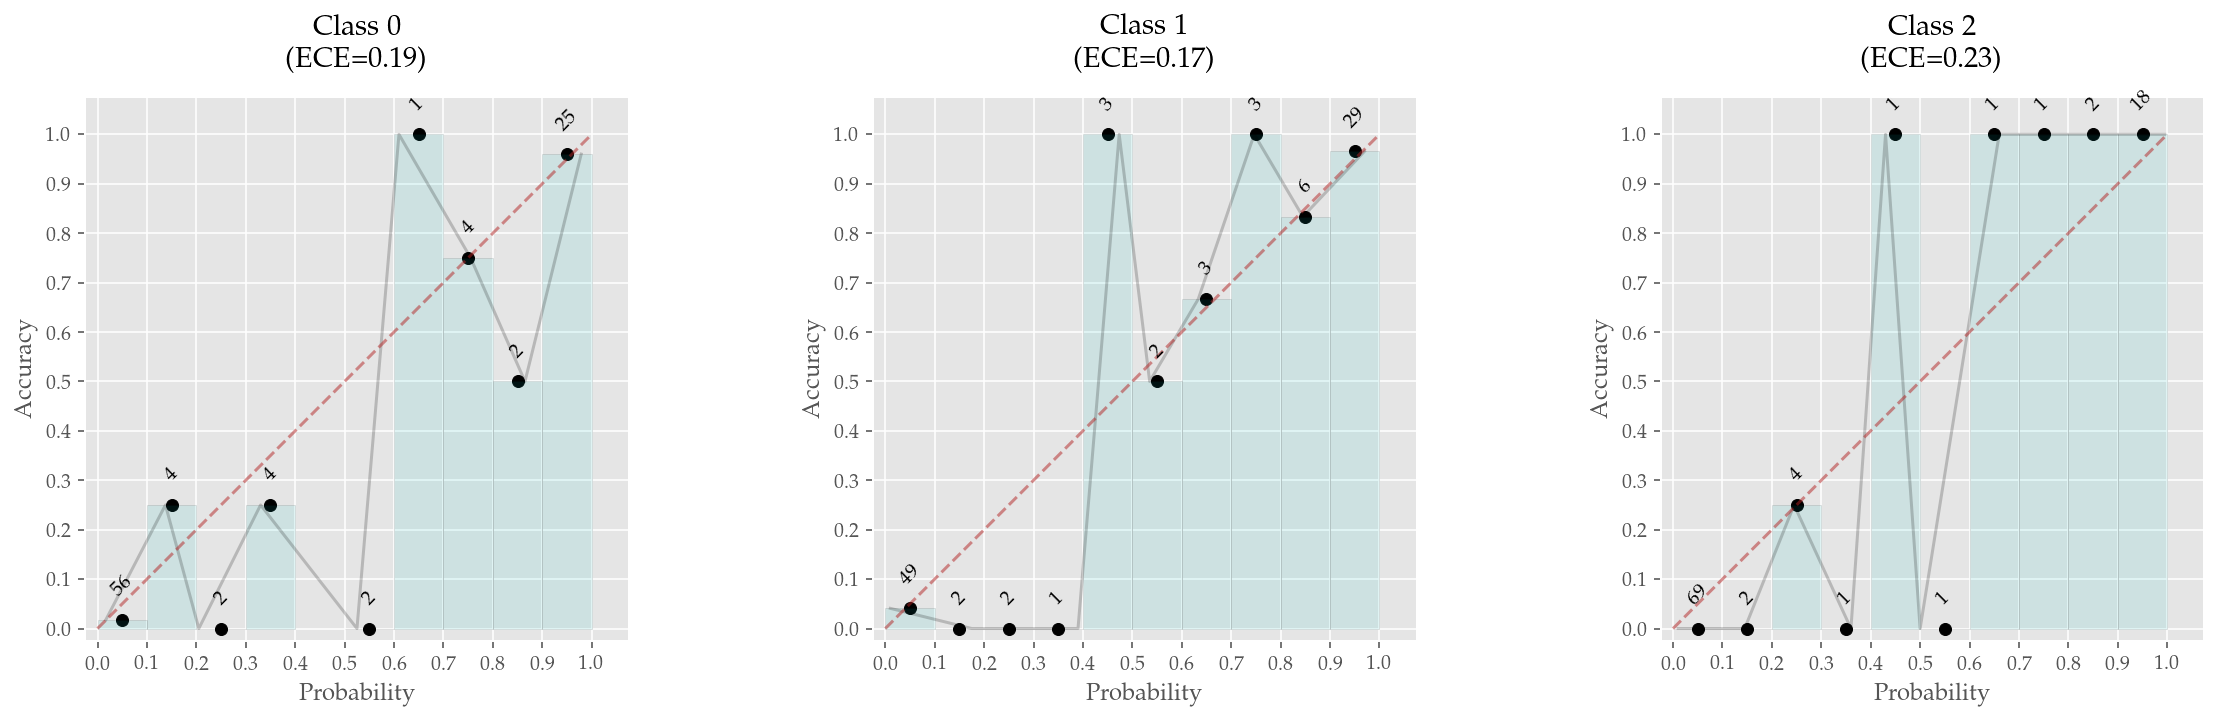

Calibrated Training (unormalized)


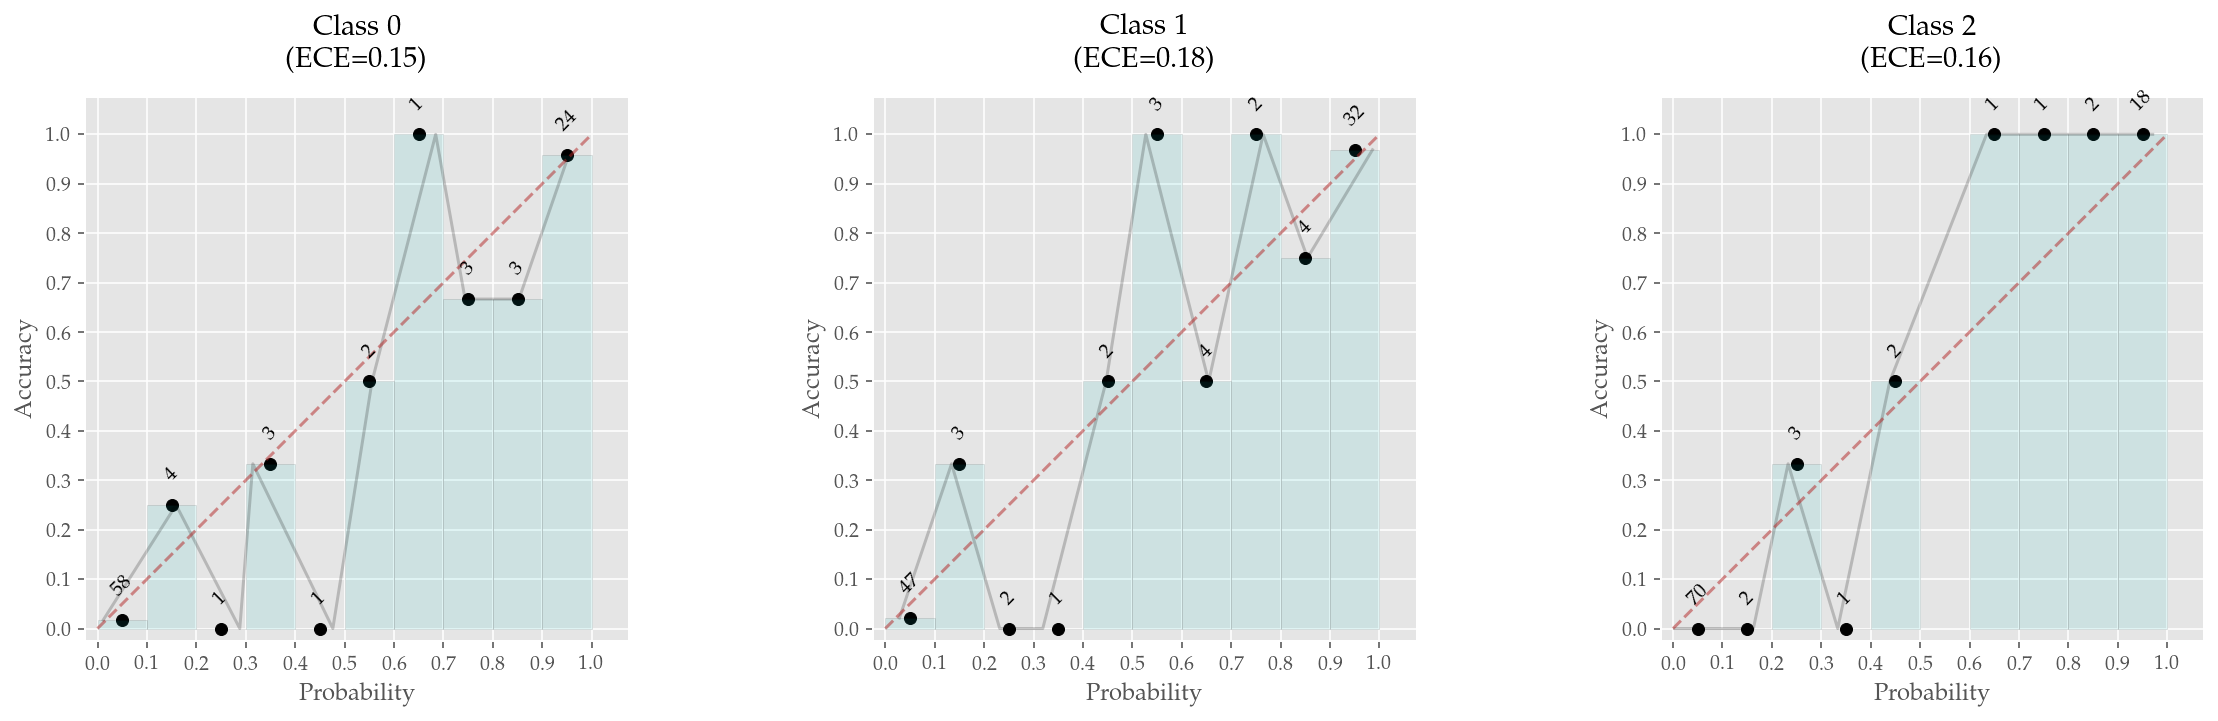

Calibrated Training (normalized) - Accuracy = 0.92


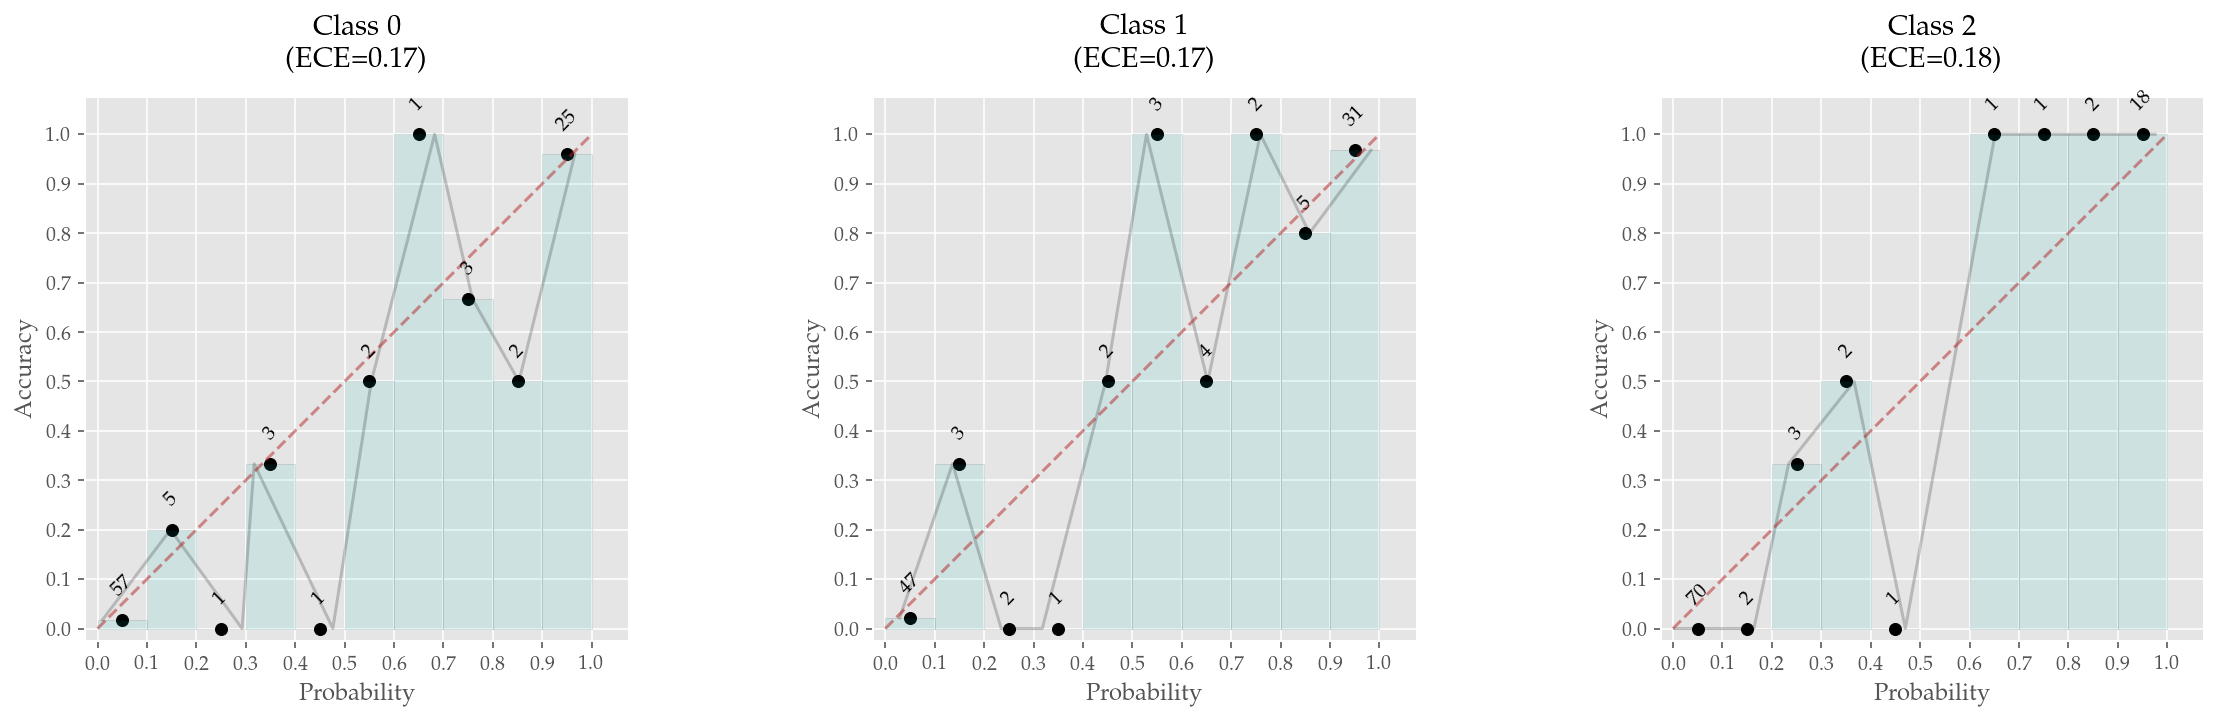

Original Val - Accuracy = 0.92


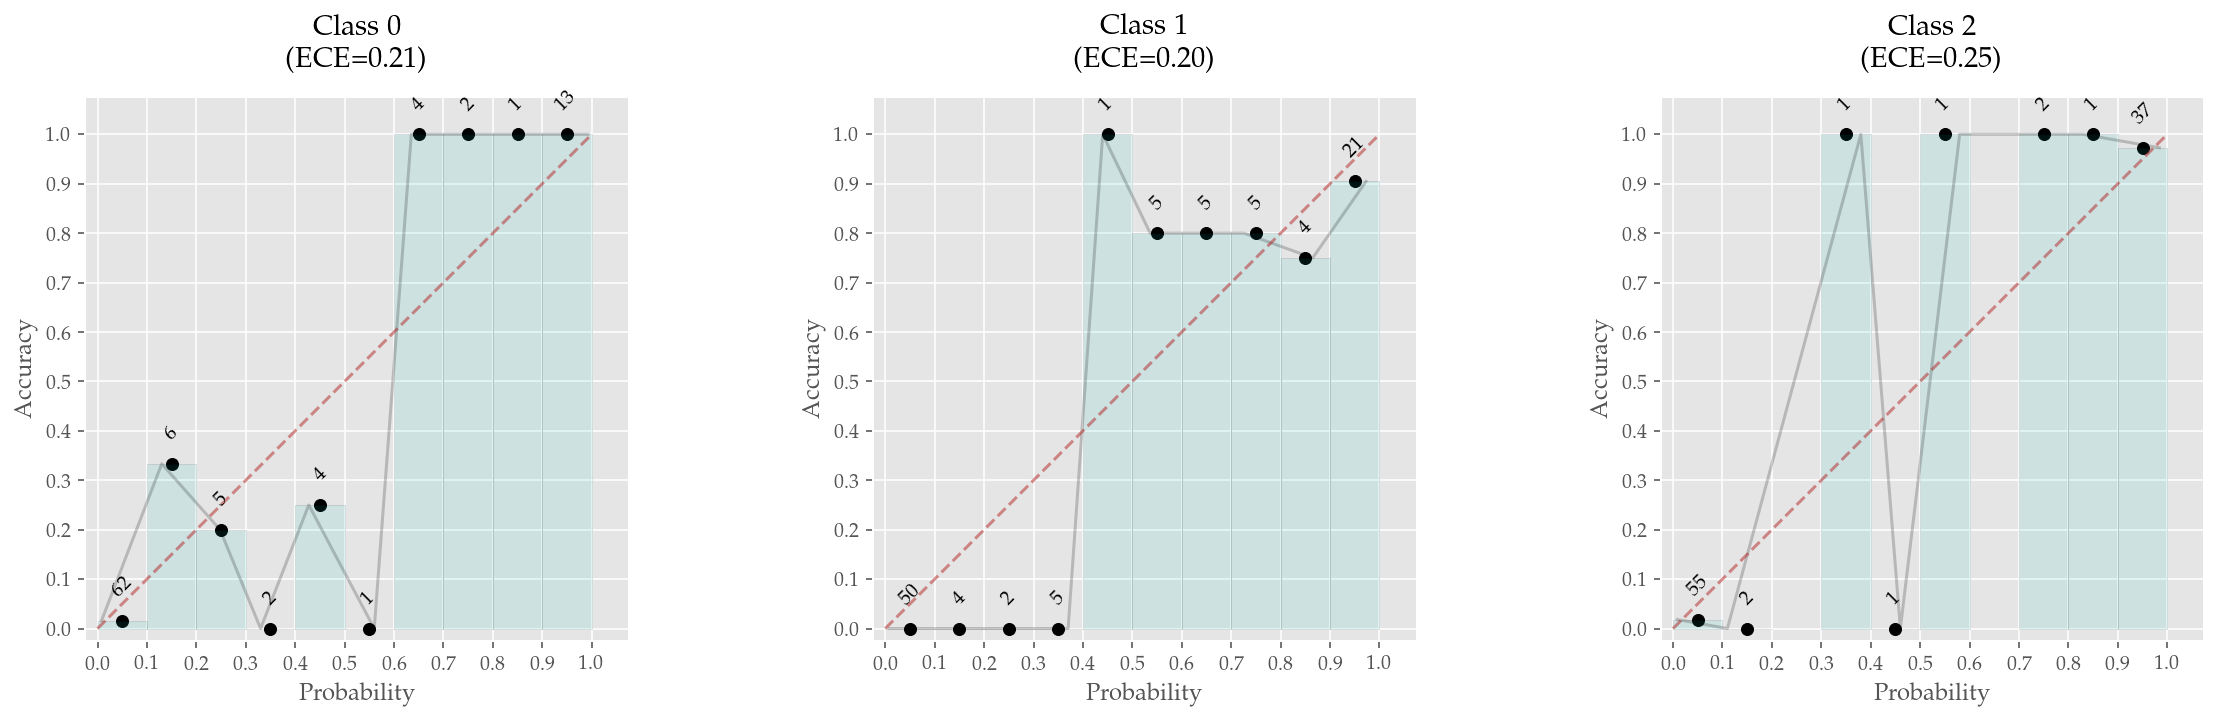

Calibrated Val (unormalized)


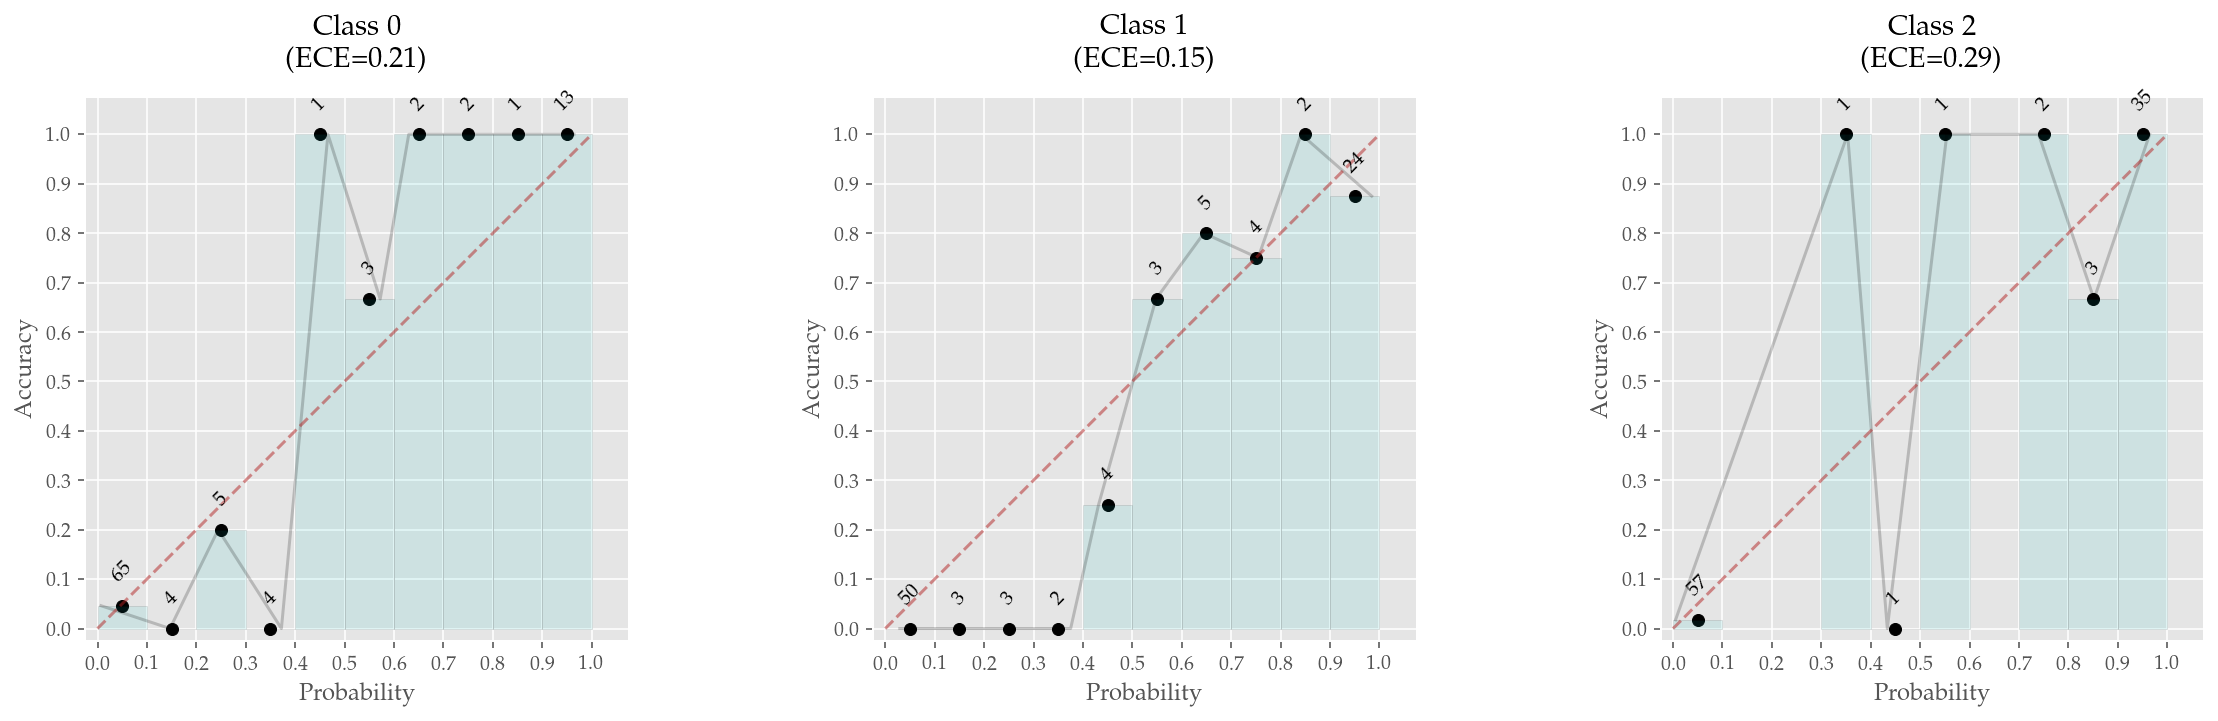

Calibrated Val (normalized) - Accuracy = 0.92


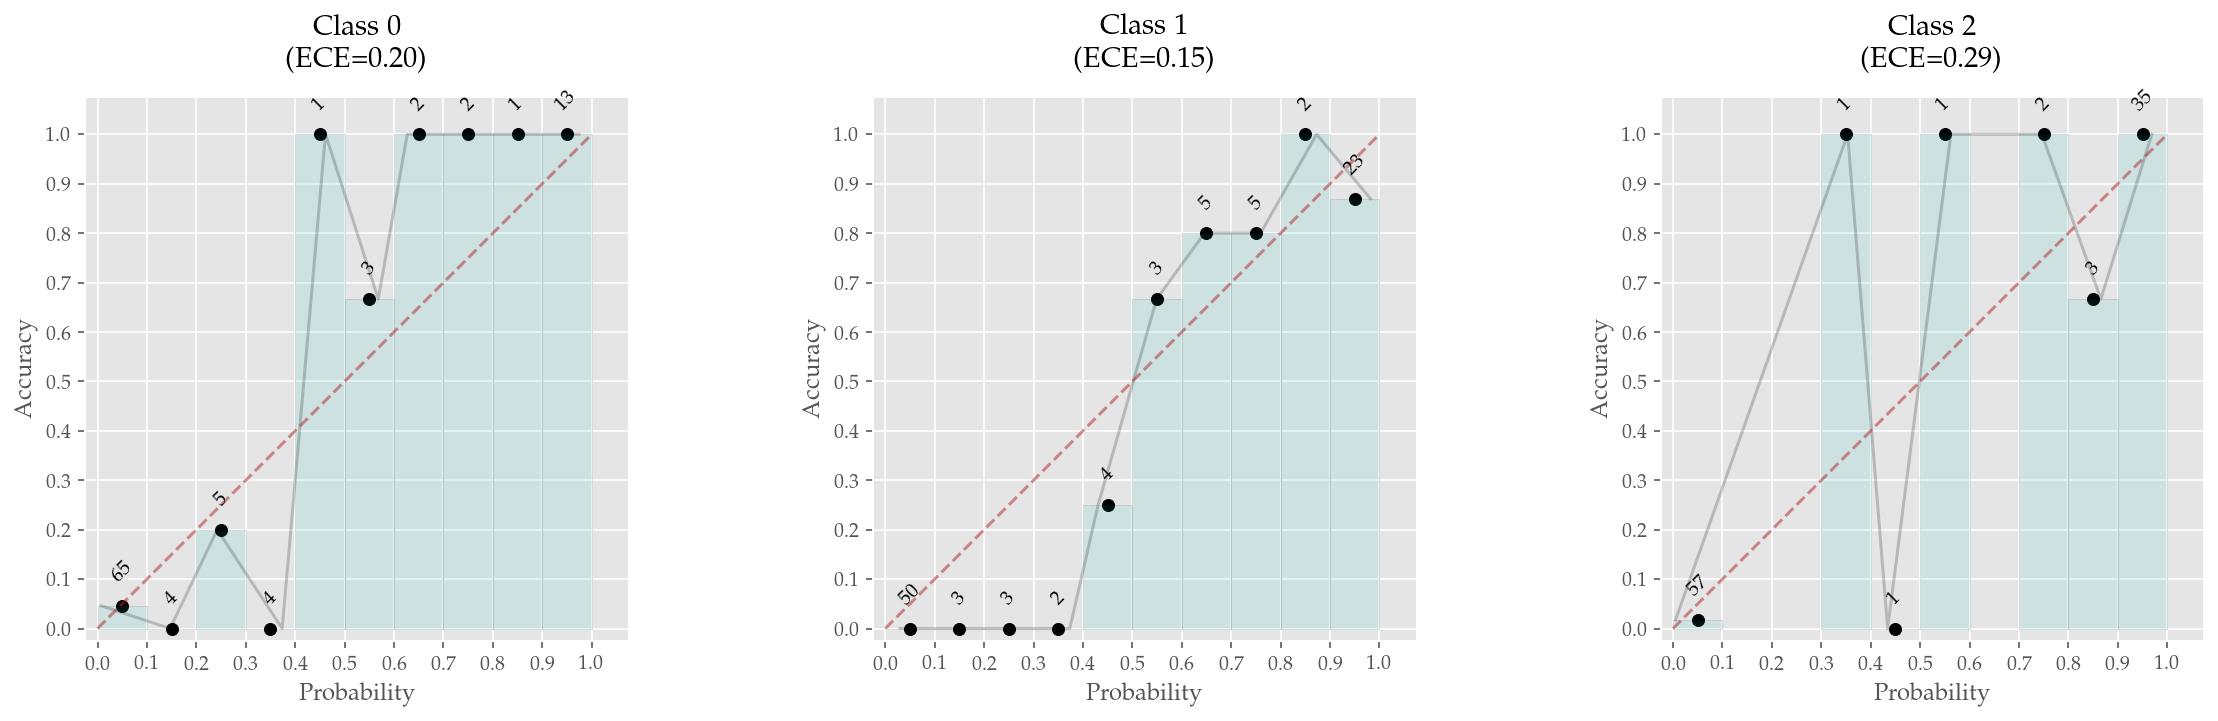

In [15]:
plot_calibration_grid(probs_train, classes_train, lr, classes_val) 

# Constrained Linear Regression

Ensures that the points are fitted by a monotonically increasing function with intercept $\ge 0$ and $f(1) <= 1$.

## Curve

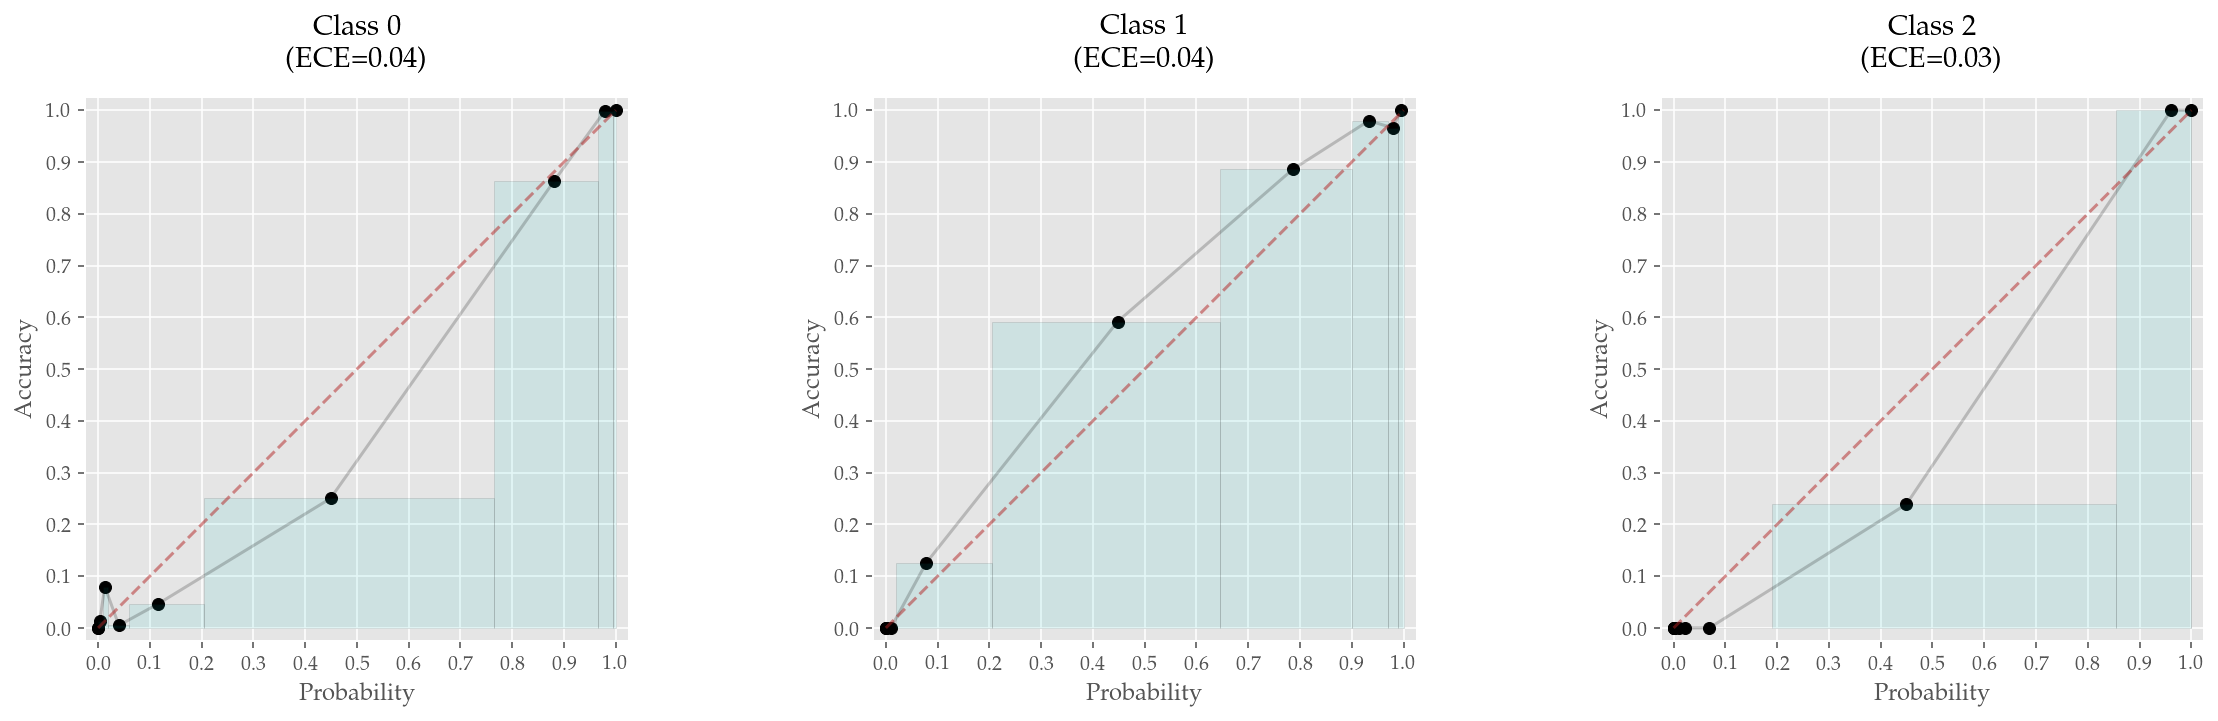

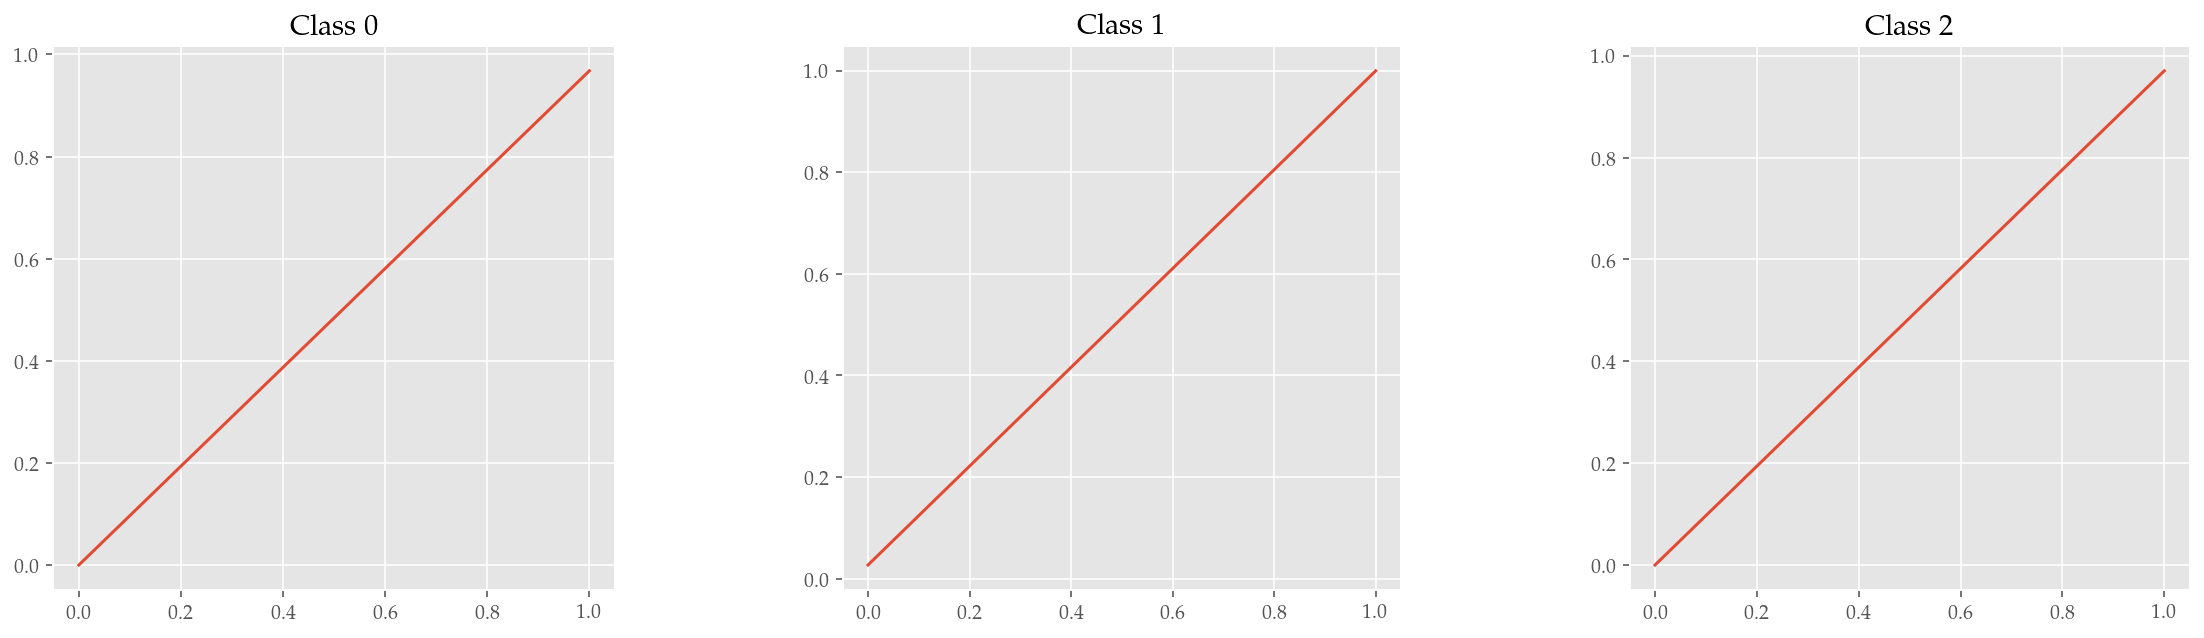

In [16]:
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.GaussianKernel(), 
                         even_mass=True, 
                         num_points=NUM_BINS,                          
                         show_bars=True, 
                         show_counts=False, 
                         show_kernel=False, 
                         show_colormap=False)

lr = cal.ConstrainedLinearRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True)
lr.fit(probs_train, classes_train)
plot_cal_curve(lr)

## Calibration

Original Training - Accuracy = 0.91


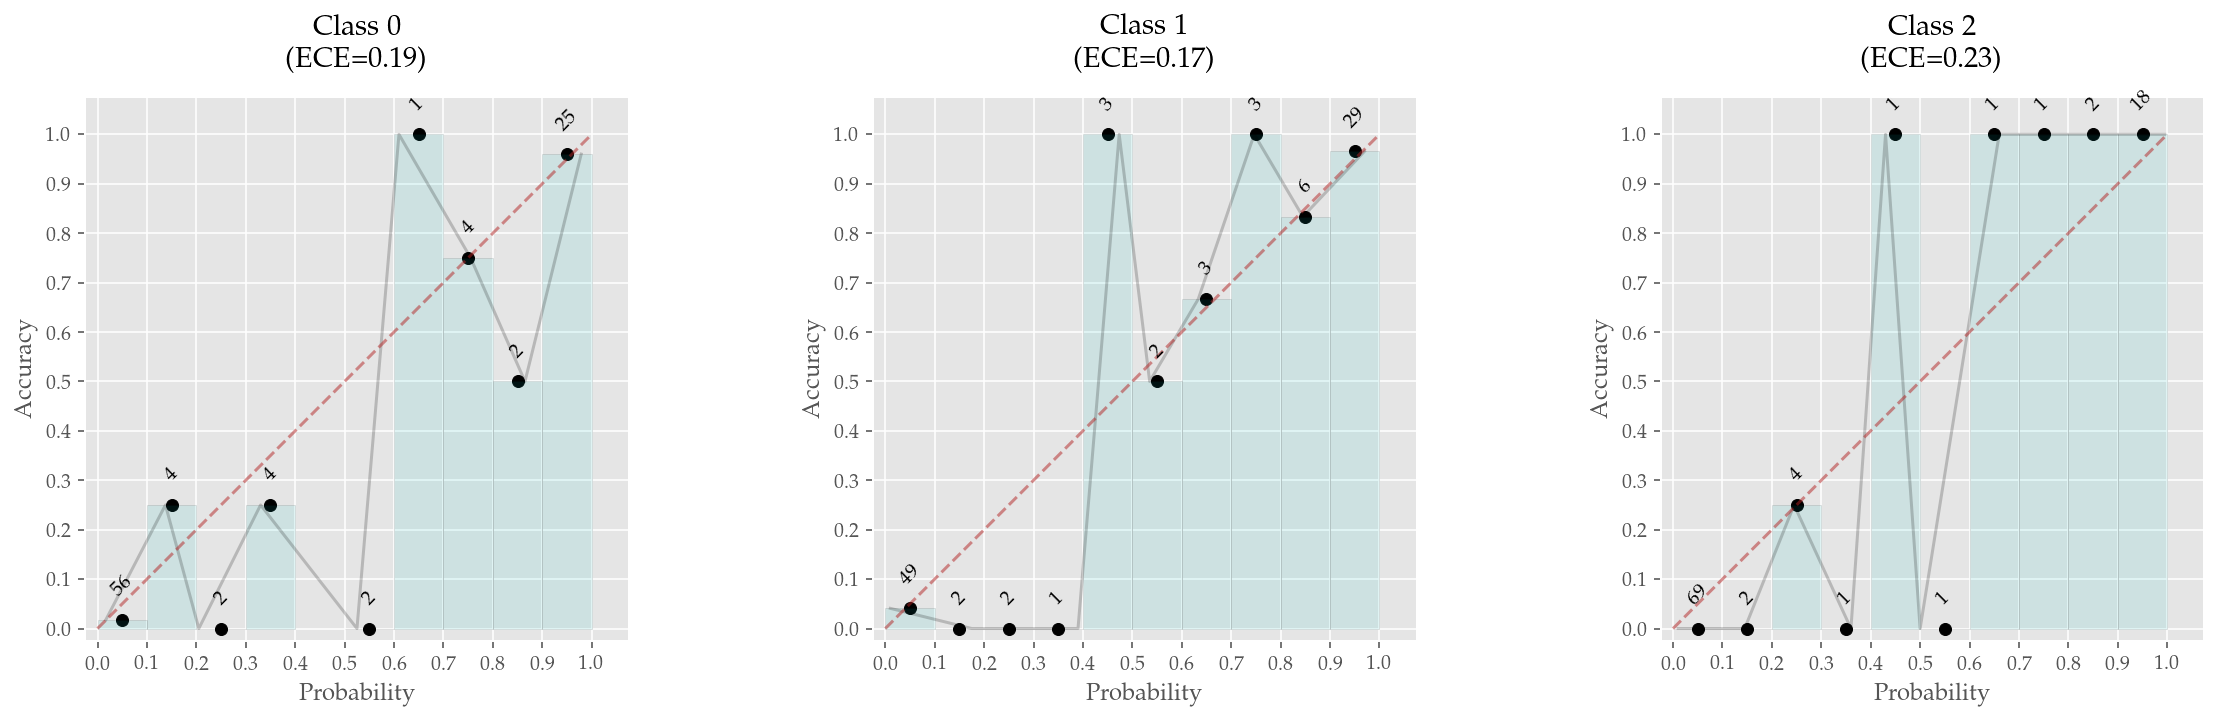

Calibrated Training (unormalized)


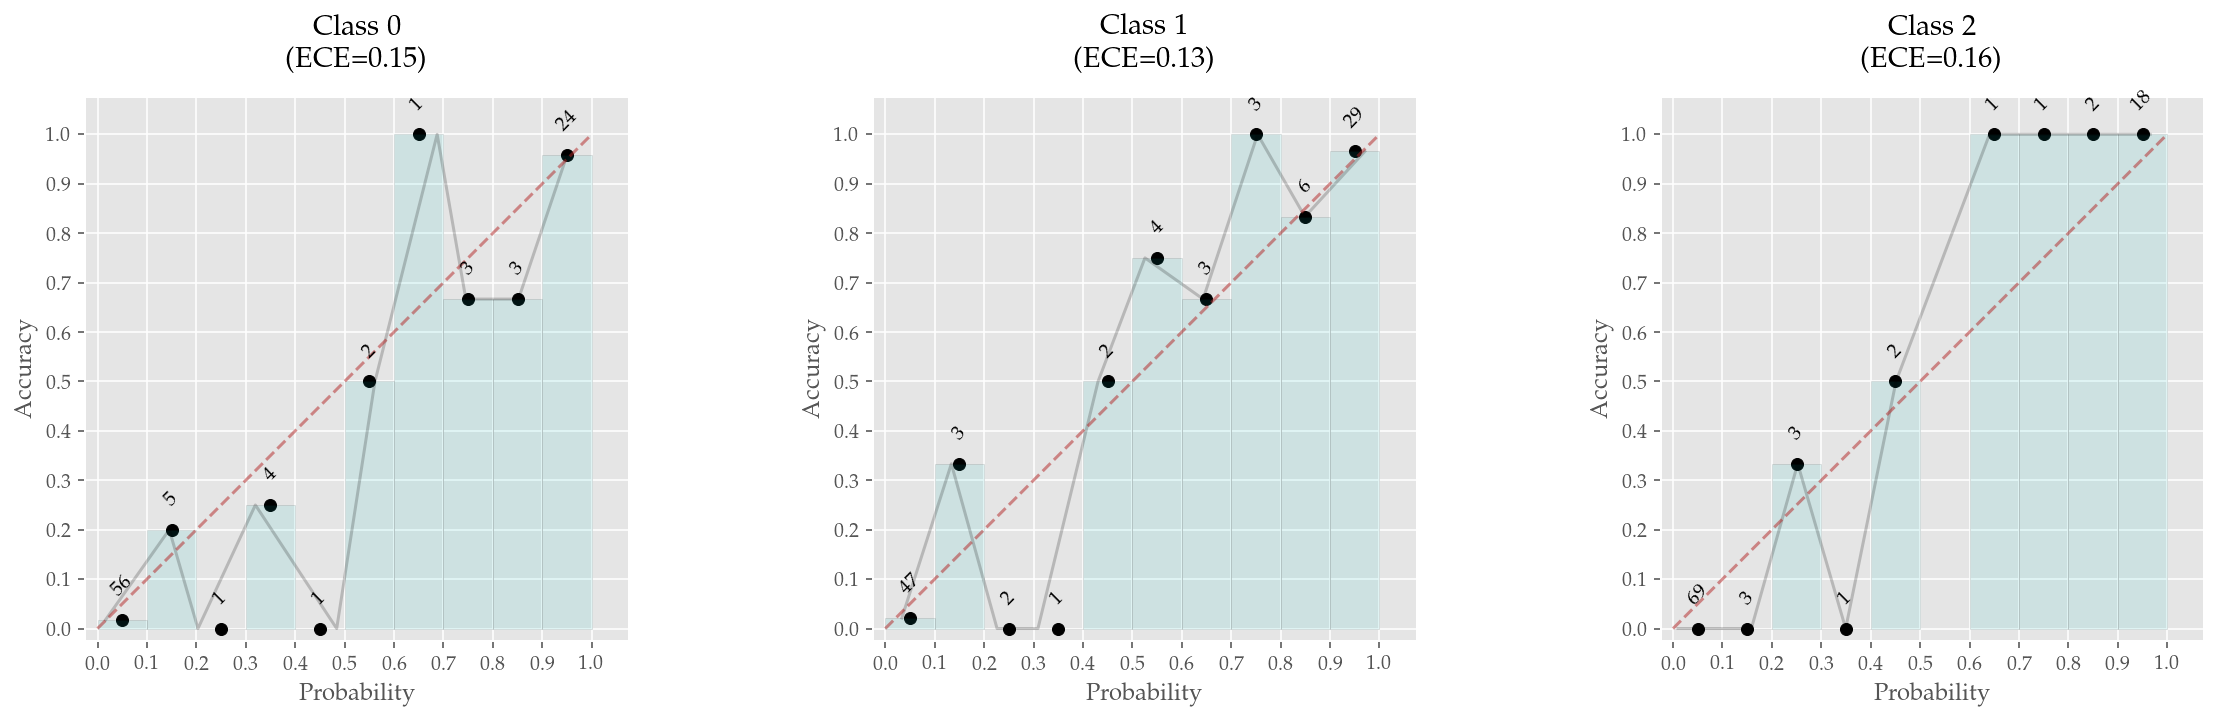

Calibrated Training (normalized) - Accuracy = 0.92


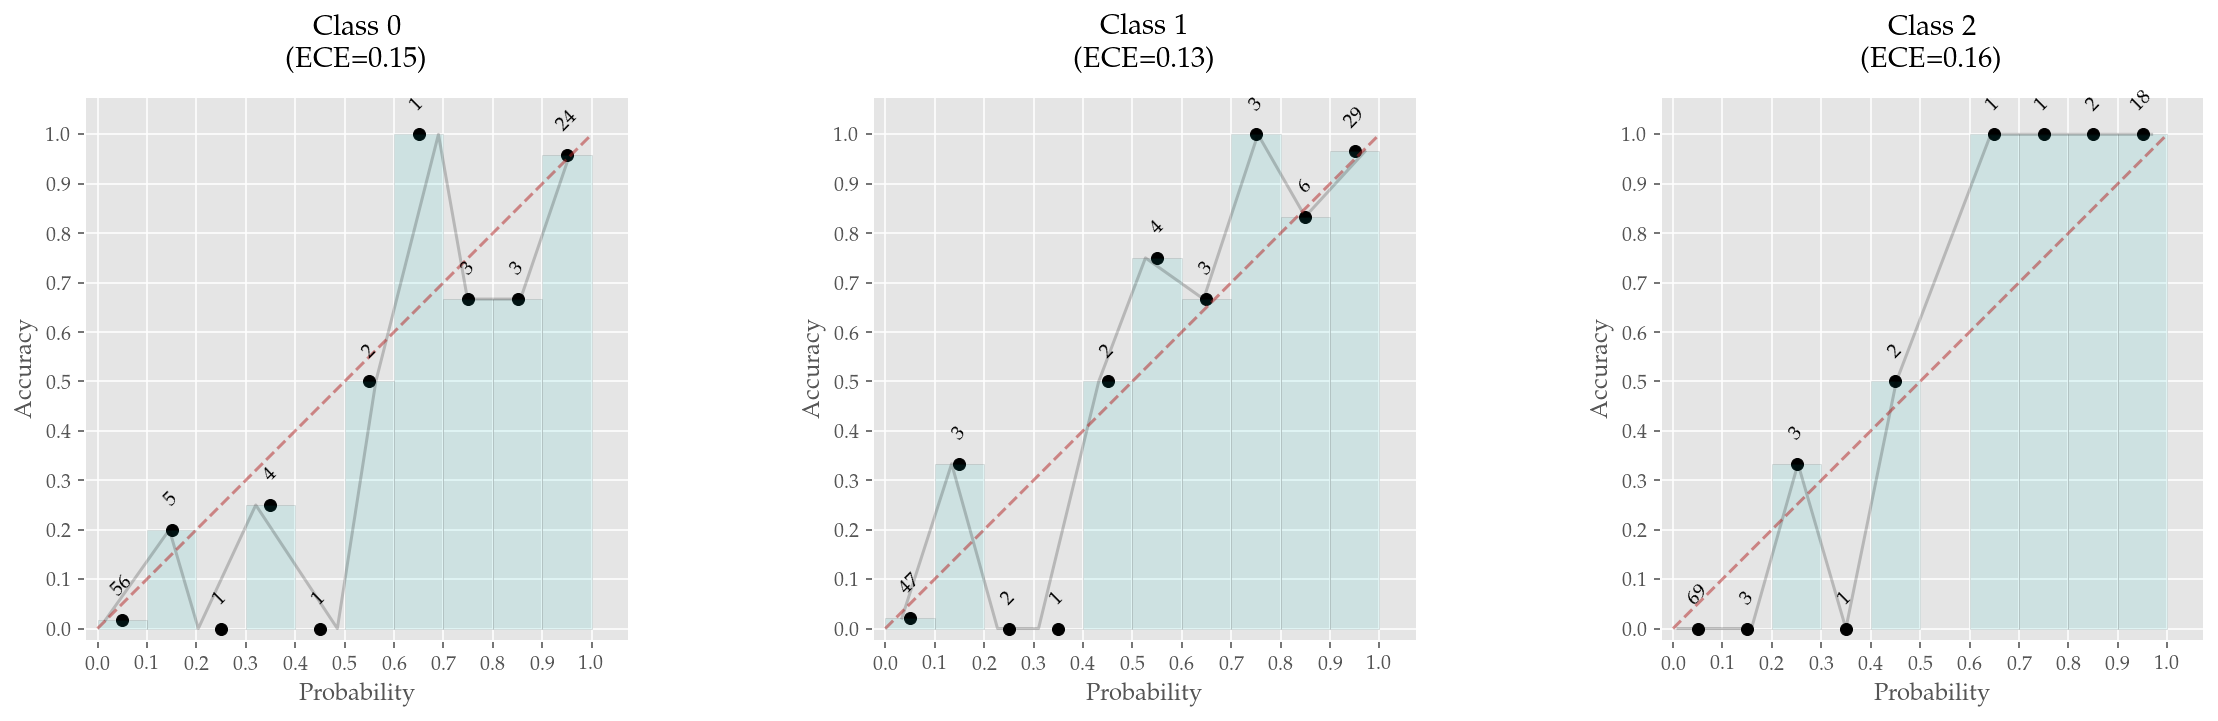

Original Val - Accuracy = 0.92


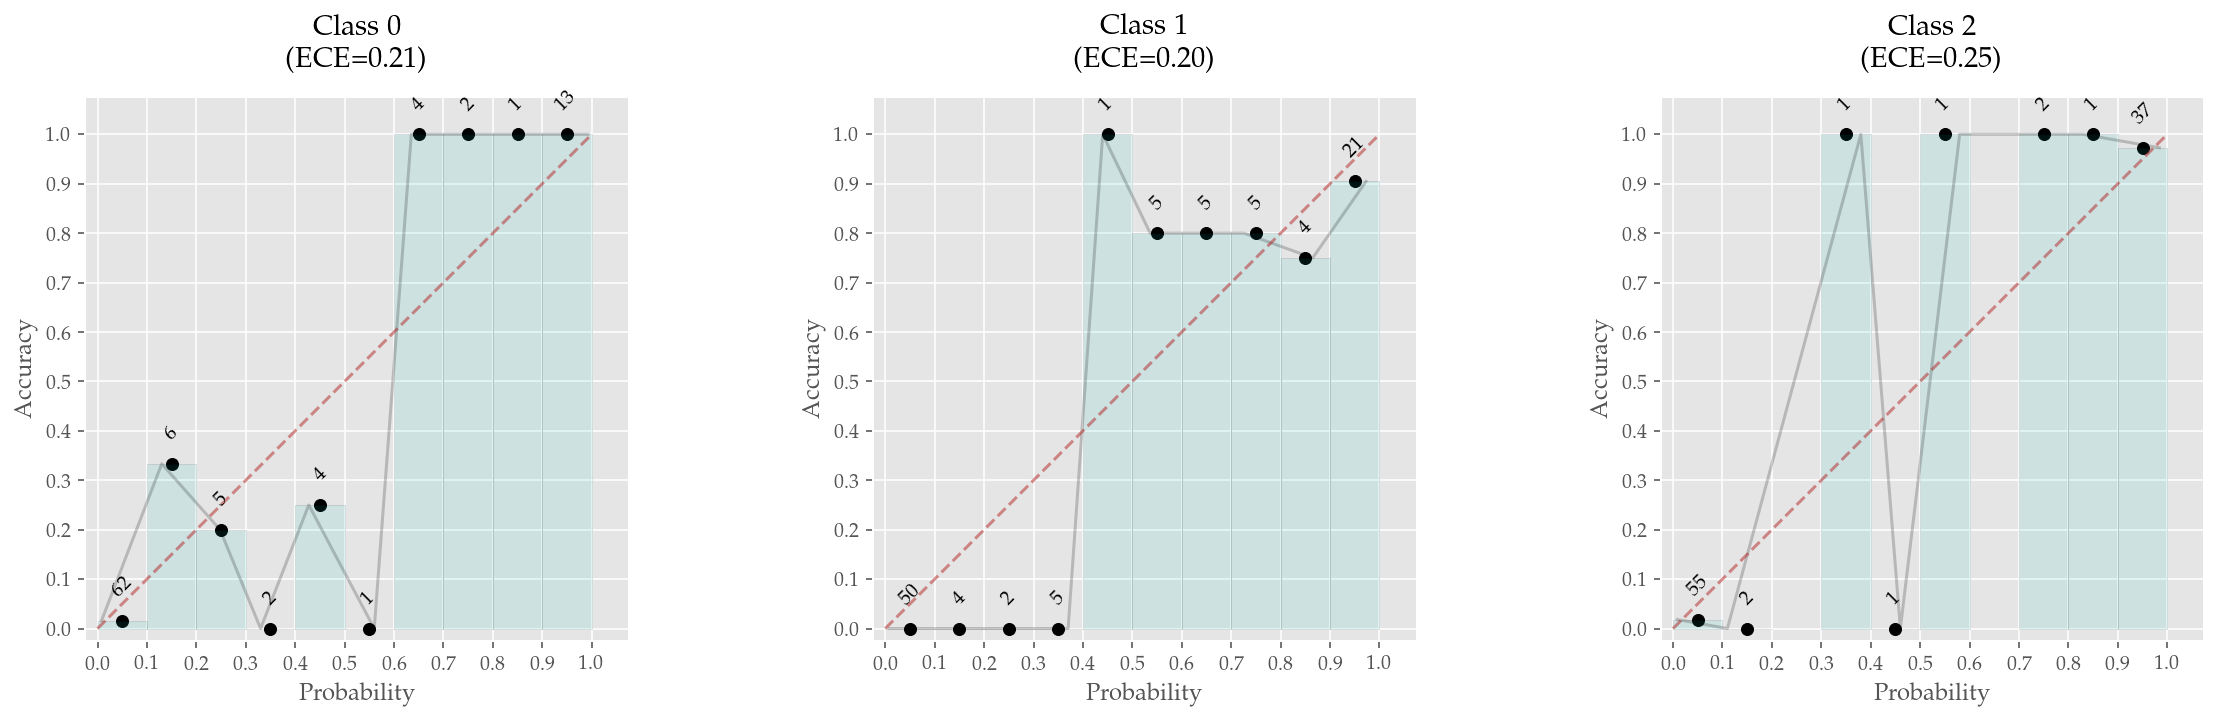

Calibrated Val (unormalized)


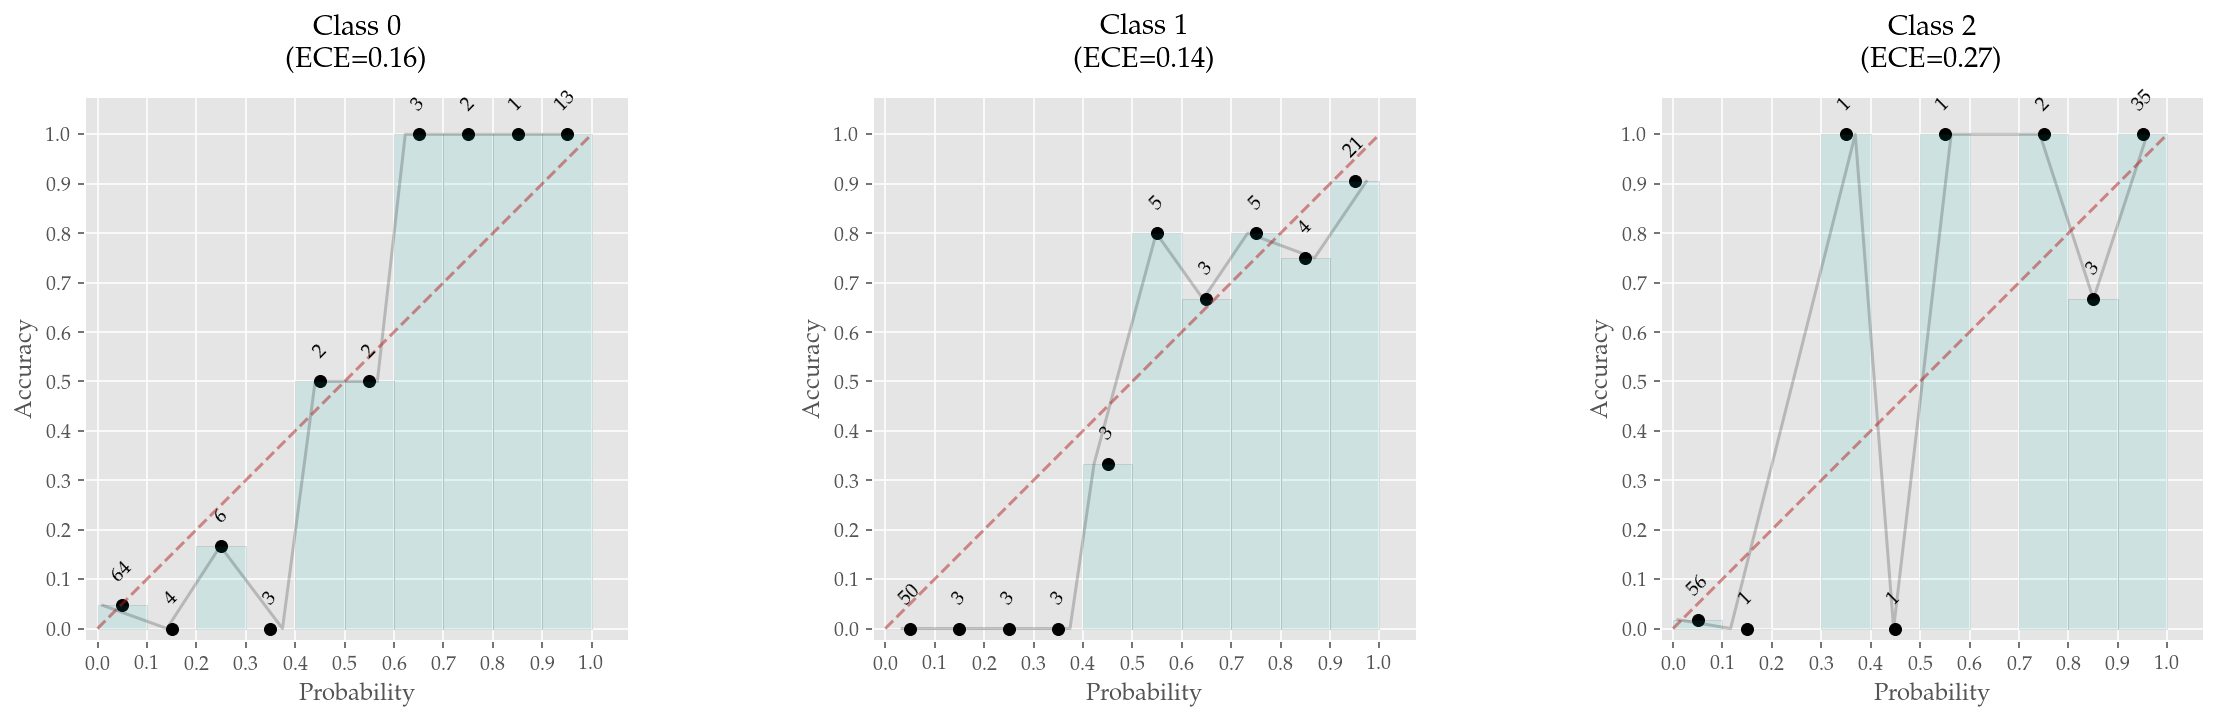

Calibrated Val (normalized) - Accuracy = 0.92


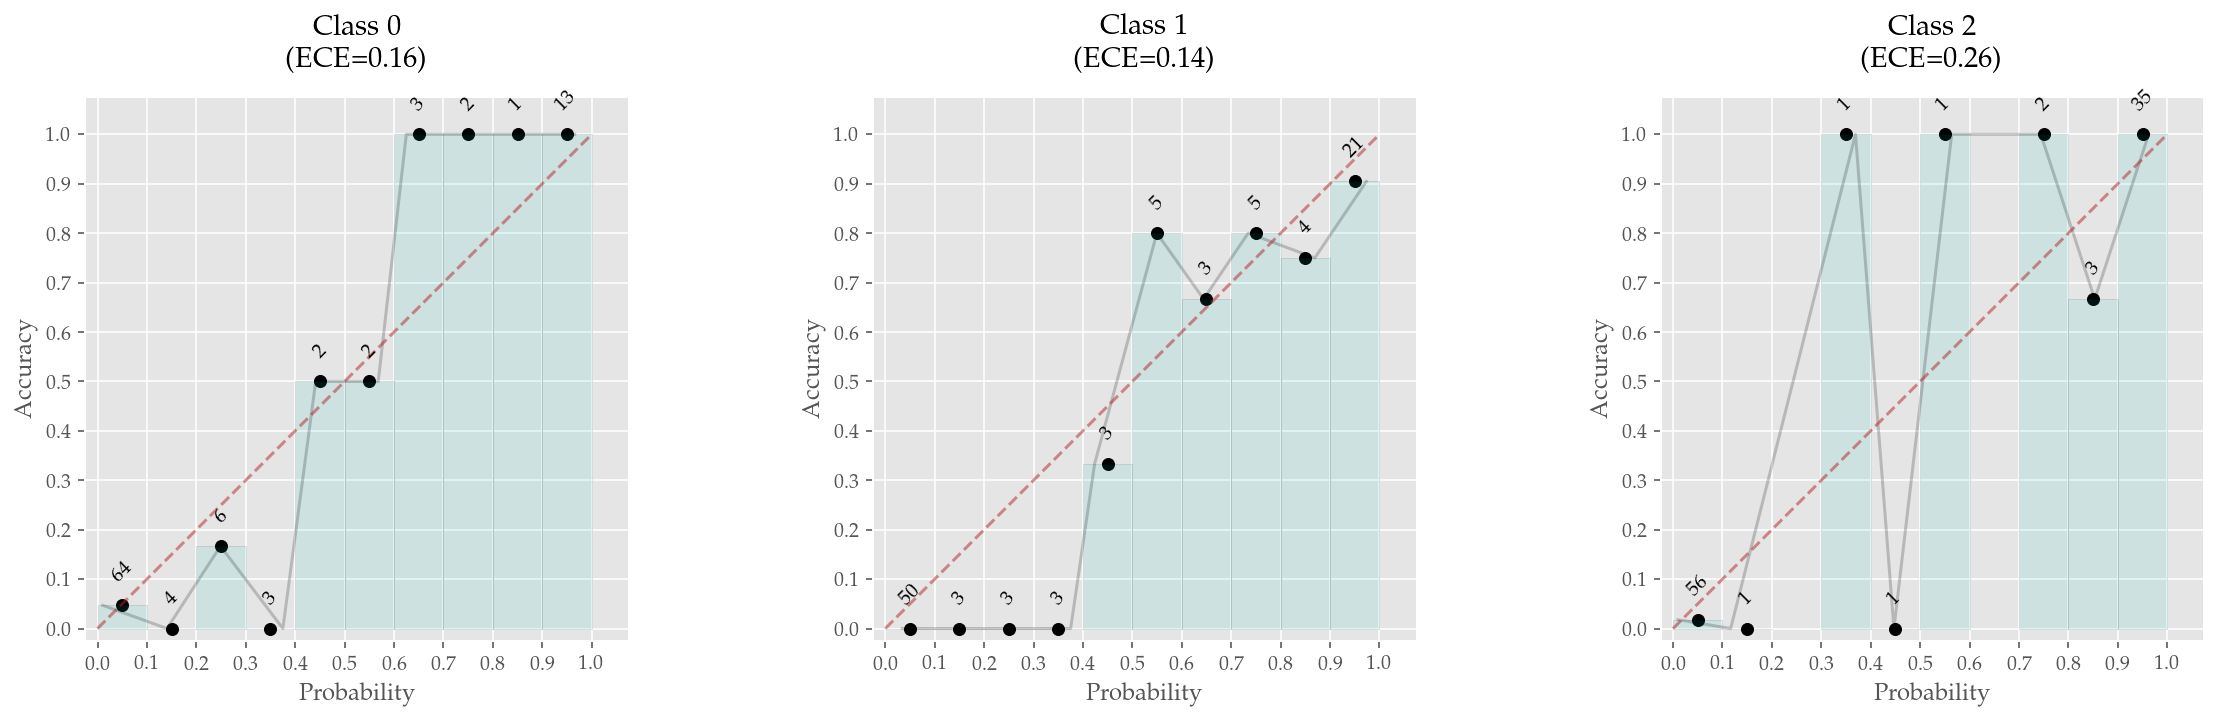

In [17]:
plot_calibration_grid(probs_train, classes_train, lr, classes_val) 

# Gamma

$y = (x/k)^{1/\gamma}$

## Curve

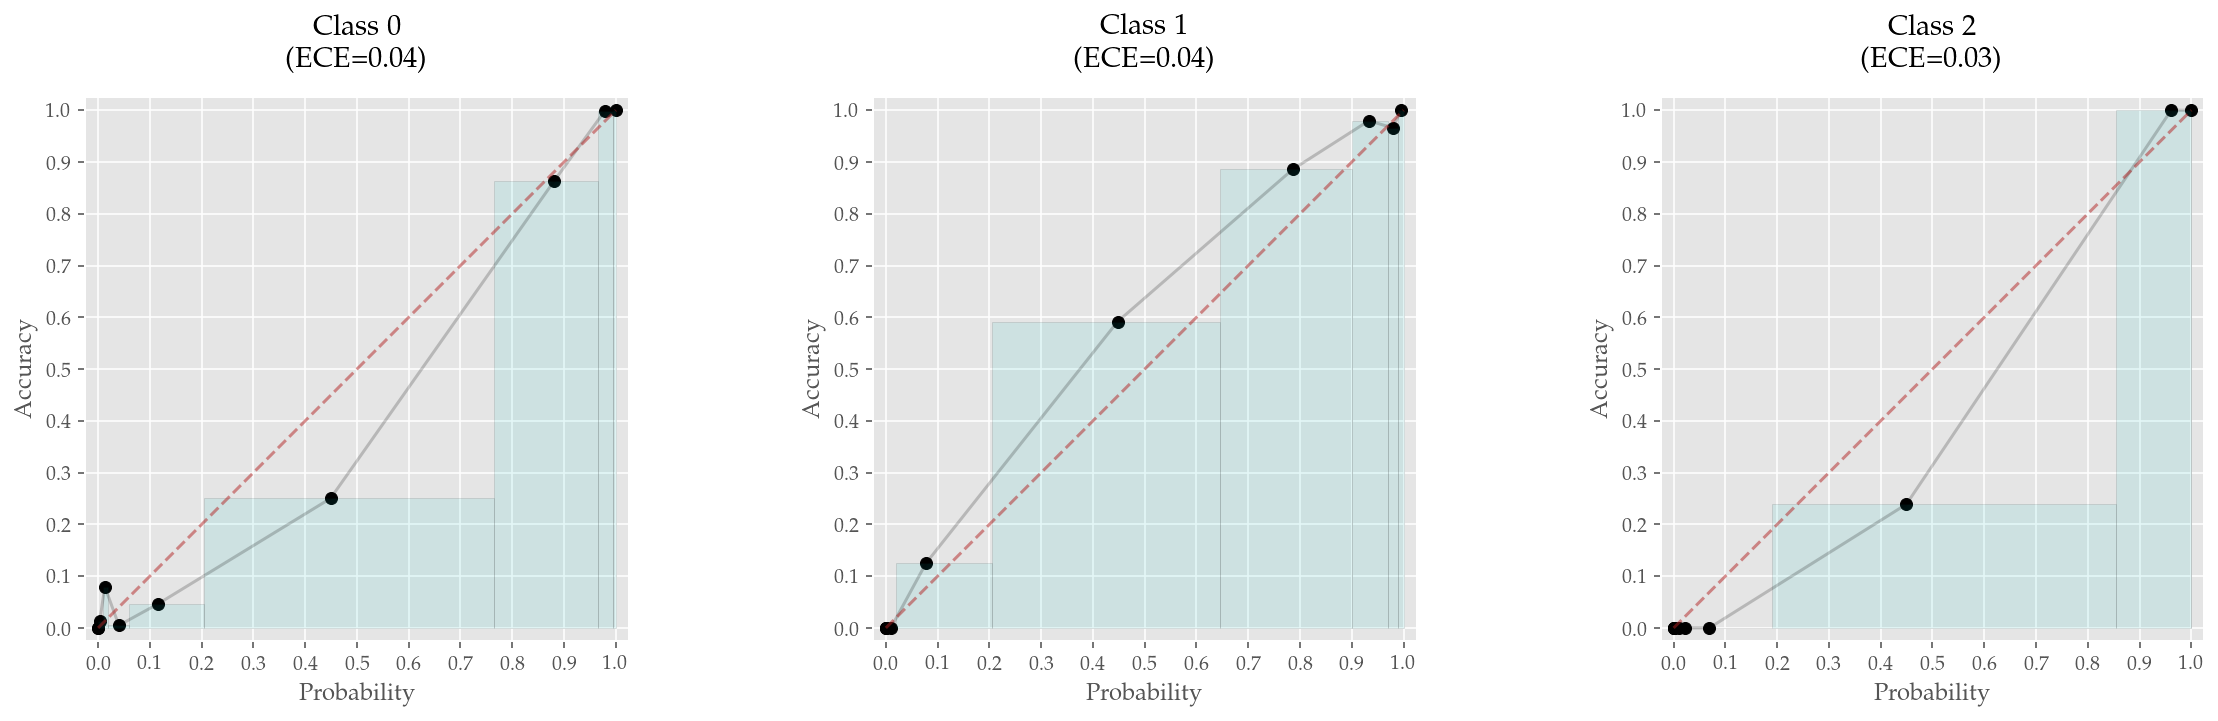

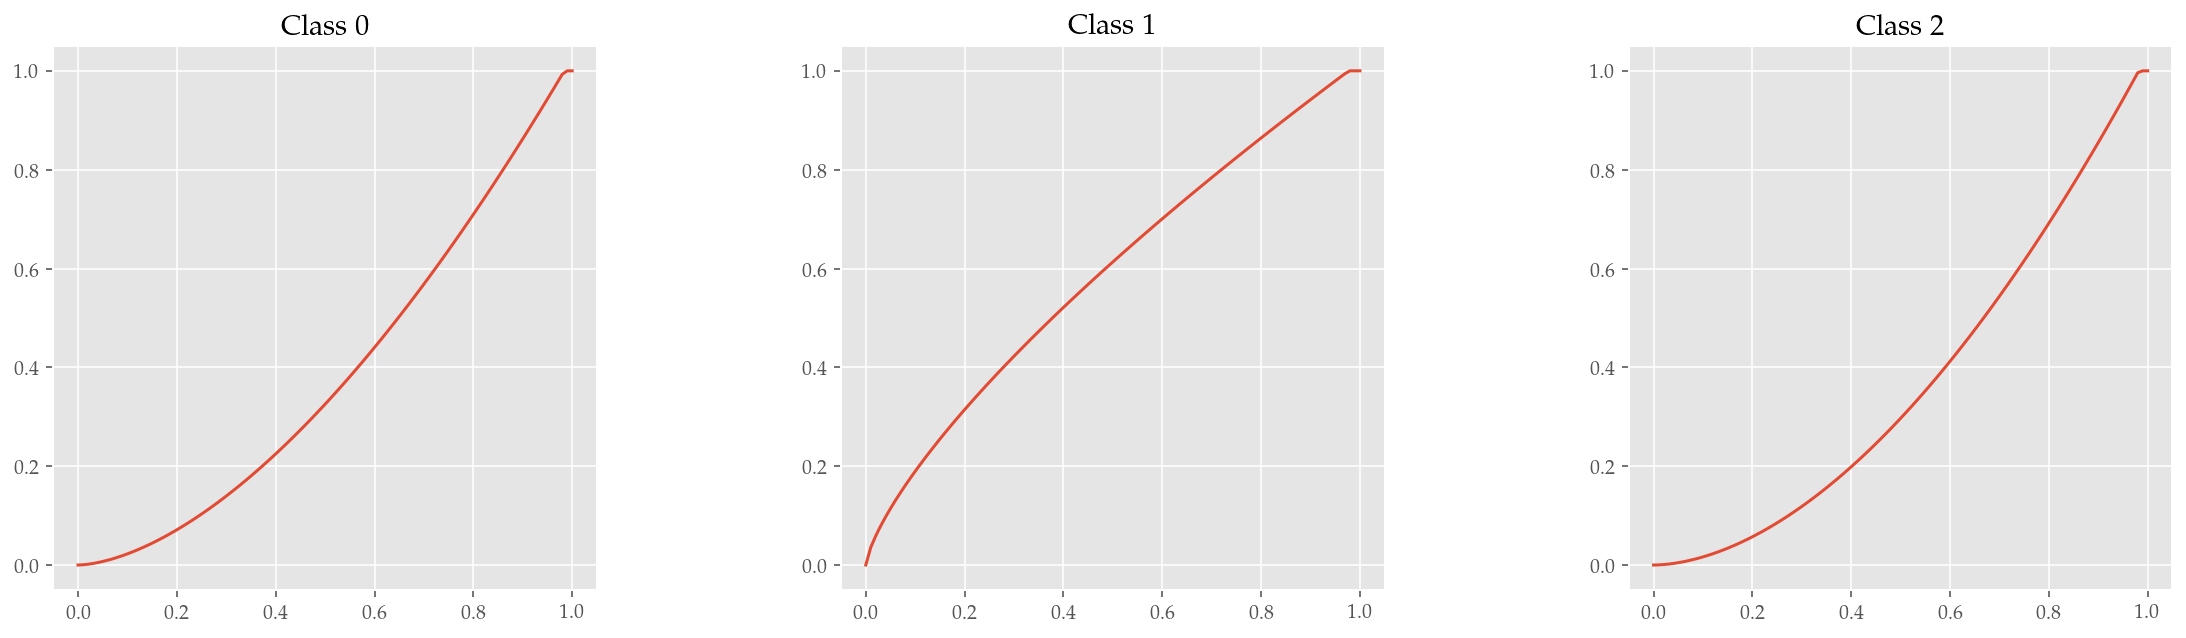

In [19]:
plot_unified_reliability(probs_train, 
                         classes_train, 
                         rel.GaussianKernel(), 
                         even_mass=True, 
                         num_points=NUM_BINS,                          
                         show_bars=True, 
                         show_counts=False, 
                         show_kernel=False, 
                         show_colormap=False)

lr = cal.GammaRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True)
lr.fit(probs_train, classes_train)
plot_cal_curve(lr)

## Calibration

Original Training - Accuracy = 0.91


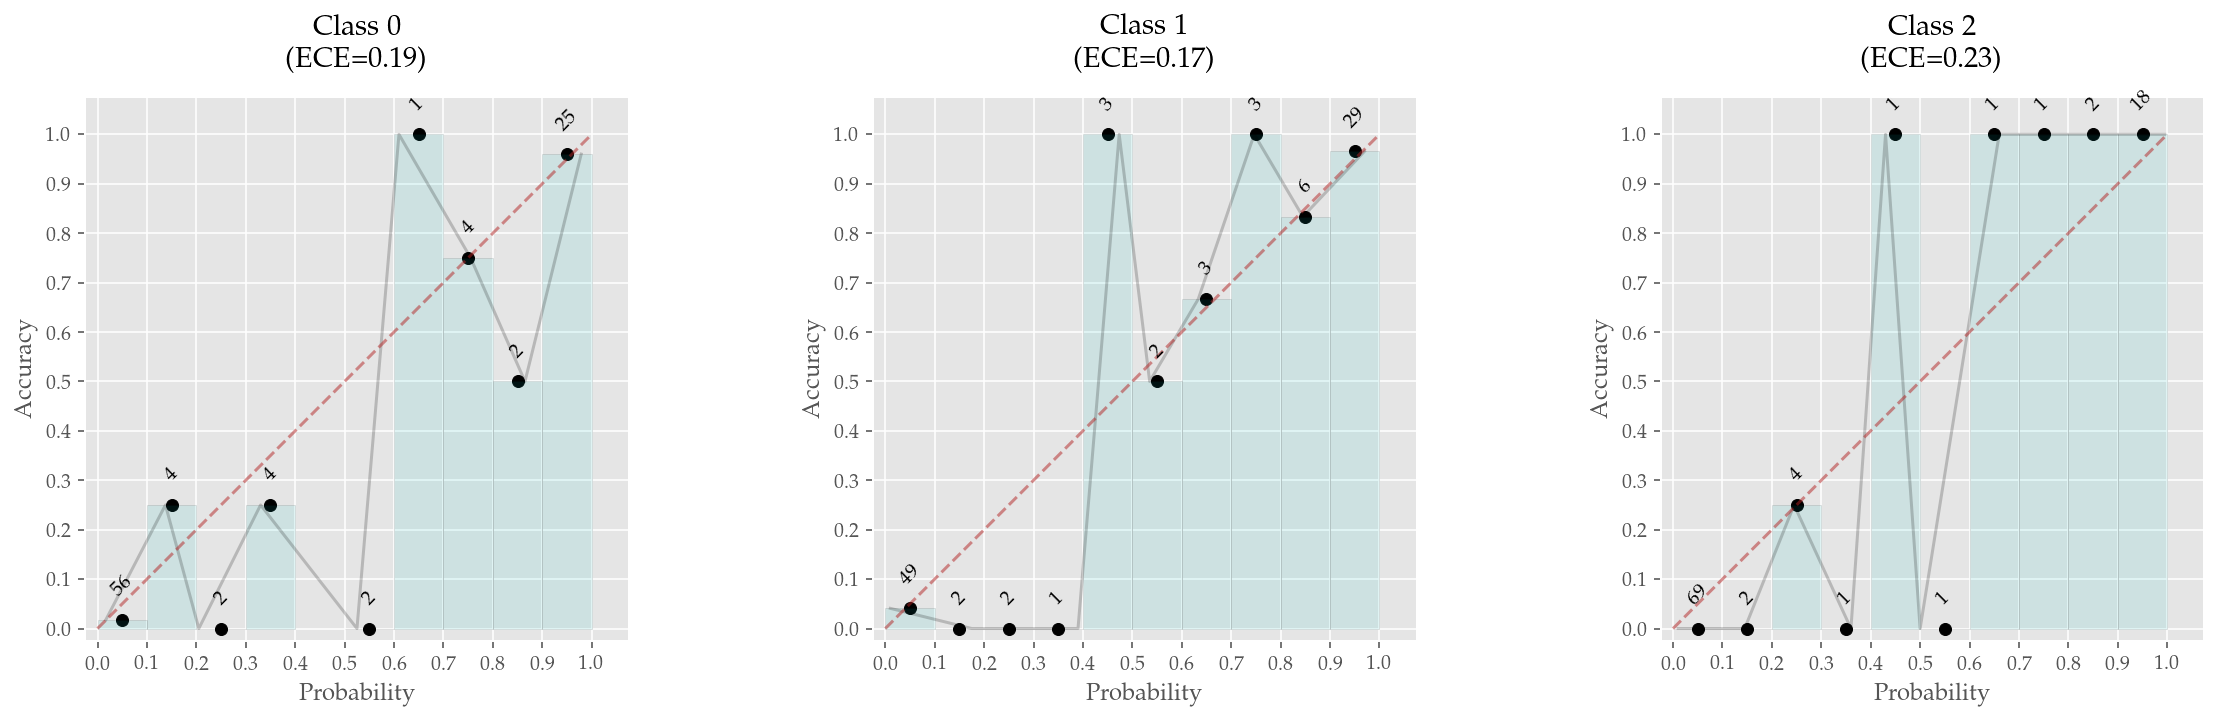

Calibrated Training (unormalized)


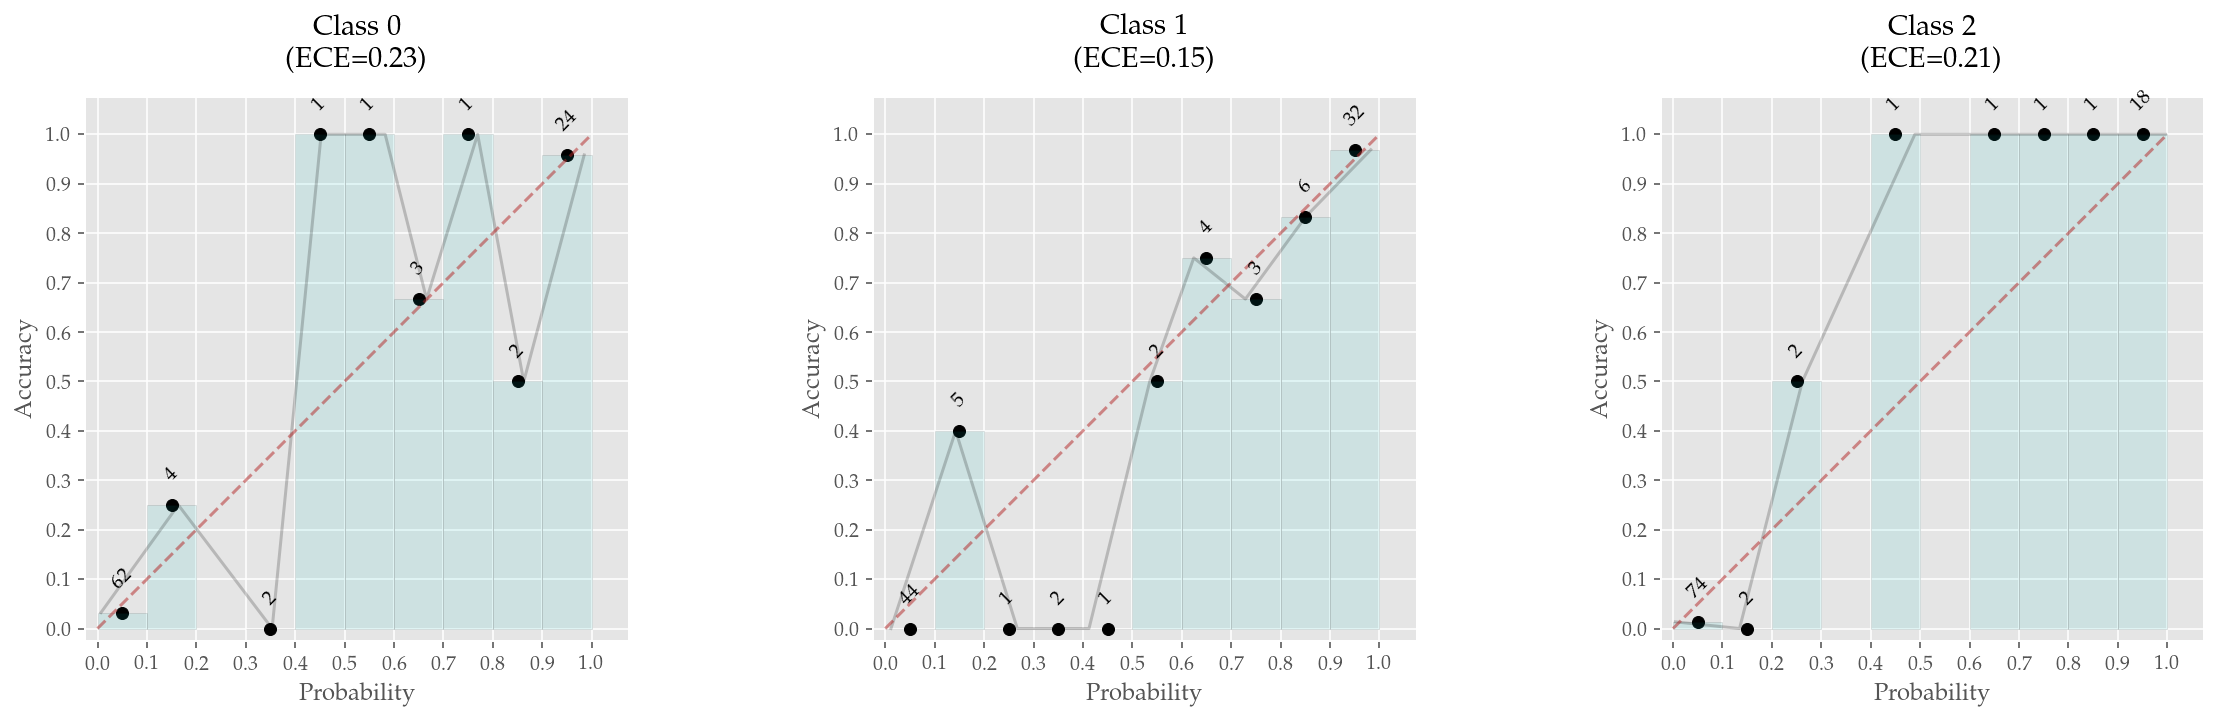

Calibrated Training (normalized) - Accuracy = 0.92


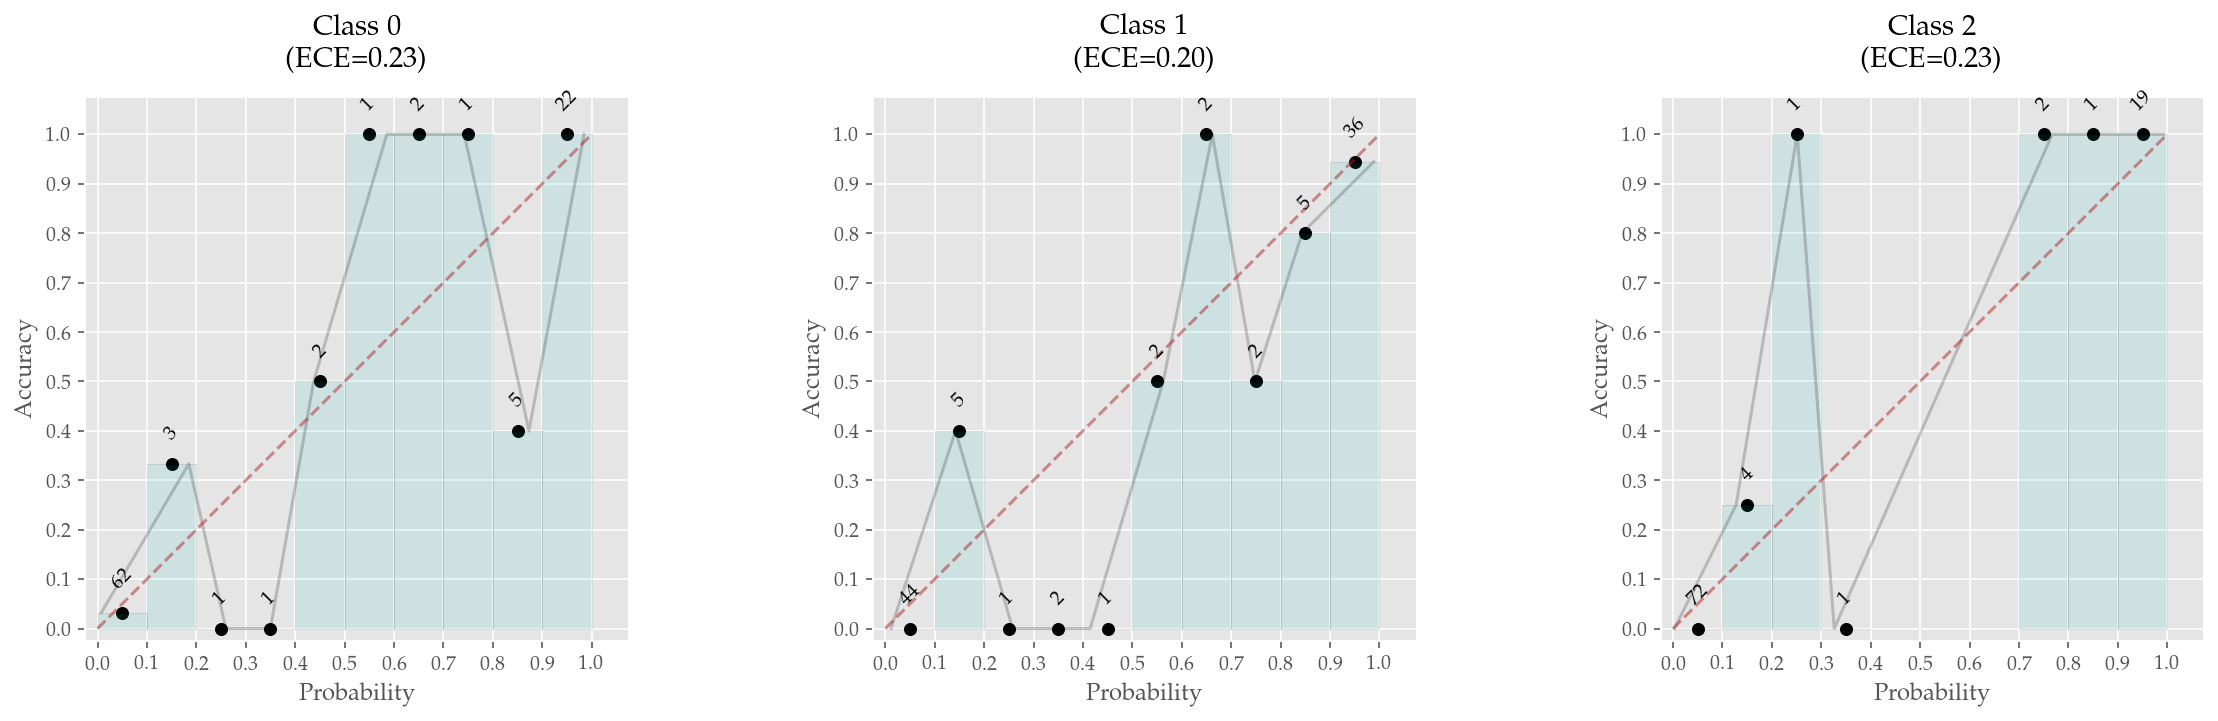

Original Val - Accuracy = 0.92


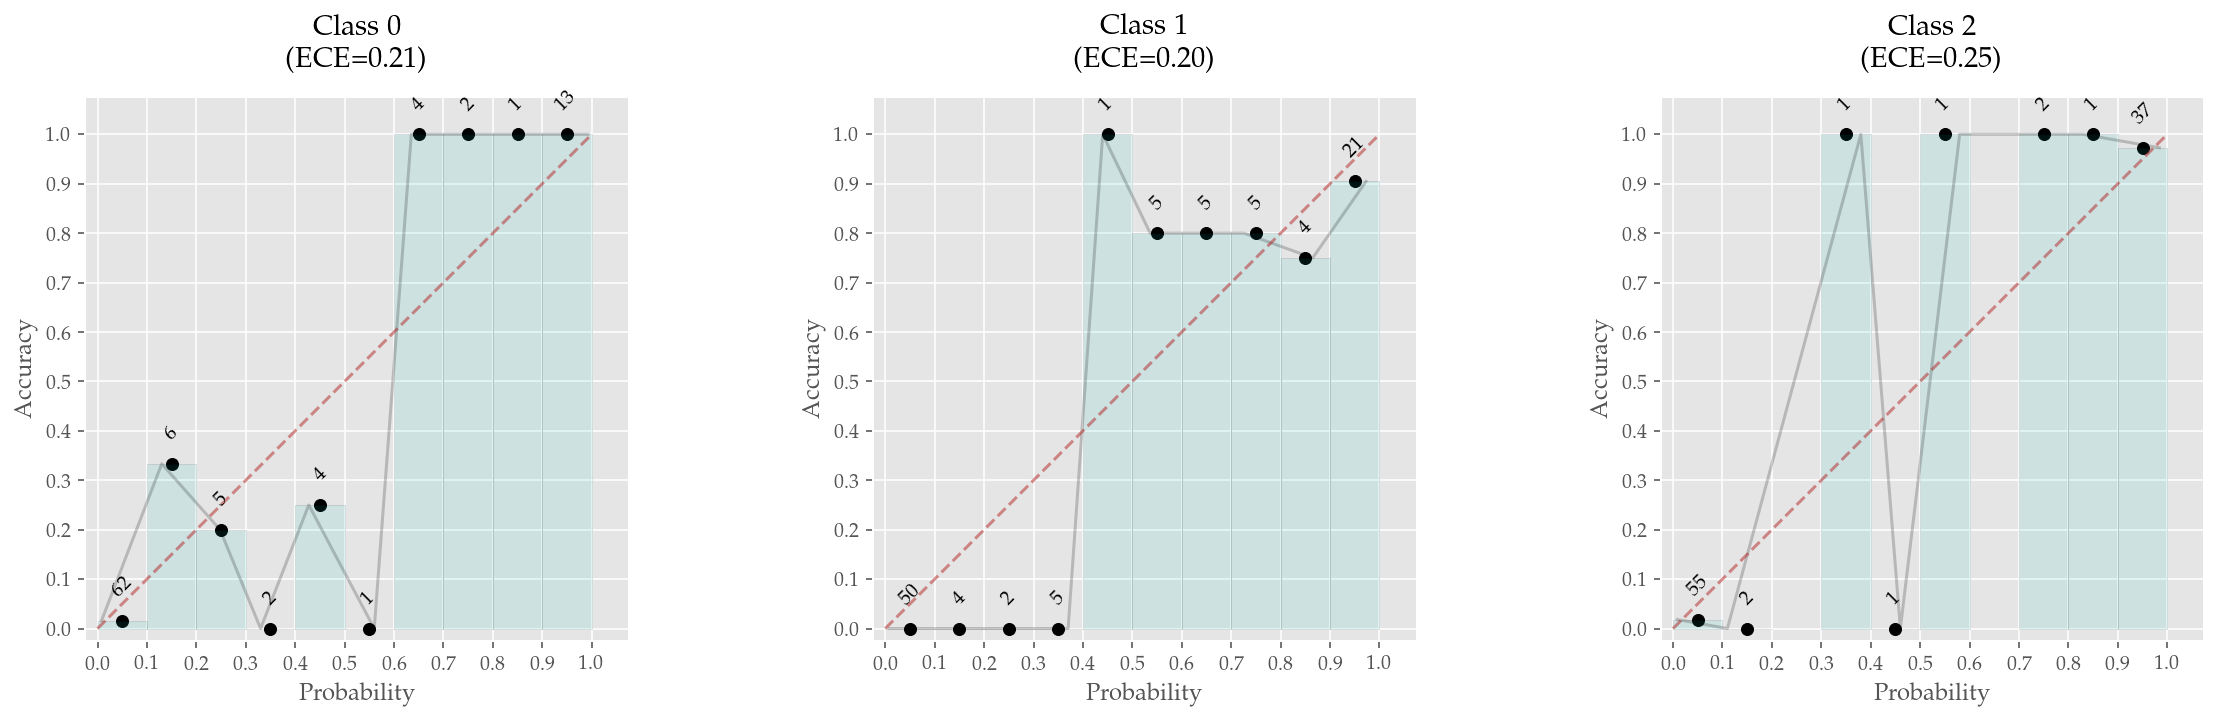

Calibrated Val (unormalized)


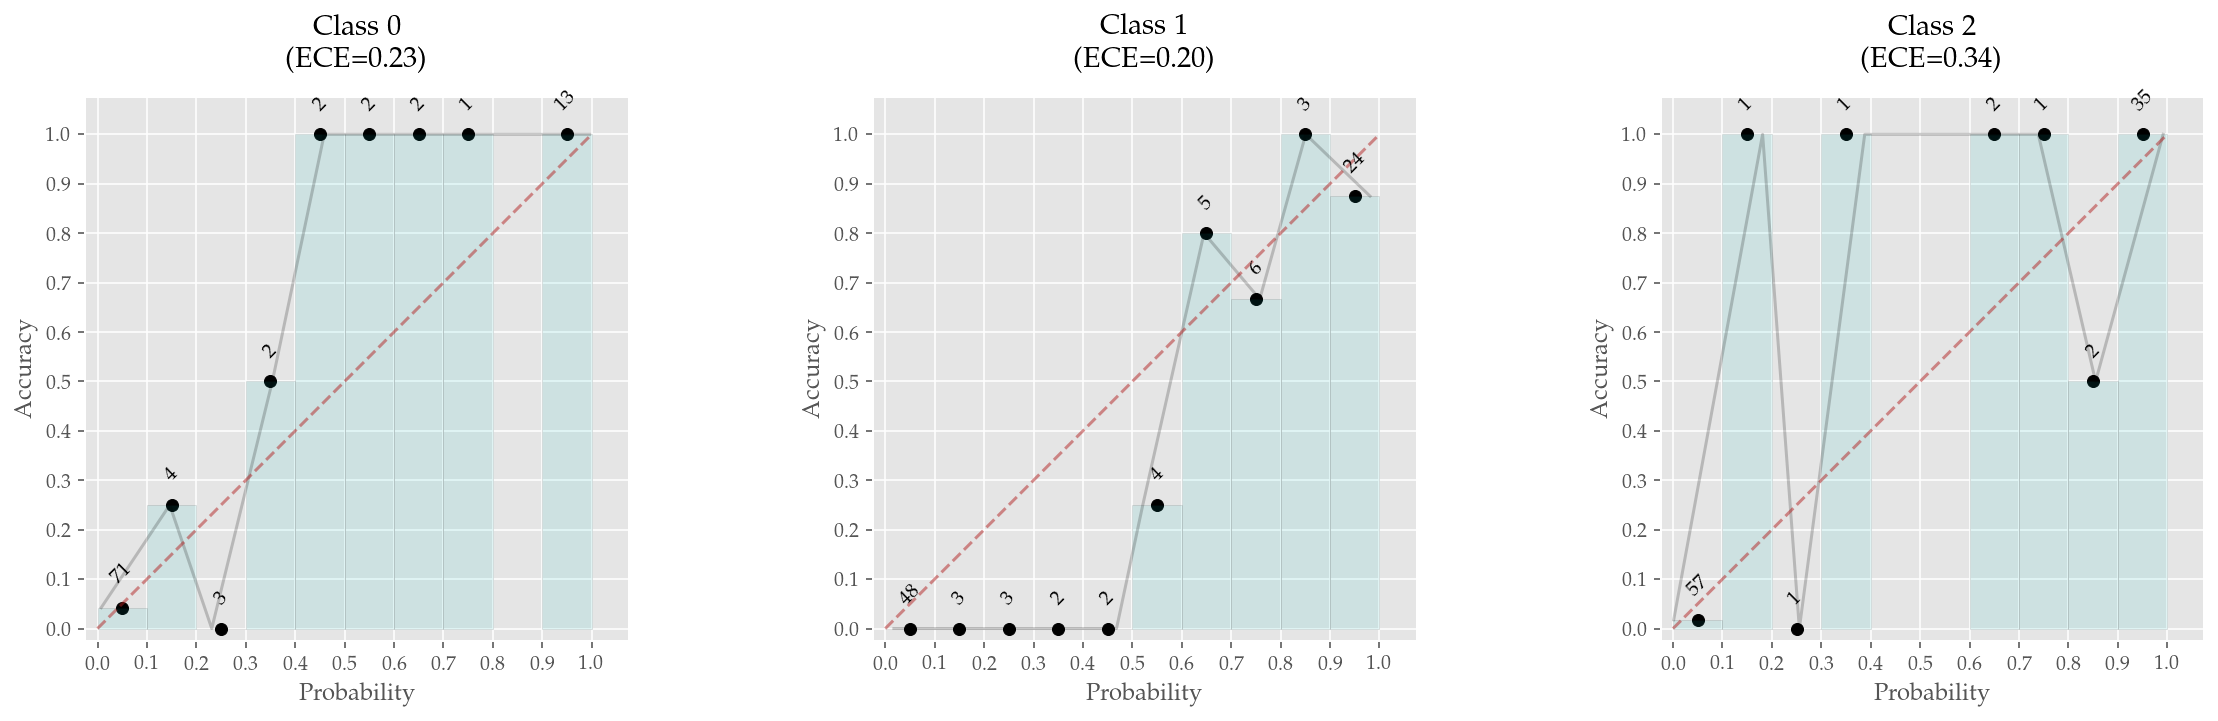

Calibrated Val (normalized) - Accuracy = 0.90


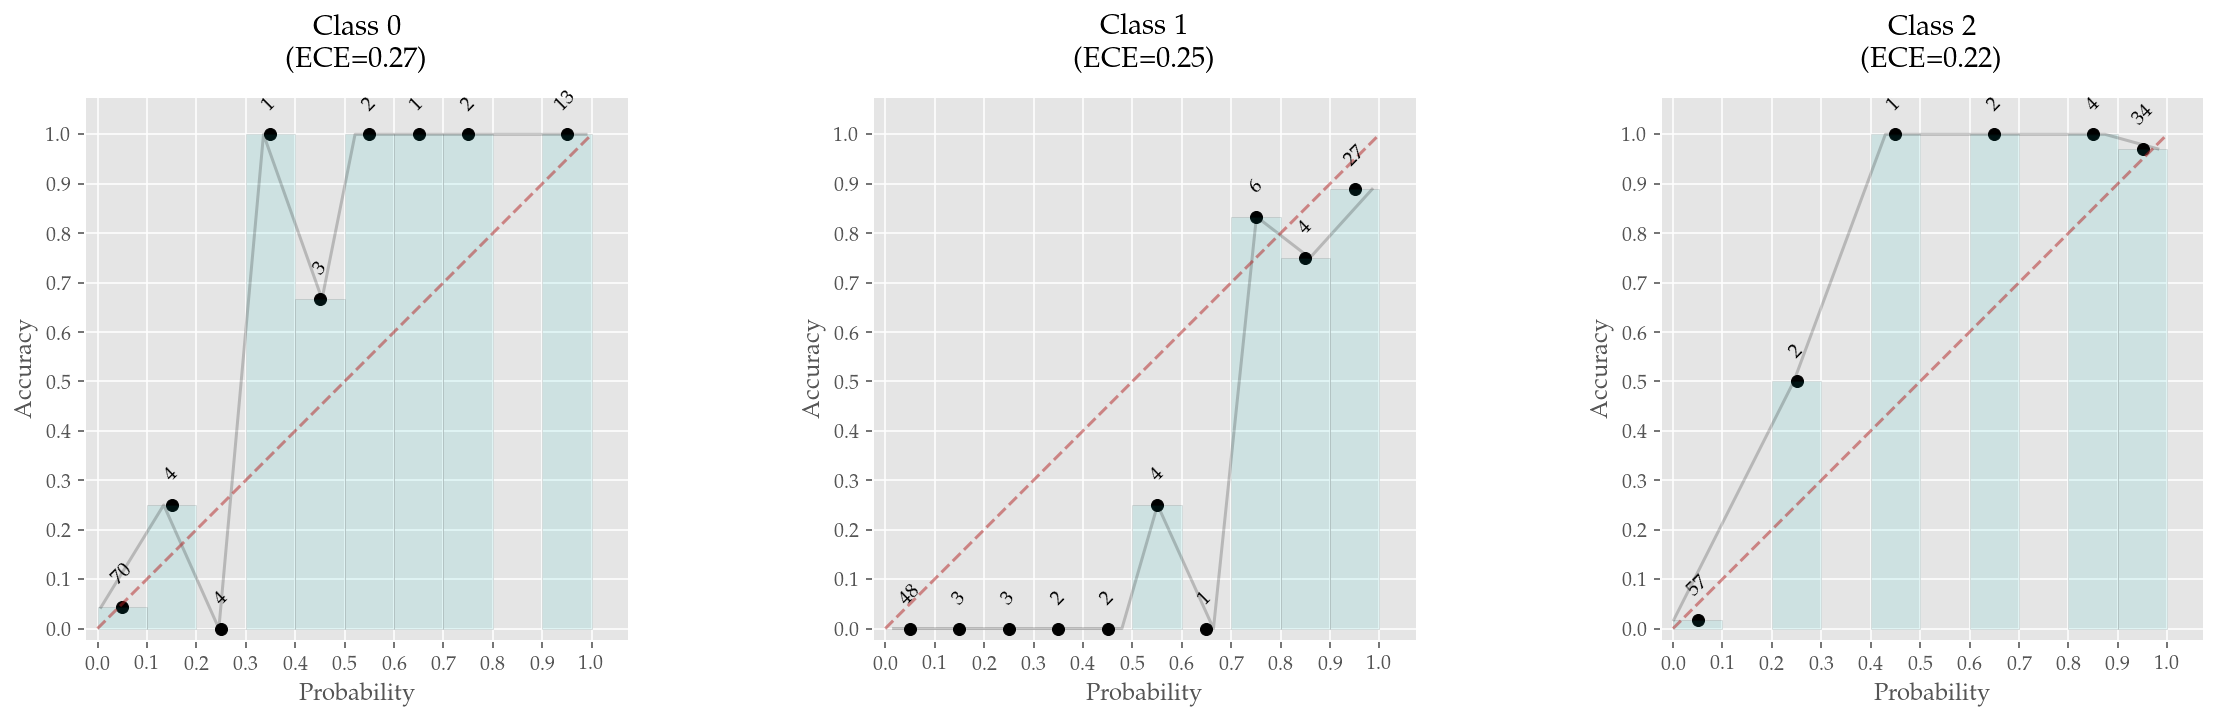

In [20]:
plot_calibration_grid(probs_train, classes_train, lr, classes_val) 

In [21]:
def compare_eces(cal_methods, cal_method_labels, normalize=True):
    np.random.seed(42)
    num_classes = 3
    X, y = datasets.make_classification(n_samples=6000, n_features=20, n_informative=3, 
                                        n_redundant=17, n_classes=num_classes)
    train_samples = 4000
    X_train = X[:train_samples]
    X_test = X[train_samples:]
    y_train = y[:train_samples]
    y_test = y[train_samples:]

    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    prob_pos = rfc.predict_proba(X_test)

    cal_set_sizes = list(range(100, 1001, 100))
    original_eces = []
    cal_method_eces_on_train = np.empty((len(cal_methods), len(cal_set_sizes)))
    cal_method_eces_on_val = np.empty((len(cal_methods), len(cal_set_sizes)))
    for p, cal_set_size in enumerate(cal_set_sizes):
        probs_train = prob_pos[:cal_set_size, :] # Used to calibrate the curves
        classes_train = y_test[:cal_set_size]        
        probs_val = prob_pos[cal_set_size:, :]
        classes_val = y_test[cal_set_size:]
        
        # ECE before calibration
        original_ece = 0         
        for c in range(num_classes):
            x = probs_val[:, c]
            y = np.array(classes_val == c, dtype=np.int)
            original_ece += rel.ReliabilityFit(x, y, cal.DeltaKernel(), False).get_curve(10).ece()    
        original_eces.append(original_ece / num_classes)    
        
        # ECE after calibration
        for m, cal_method in enumerate(cal_methods):
            # Fit probabilities using the training set
            cal_method.fit(probs_train, classes_train)      
            
            # Calibrate both training and test set
            cal_train_probs = cal_method.transform(probs_train, normalize=normalize)
            cal_val_probs = cal_method.transform(probs_val, normalize=normalize)
            cal_method_ece_on_train = 0
            cal_method_ece_on_val = 0            
            for c in range(num_classes):
                # ECE on the training set (calibration set)
                x = cal_train_probs[:, c]
                y = np.array(classes_train == c, dtype=np.int)
                cal_method_ece_on_train += rel.ReliabilityFit(x, y, cal.DeltaKernel(), False).get_curve(10).ece()
                
                # ECE on the validation set
                x = cal_val_probs[:, c]
                y = np.array(classes_val == c, dtype=np.int)
                cal_method_ece_on_val += rel.ReliabilityFit(x, y, cal.DeltaKernel(), False).get_curve(10).ece() 
                
            cal_method_eces_on_train[m, p] = cal_method_ece_on_train / num_classes
            cal_method_eces_on_val[m, p] = cal_method_ece_on_val / num_classes  
            
    cal_method_eces_per_set = [cal_method_eces_on_train, cal_method_eces_on_val]
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    titles = ['Training Set Calibration', 'Test Set Calibration']
    for i, cal_method_eces in enumerate(cal_method_eces_per_set):
        ax[i].plot(cal_set_sizes, original_eces, label='Before Calibration')
        for m in range(len(cal_methods)):
            ax[i].plot(cal_set_sizes, cal_method_eces[m], label=cal_method_labels[m])
        ax[i].set_xlabel('Calibration/Test set size')
        ax[i].set_ylabel('Average ECE across classes')
        ax[i].legend()
        ax[i].set_title(titles[i])
        
    plt.show()

No class normalization


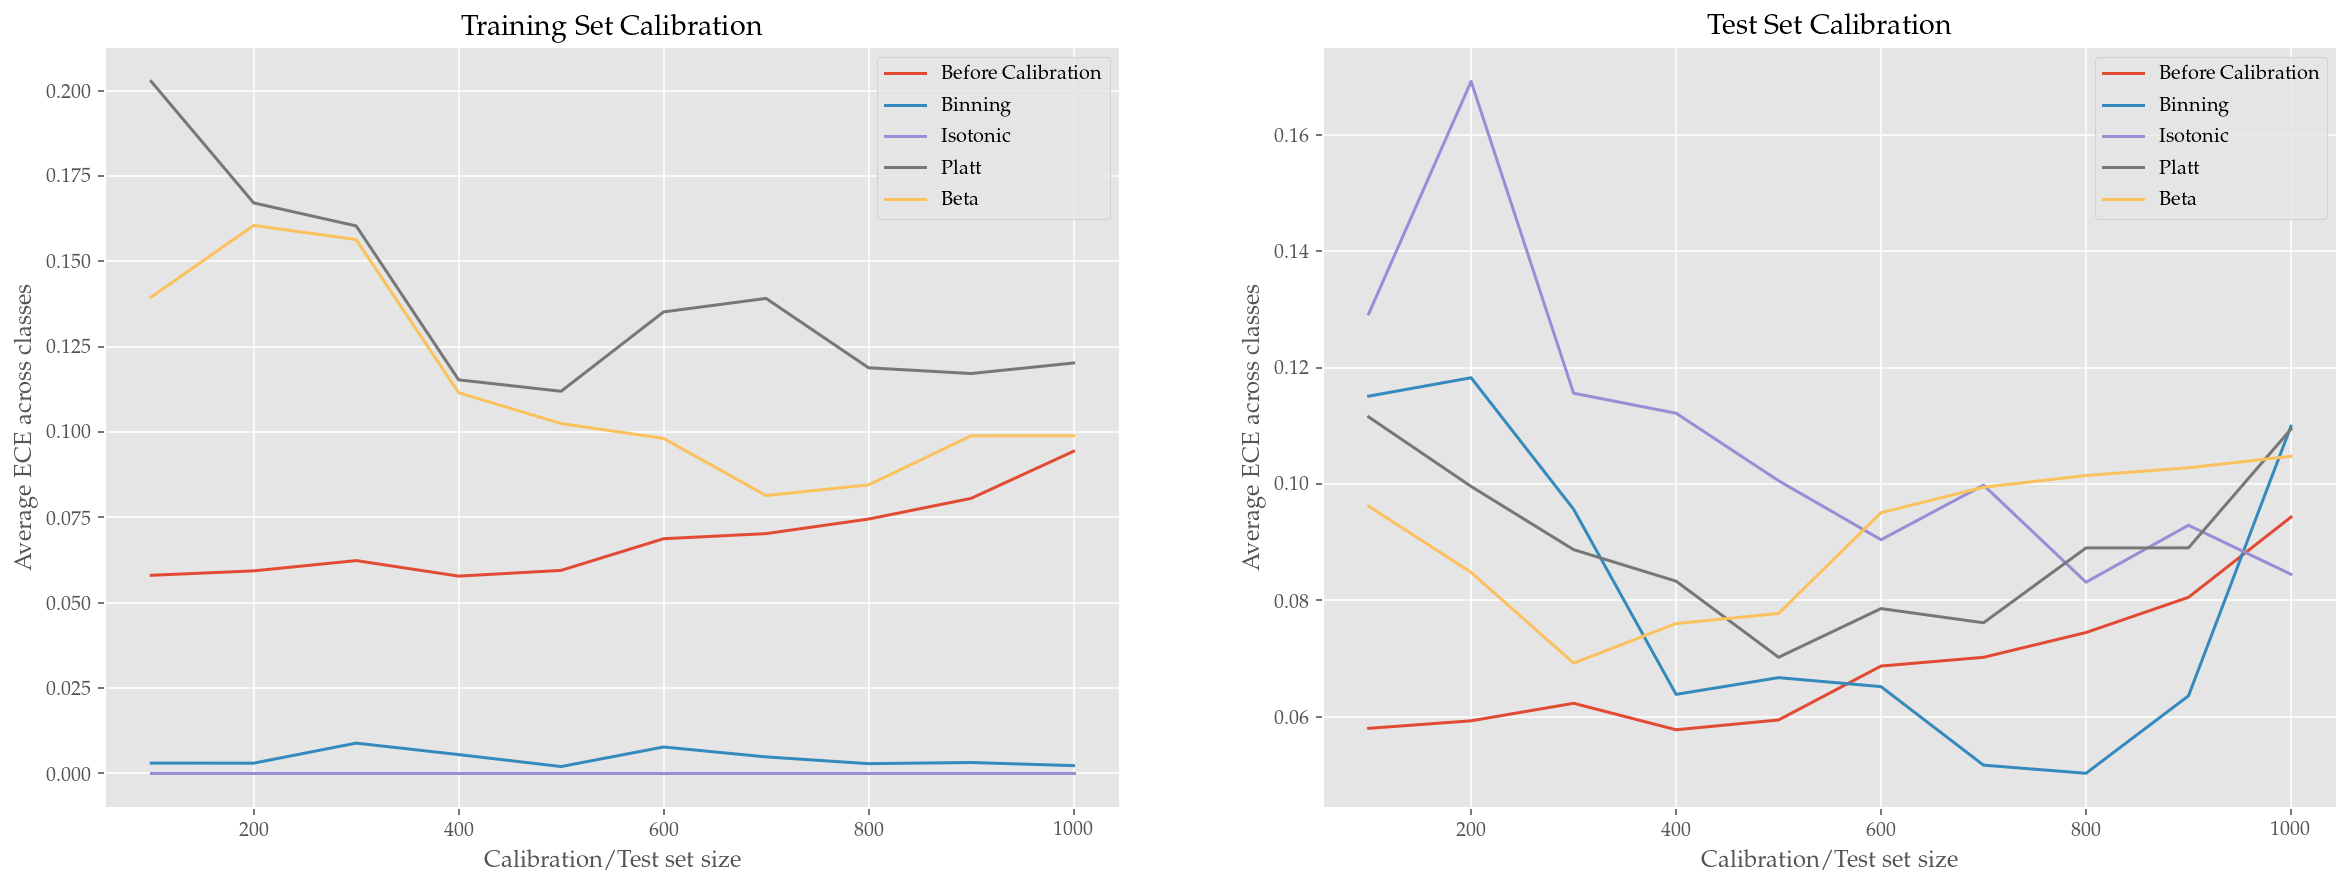

With class normalization


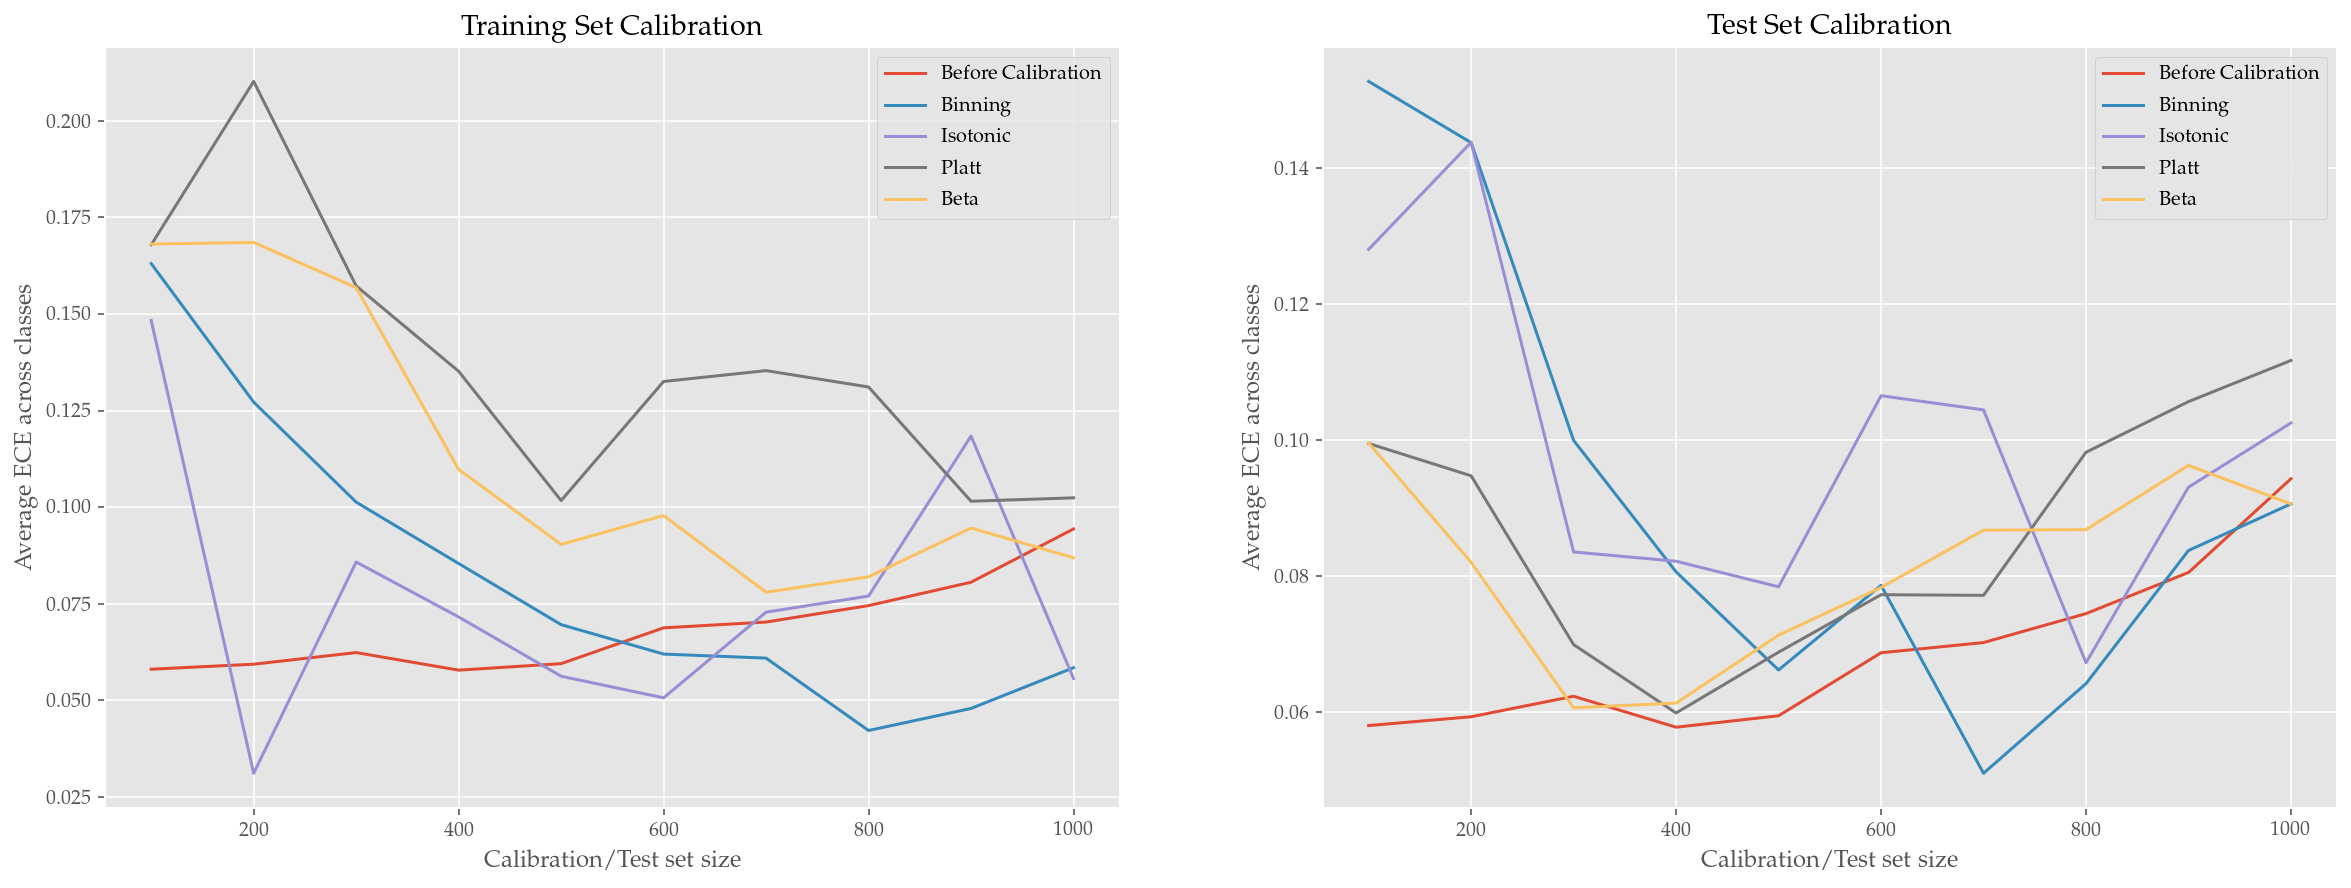

In [22]:
cal_methods = [cal.BinningCalibration(num_points=10, even_mass=False),
               cal.IsotonicCalibration(),
               cal.PlattCalibration(),
               cal.BetaCalibration()]
cal_method_labels = ['Binning',
                     'Isotonic',
                     'Platt',
                     'Beta']

print('No class normalization')
compare_eces(cal_methods, cal_method_labels, normalize=False)

print('With class normalization')
compare_eces(cal_methods, cal_method_labels, normalize=True)

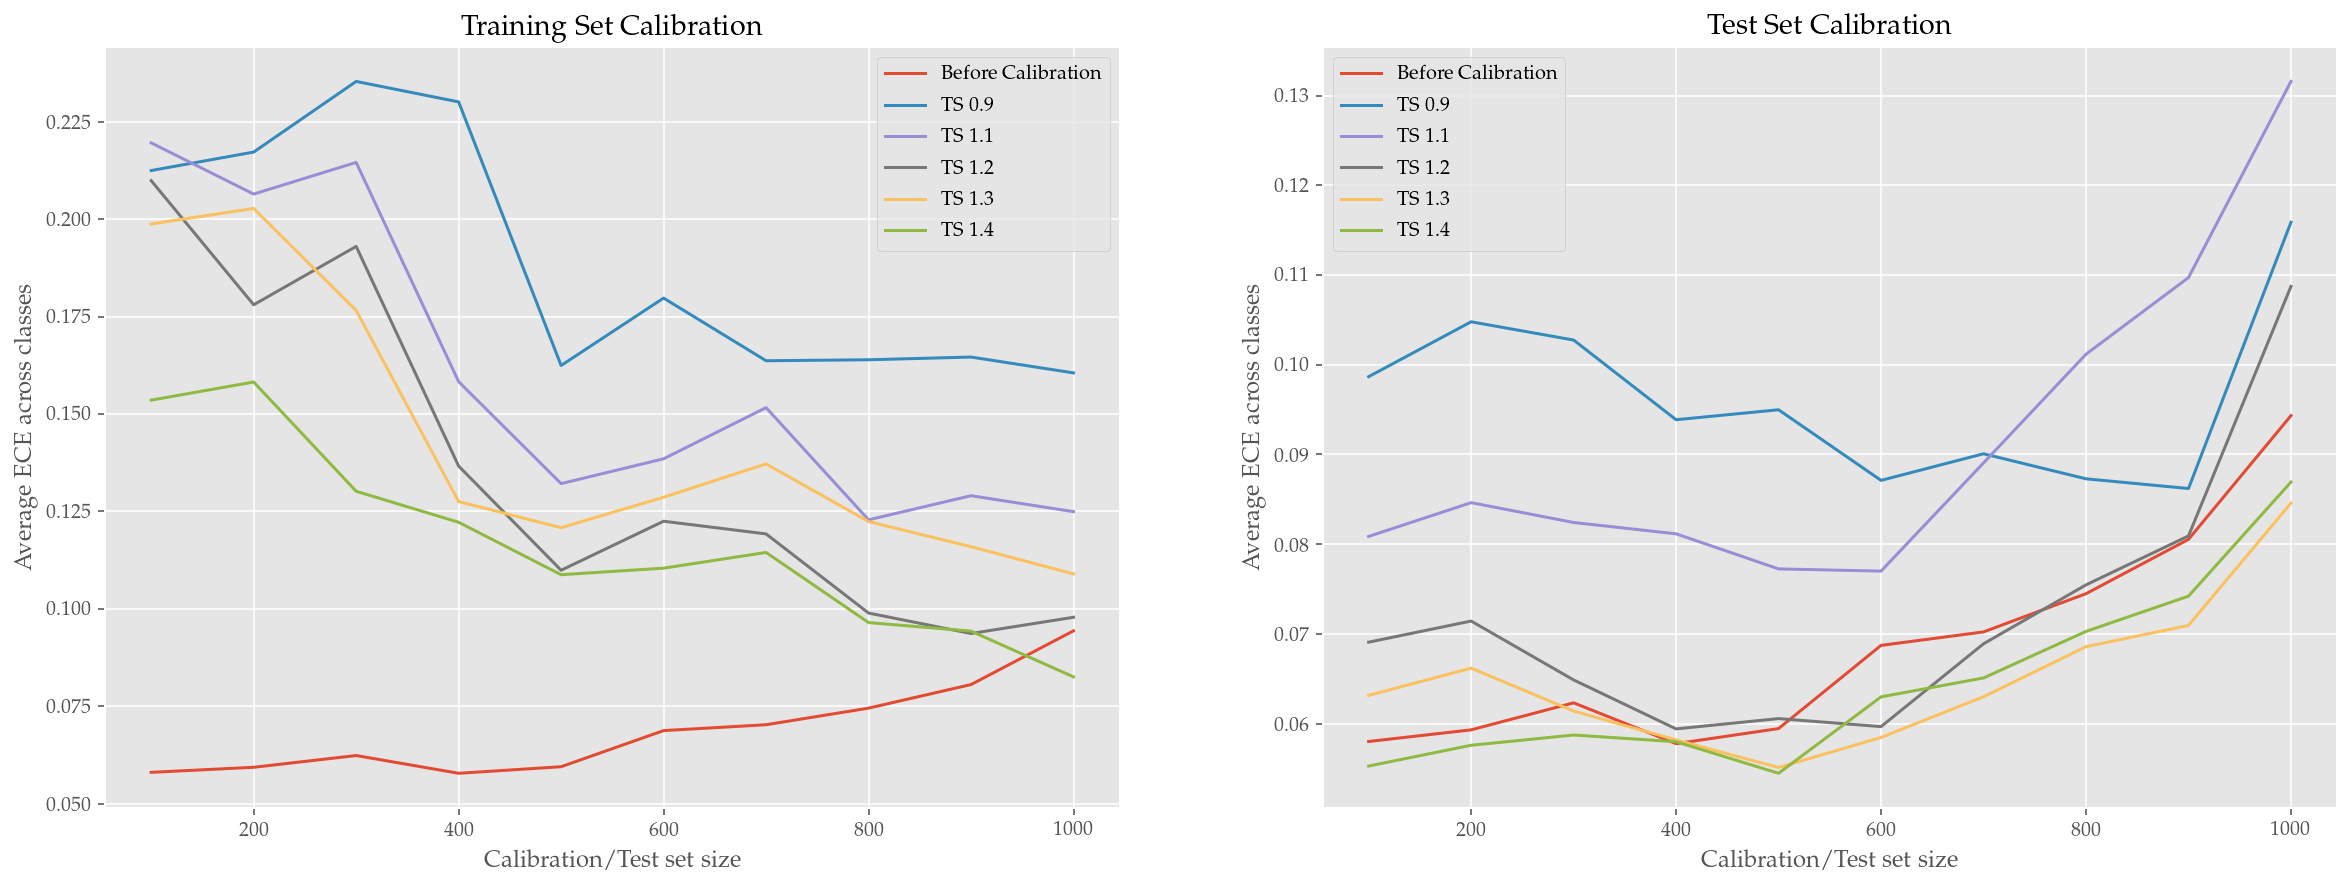

In [23]:
cal_methods = [cal.TemperatureScaling(0.9),
               cal.TemperatureScaling(1.1),         
               cal.TemperatureScaling(1.2),           
               cal.TemperatureScaling(1.3),           
               cal.TemperatureScaling(1.4)]
cal_method_labels = ['TS 0.9',
                     'TS 1.1',
                     'TS 1.2',
                     'TS 1.3',
                     'TS 1.4']

# This is a multiclass method thus the calibrated probabilities are already normalized across classes
compare_eces(cal_methods, cal_method_labels, normalize=False)

No class normalization


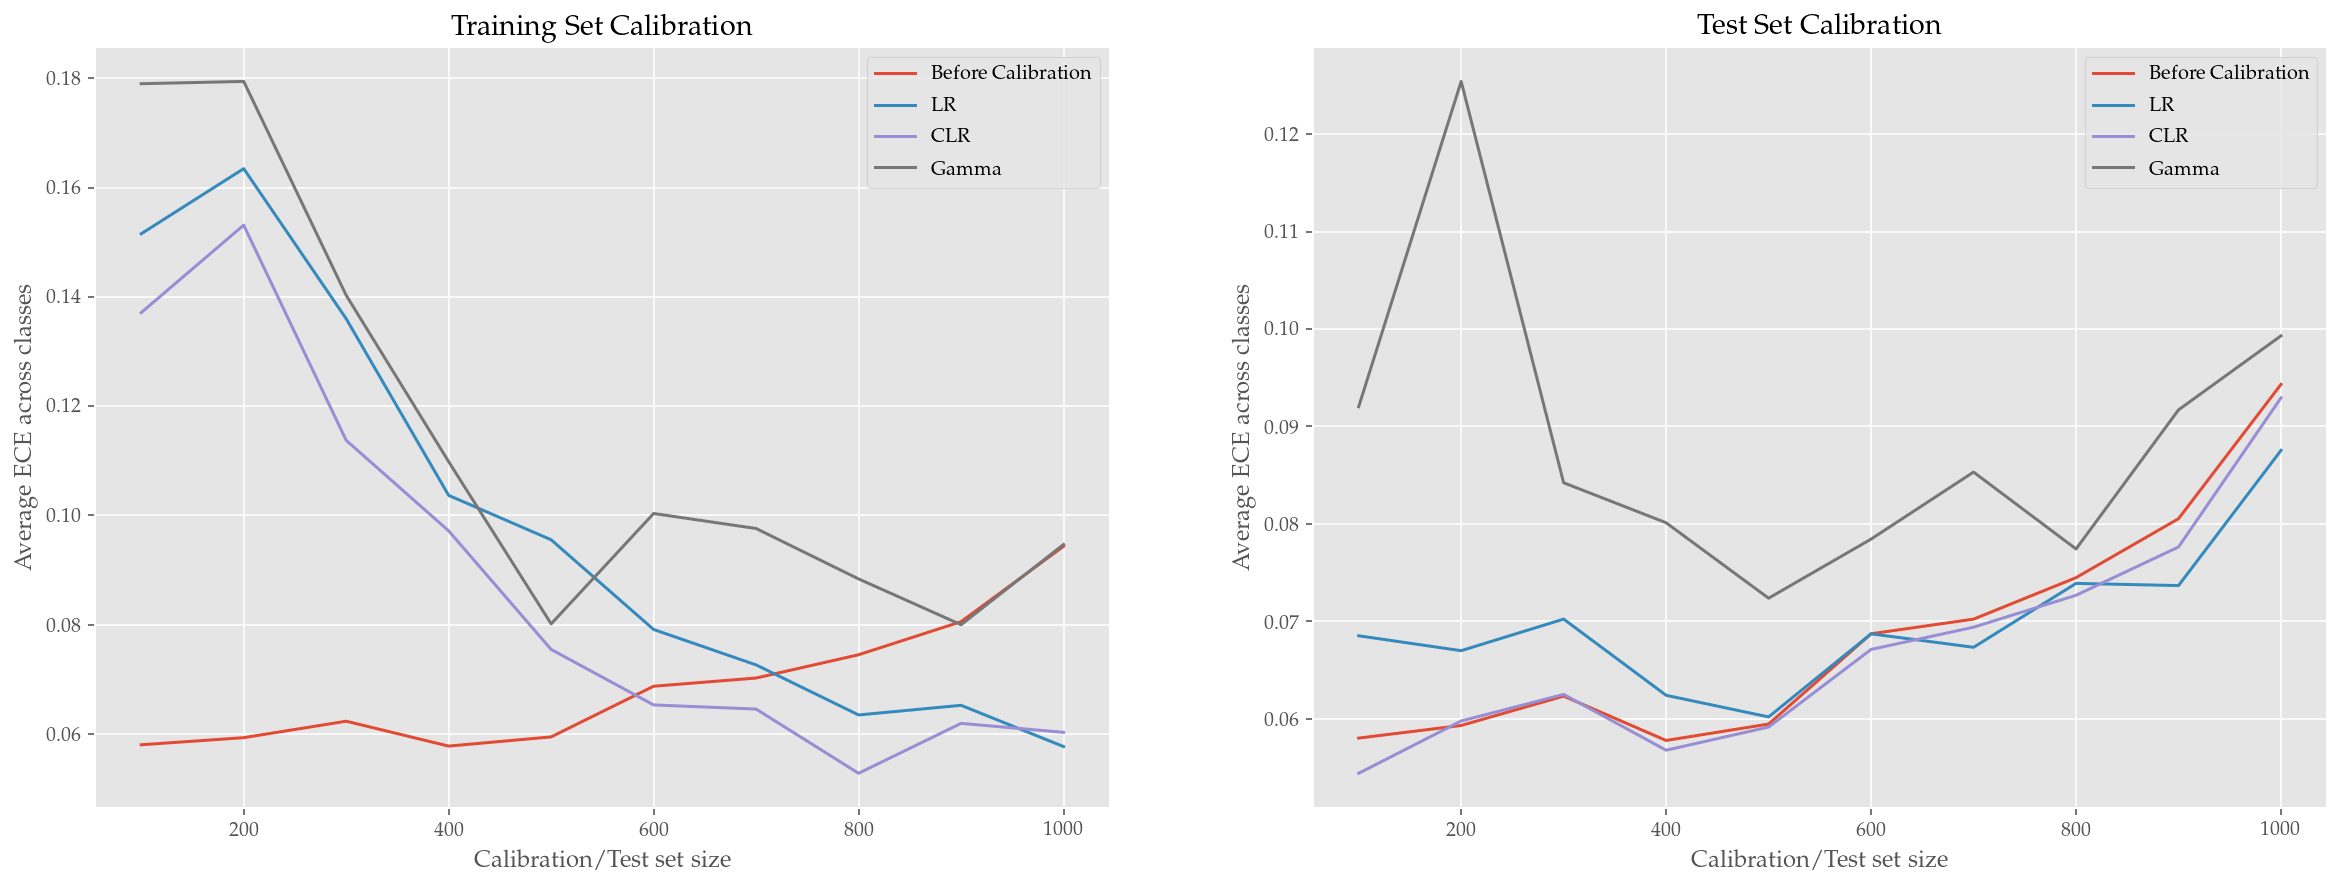

With class normalization


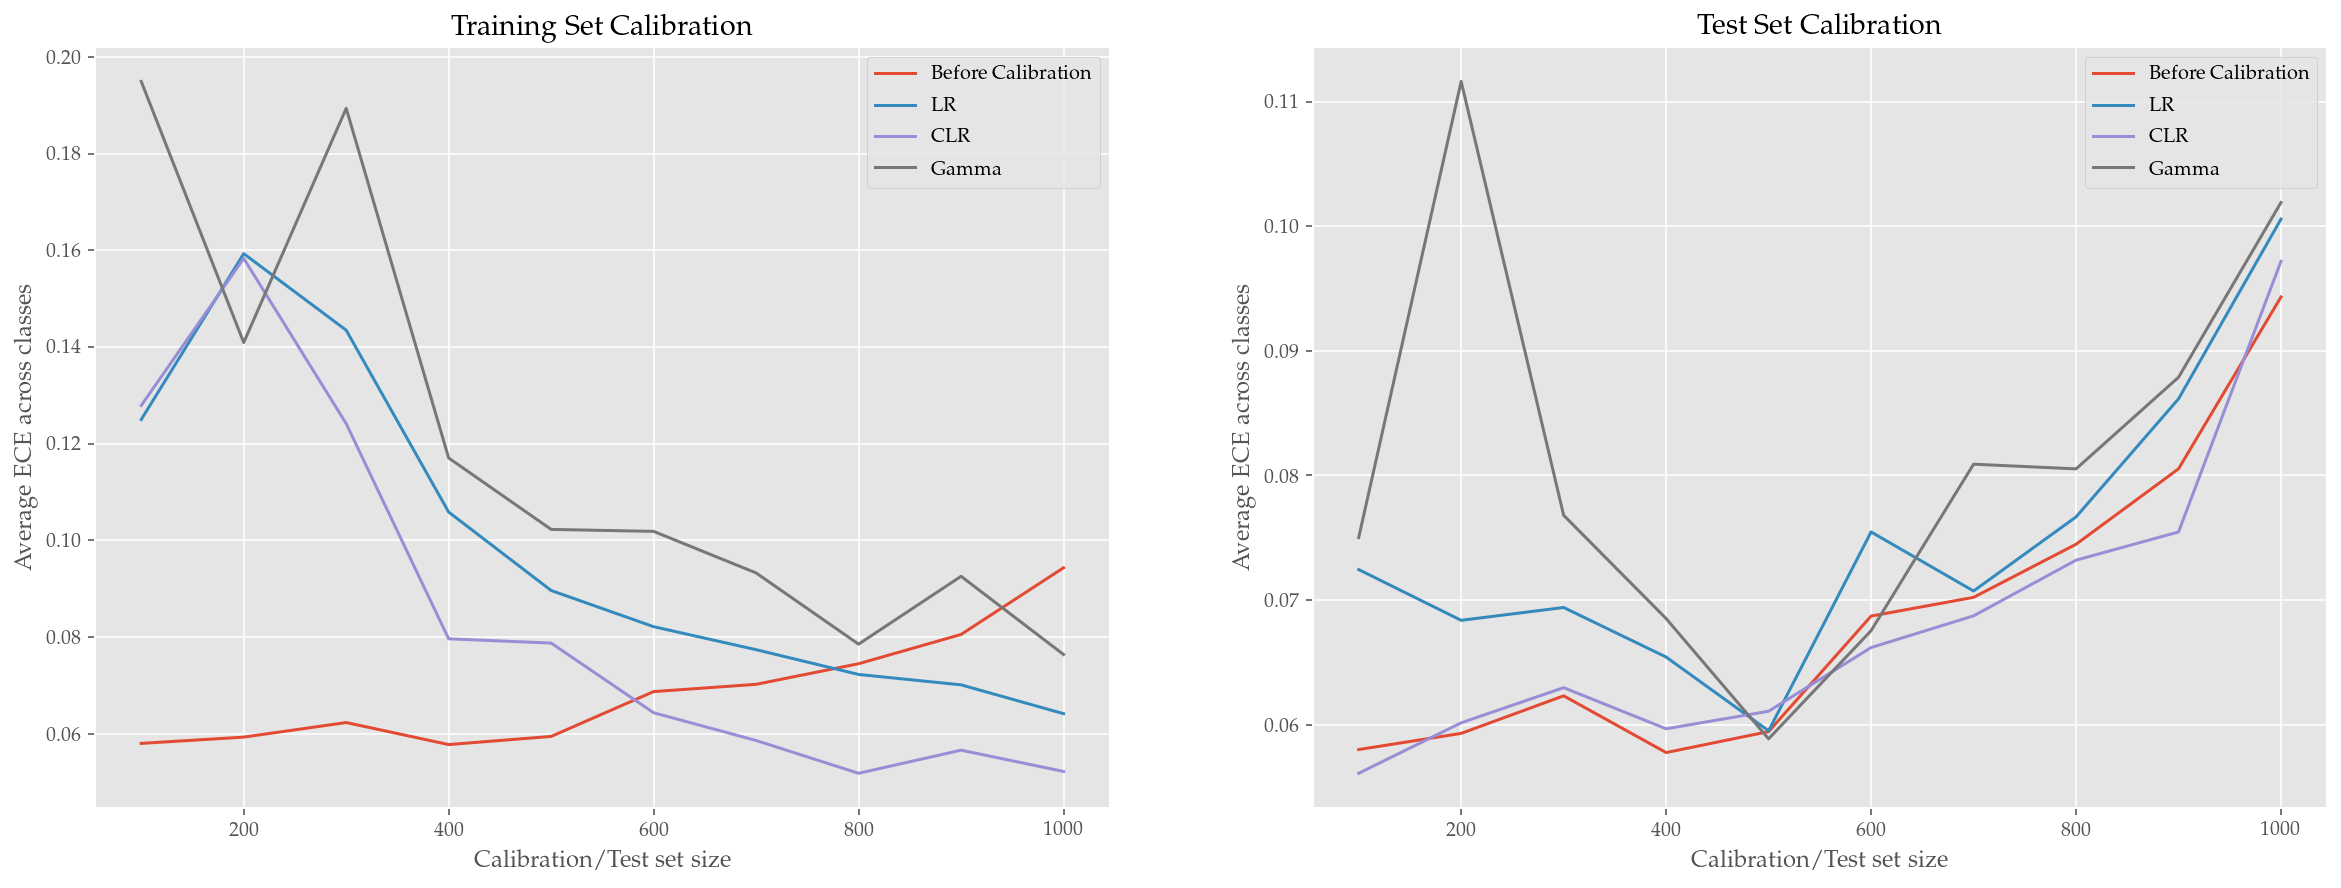

In [24]:
cal_methods = [cal.LinearRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True),
               cal.ConstrainedLinearRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True),
               cal.GammaRegressionCalibration(rel.GaussianKernel(), NUM_BINS, even_mass=True, clip_logits=True)]
cal_method_labels = ['LR',
                     'CLR',
                     'Gamma']

print('No class normalization')
compare_eces(cal_methods, cal_method_labels, normalize=False)

print('With class normalization')
compare_eces(cal_methods, cal_method_labels, normalize=True)